In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import swarmplot
import os,itertools
import numpy as np
from IPython.display import HTML 
%matplotlib inline
import matplotlib as mpl


In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), '../resources/accuracy_set.csv'), index_col=0, dtype={'input' : object, 'output': object})

drop_columns = ['Unnamed: 0', 'SynBioHub URI', 'Unnamed: 0.1', 'calibration_id', 'experiment_id', 'filename', 
                'glycerol_plate_index',  'growth_media_1', 'growth_media_2',  
                'inc_temp', 'inc_time_1', 'inc_time_2', 'input', 'lab', 'lab_id', 'media', 'od', 
                'od_cutoff', 'output', 'part_1_id', 'part_2_id', 'plate_id',  'replicate', 'source_container', 
                'strain_name', 'strain_circuit', 'well', 'post_well']
od_df = pd.read_csv(os.path.join(os.getcwd(), '../resources/tx_od.csv')).rename(columns={'strain' : 'strain_name'}).drop(columns=drop_columns)
df = df.merge(od_df, on='id', how='left')
discretization = [
          (0.0, 1e-4),
          (1e-4, 3e-4),
          (3e-4, 7e-4),
          (7e-4, 1e-3),
          (1e-3, 5.1e-3),
          (5.1e-3, 1.0)
      ]
means = [np.around(np.mean(d),5) for d in discretization]
means[-1] = 5.1e-3
recast = [means[i] for d in df["od"] for i,k in enumerate(discretization) if d > k[0] and d <= k[1] ]
df["od"] = recast


In [3]:
correctness_col='mean_correct_classifier_live'
conditions=['inc_time_2', 'media', 'inc_temp', 'od']
design=['gate', 'input']


# Strain x condition scores is mean of samples for condition
strain_score_df = df.groupby(conditions+design)[correctness_col].agg(np.mean).reset_index()



In [4]:
# Circuit x condition scores is product of strain for condition
circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
HTML(circuit_score_df_prod.to_html(index=False))

In [5]:
mpl.rcParams['figure.dpi']= 600
csdp = circuit_score_df_prod
def make_plot(gate):
    plt.figure()
    df_prod = csdp[(csdp["gate"]==gate)]# & (csdp["inc_time_2"]==inc)]
    swarmplot(x="media",y=correctness_col,hue="inc_temp",data=df_prod)
    plt.ylim((0,1))
    plt.ylabel("Correctness")
#     plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
    
def make_plot_od(gate):
    plt.figure()
    df_prod = csdp[(csdp["gate"]==gate)]# & (csdp["inc_time_2"]==inc)]
    swarmplot(x="media",y=correctness_col,hue="od",data=df_prod)
    plt.ylim((0,1))
    plt.ylabel("Correctness")
#     plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
    
def make_3D_plot(gate):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.grid(False)
    df_prod = csdp[(csdp["gate"]==gate)]
    _,temp_uniques = df_prod.od.factorize()
    list_of_temps=[]
    for t in temp_uniques:
        df_prod_temp = df_prod[(df_prod["od"]==t)]        
        x,uniques = df_prod_temp.media.factorize()
        y = df_prod_temp.inc_temp
        z = df_prod_temp[correctness_col]
        ax.scatter(x,y,z,label=t)
    ax.set_xticks([0,1,2])
    ax.w_xaxis.set_ticklabels(list(uniques))
    ax.set_ylabel("Temperature")
    ax.set_zlim([0,1])
#     ax.set_ylim([0,0.006])
    ax.set_zlabel("Correctness")
    ax.legend()
    plt.show()
    


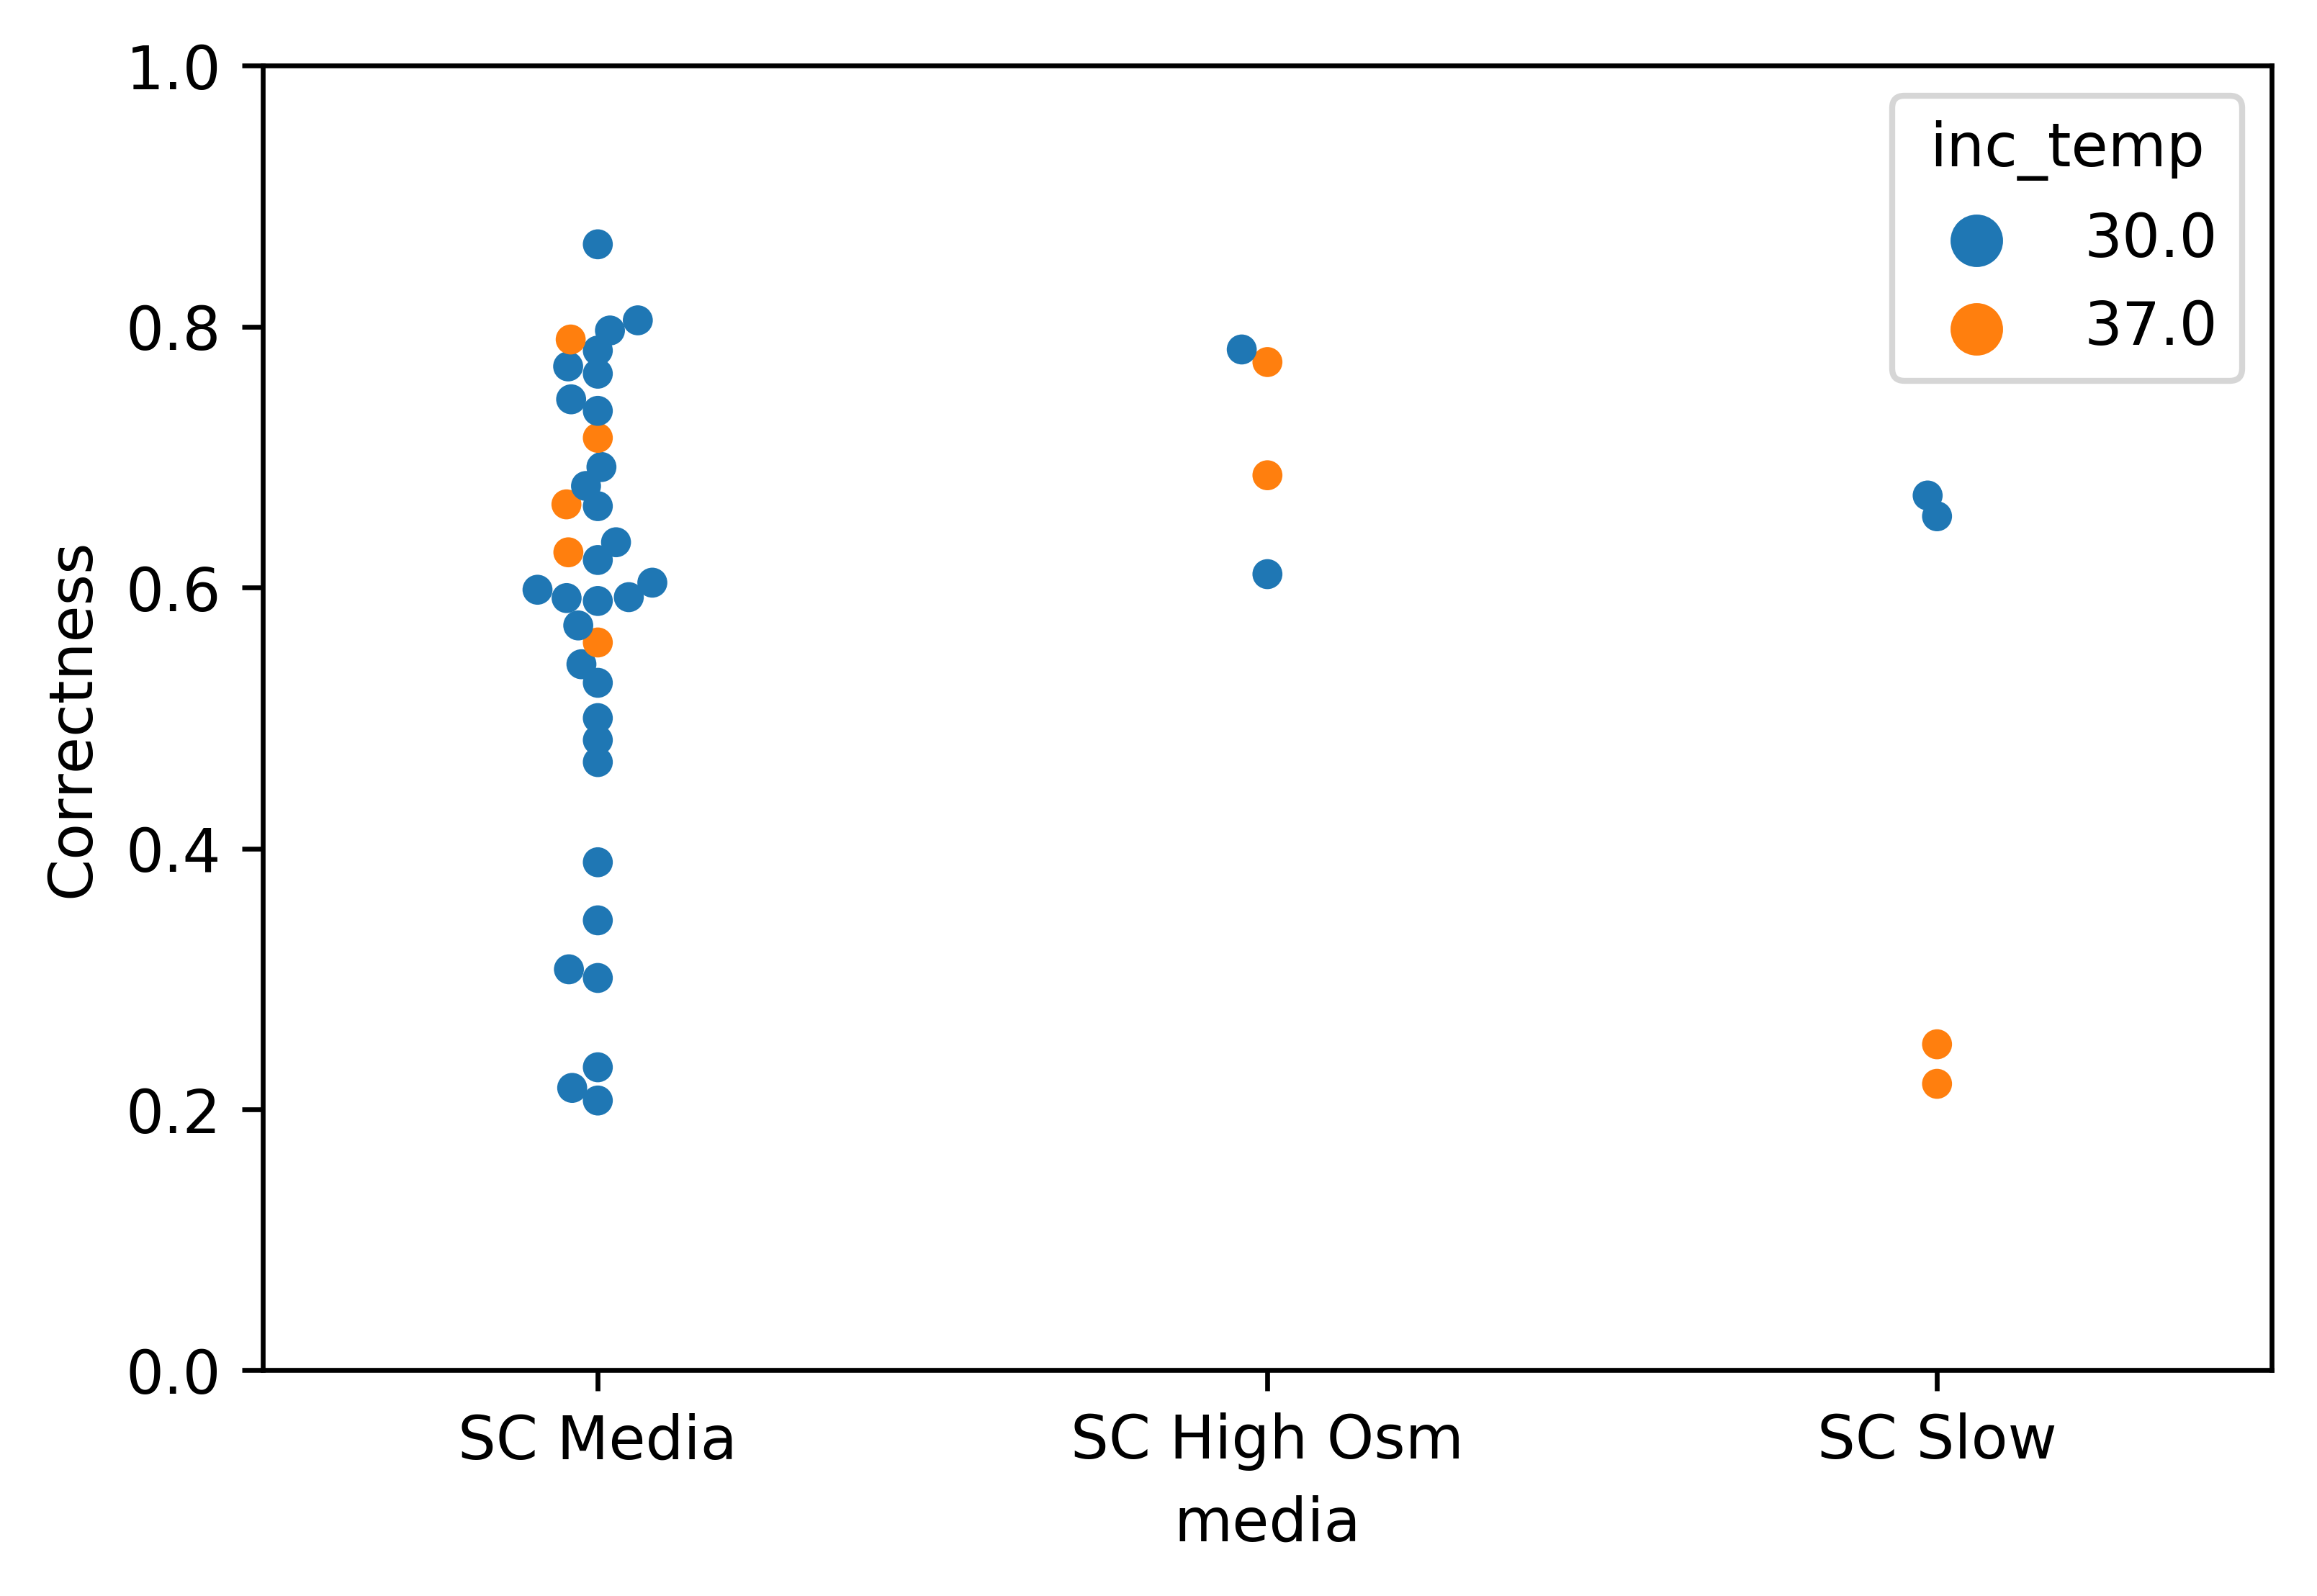

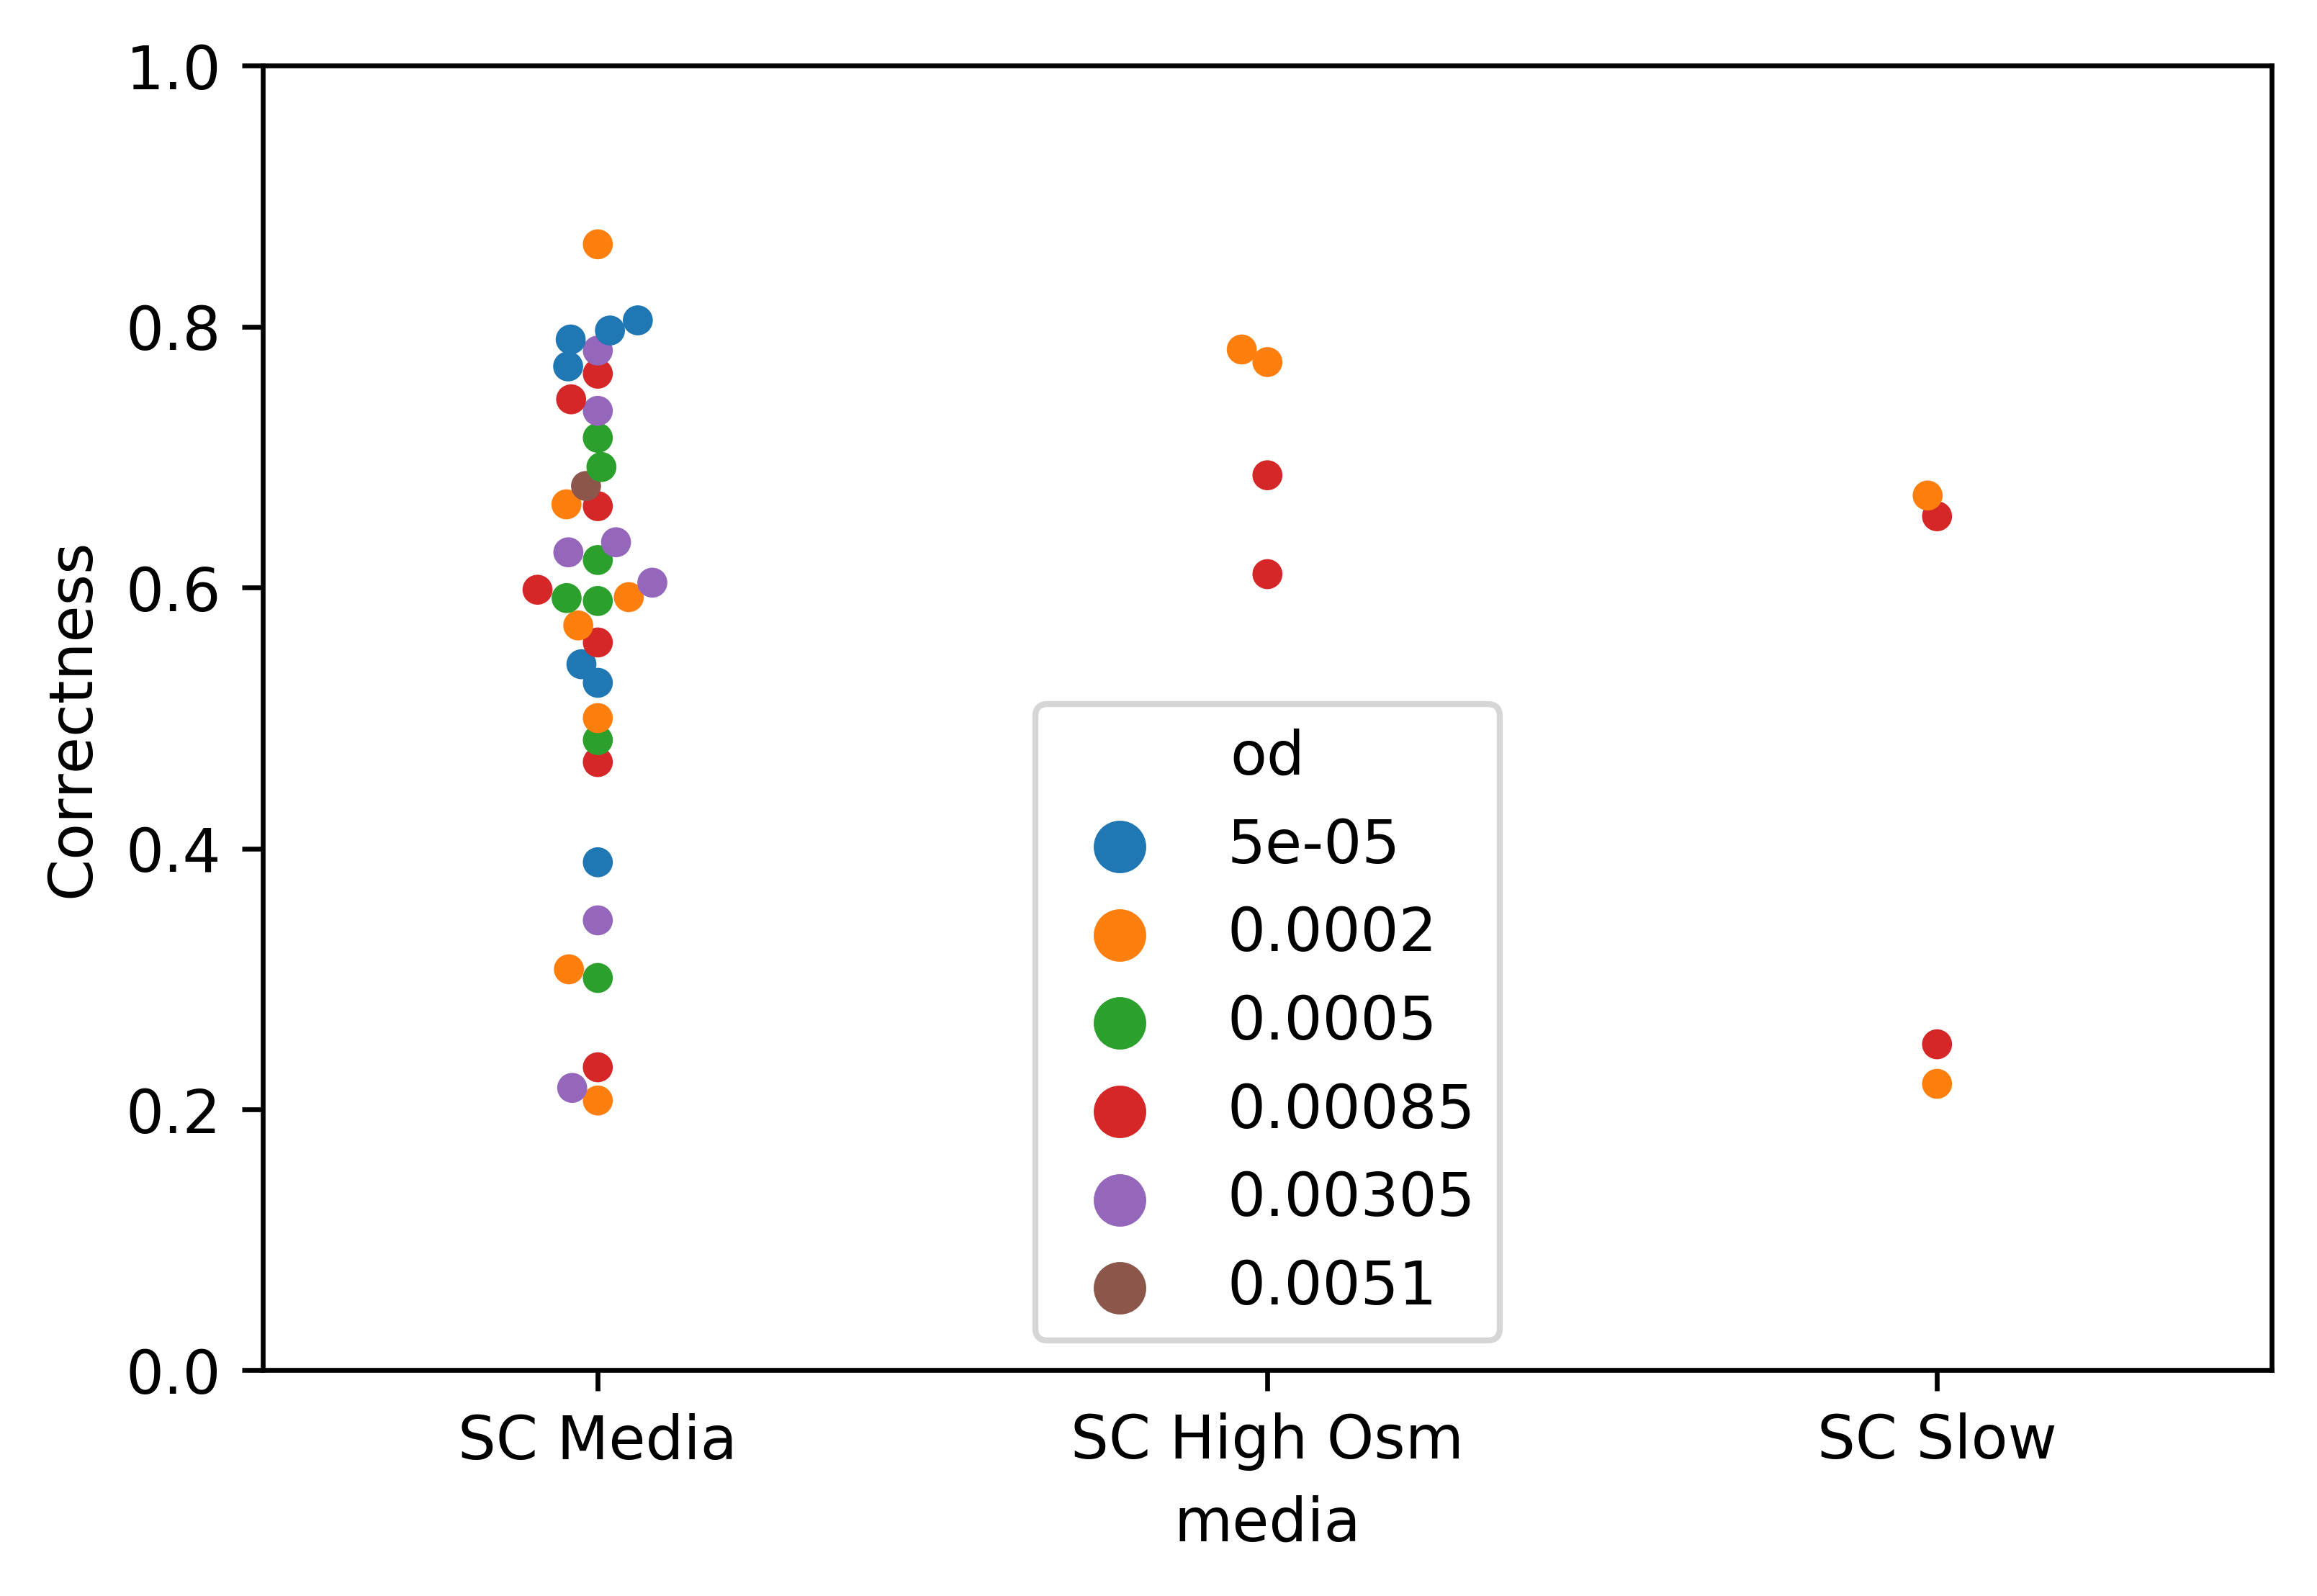

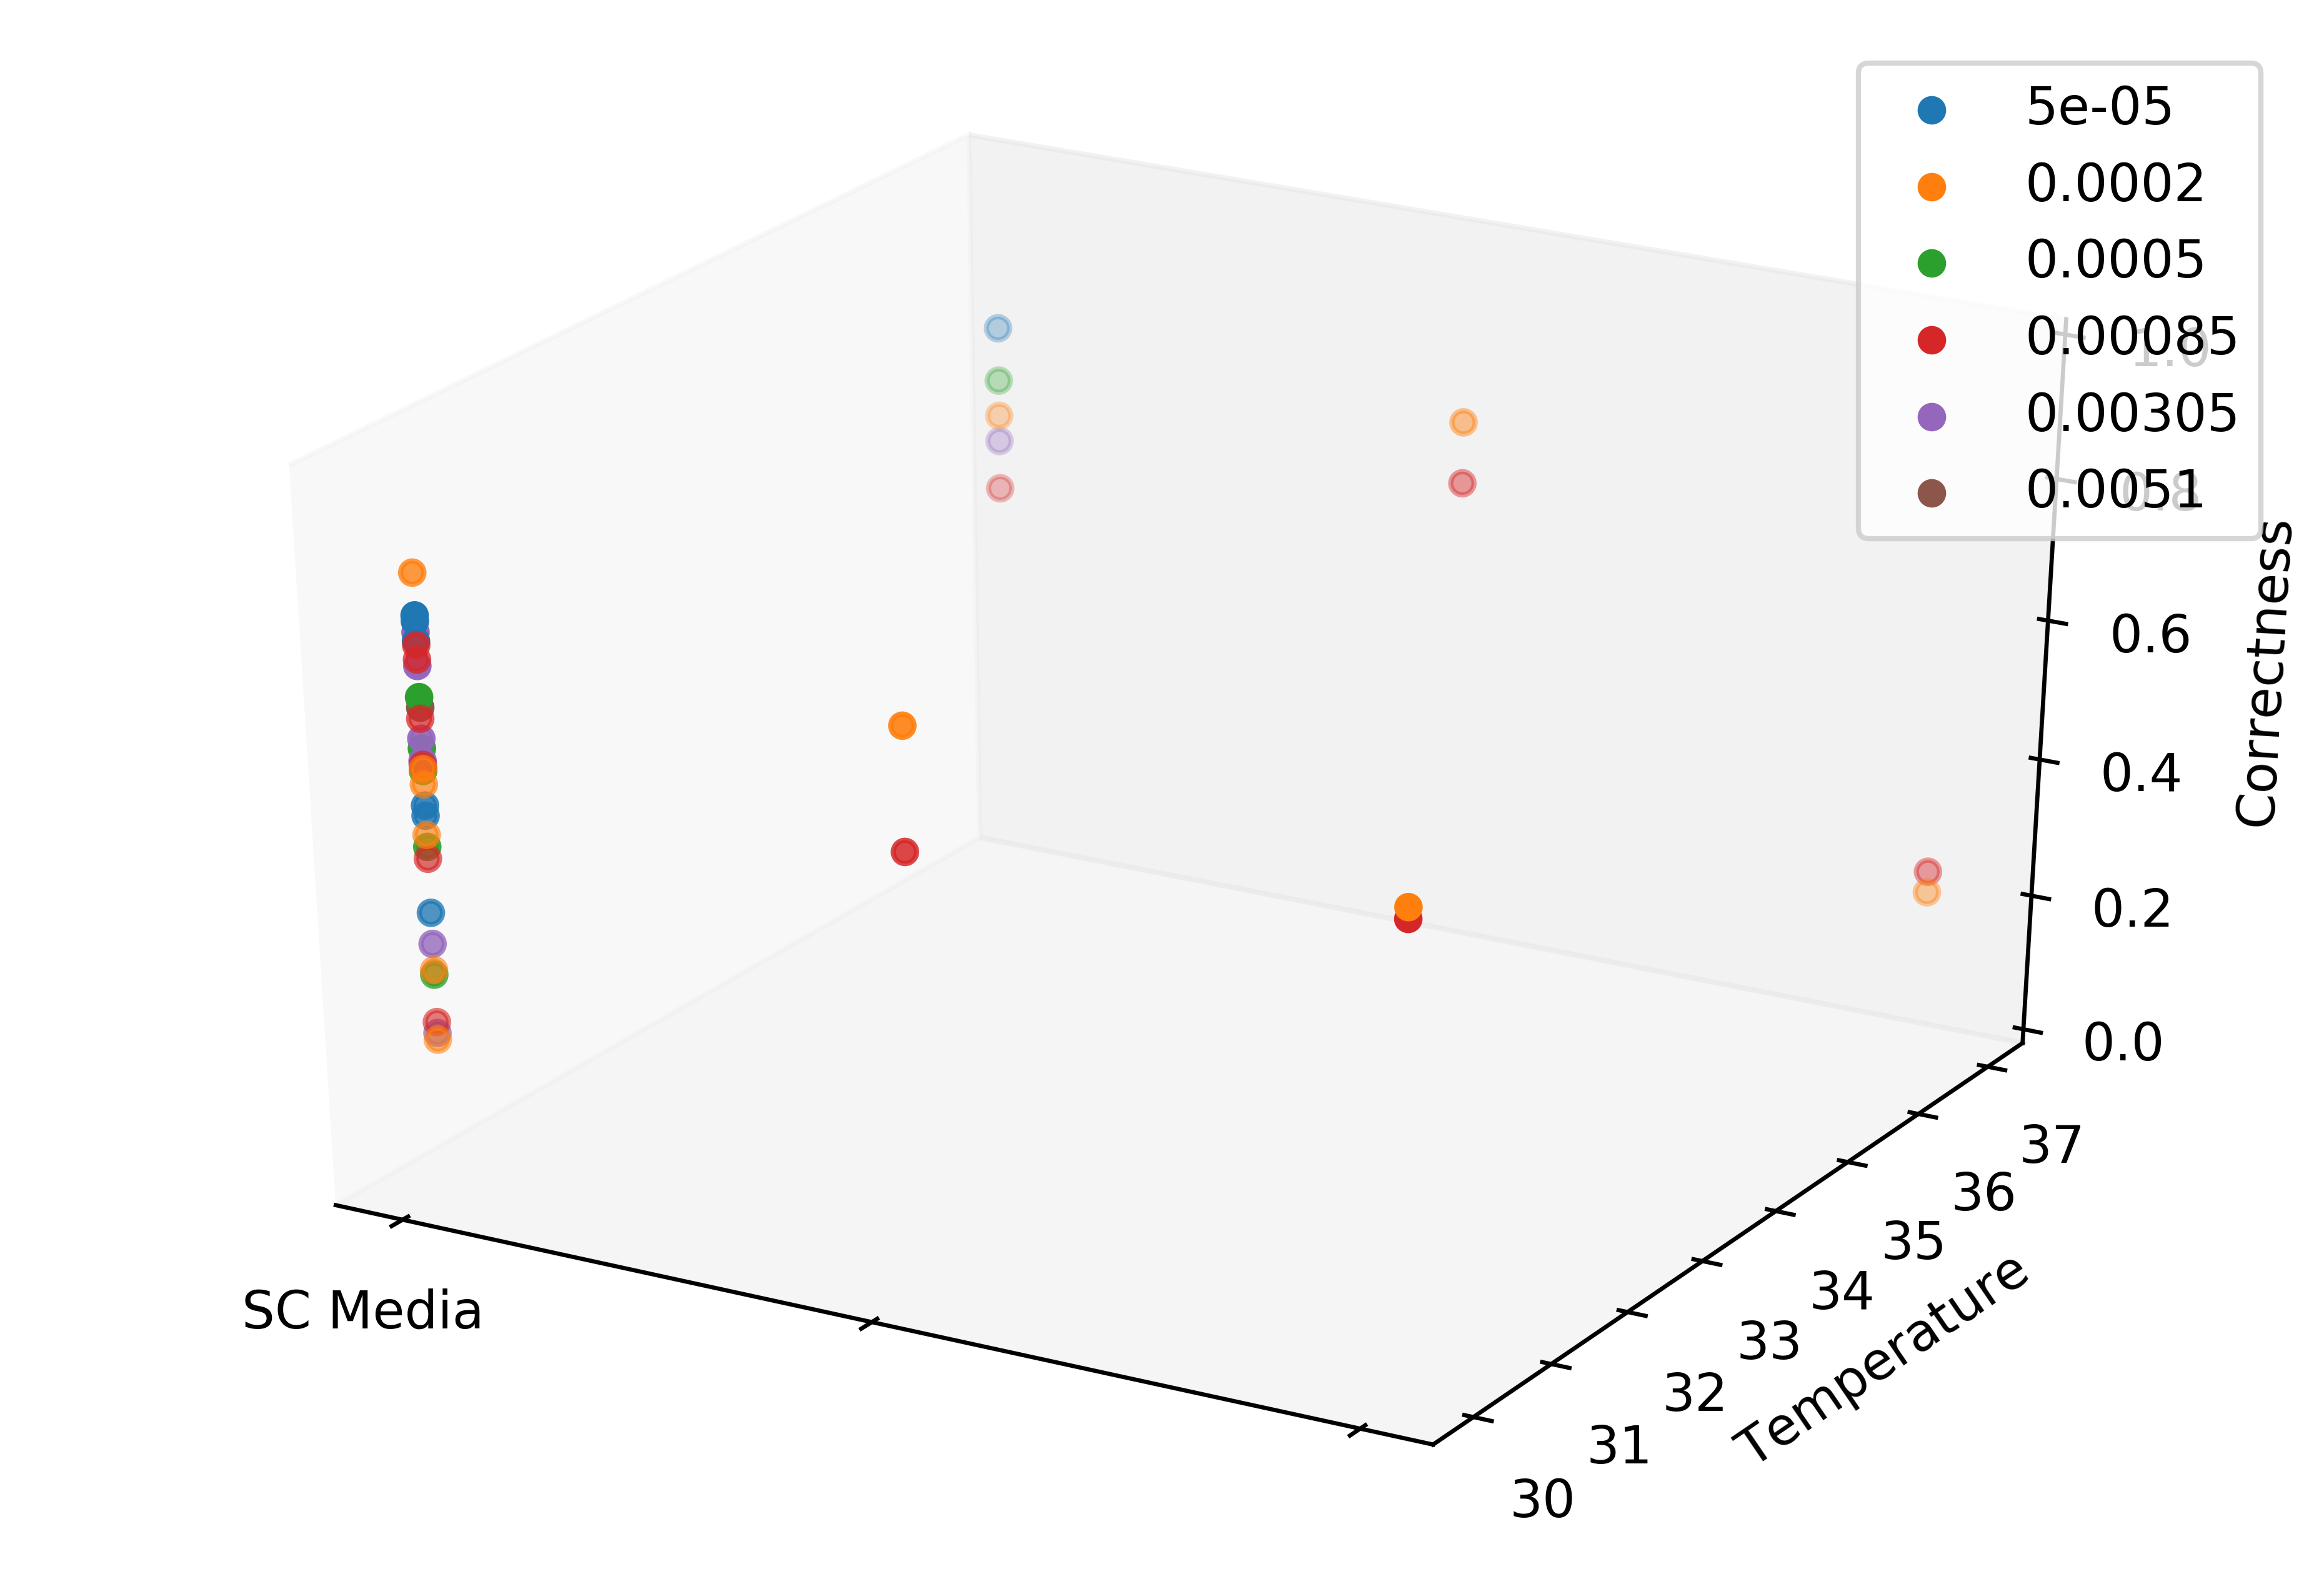

In [6]:
make_plot("AND")
make_plot_od("AND")
make_3D_plot("AND")

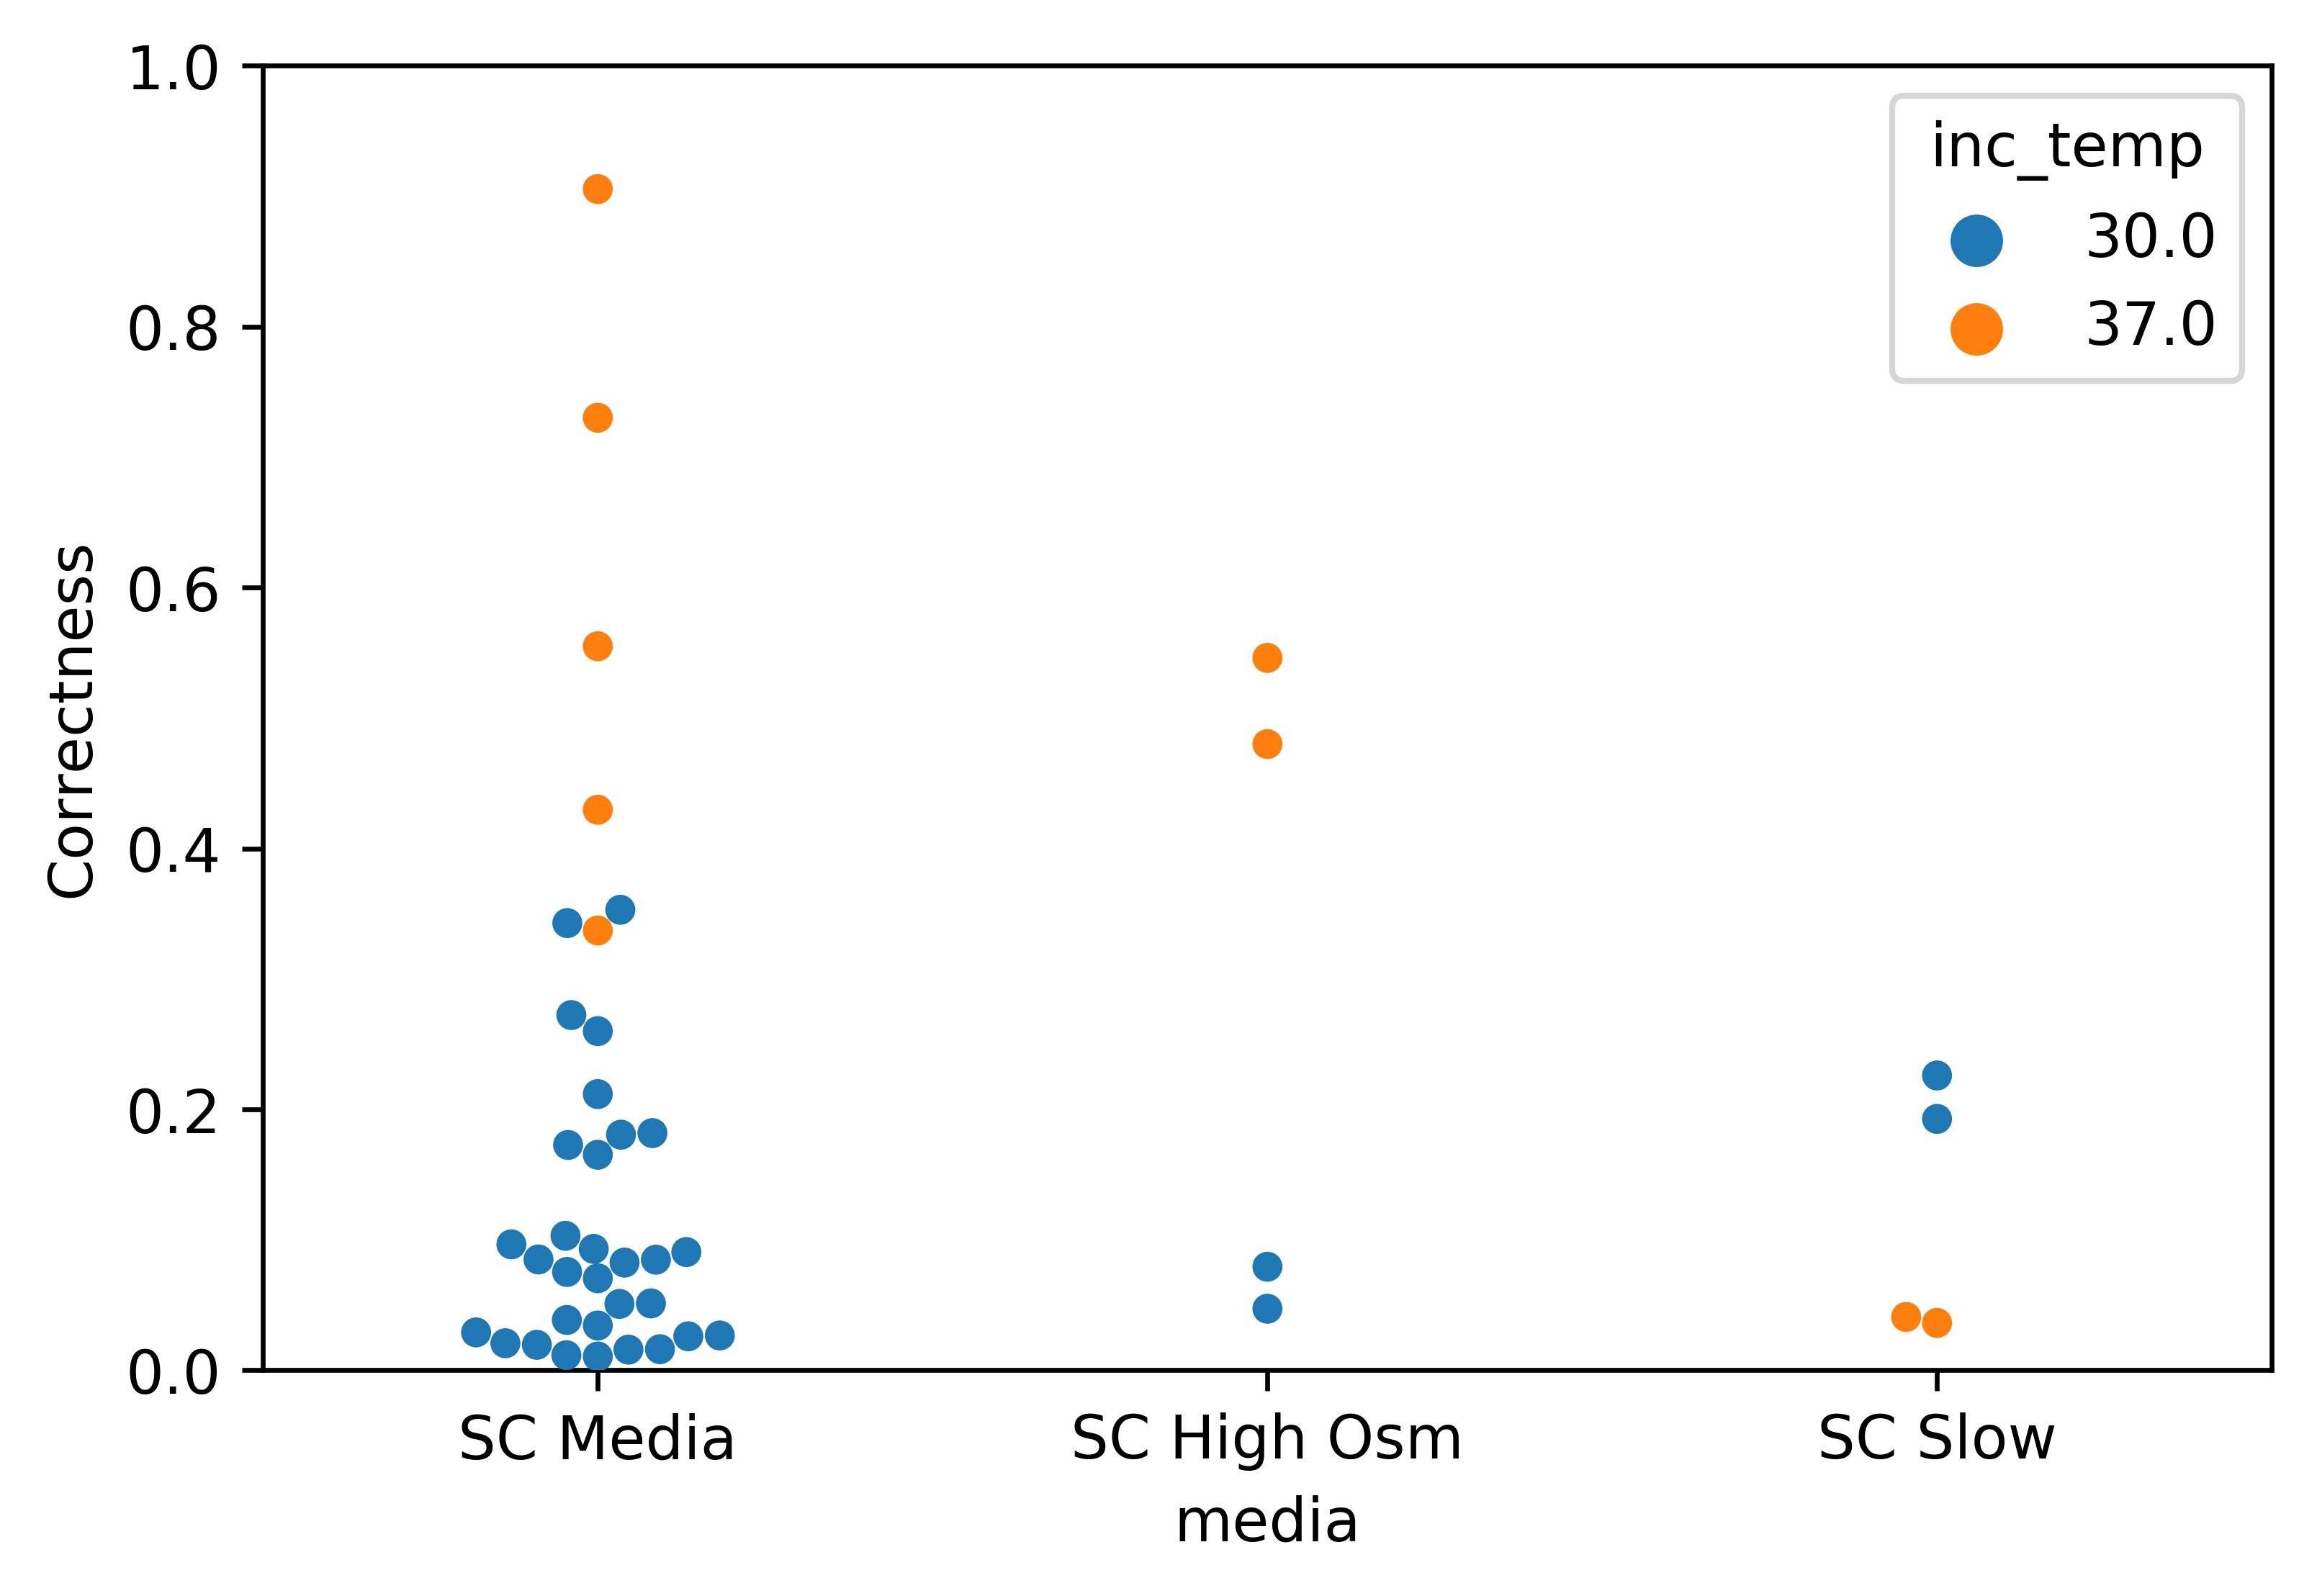

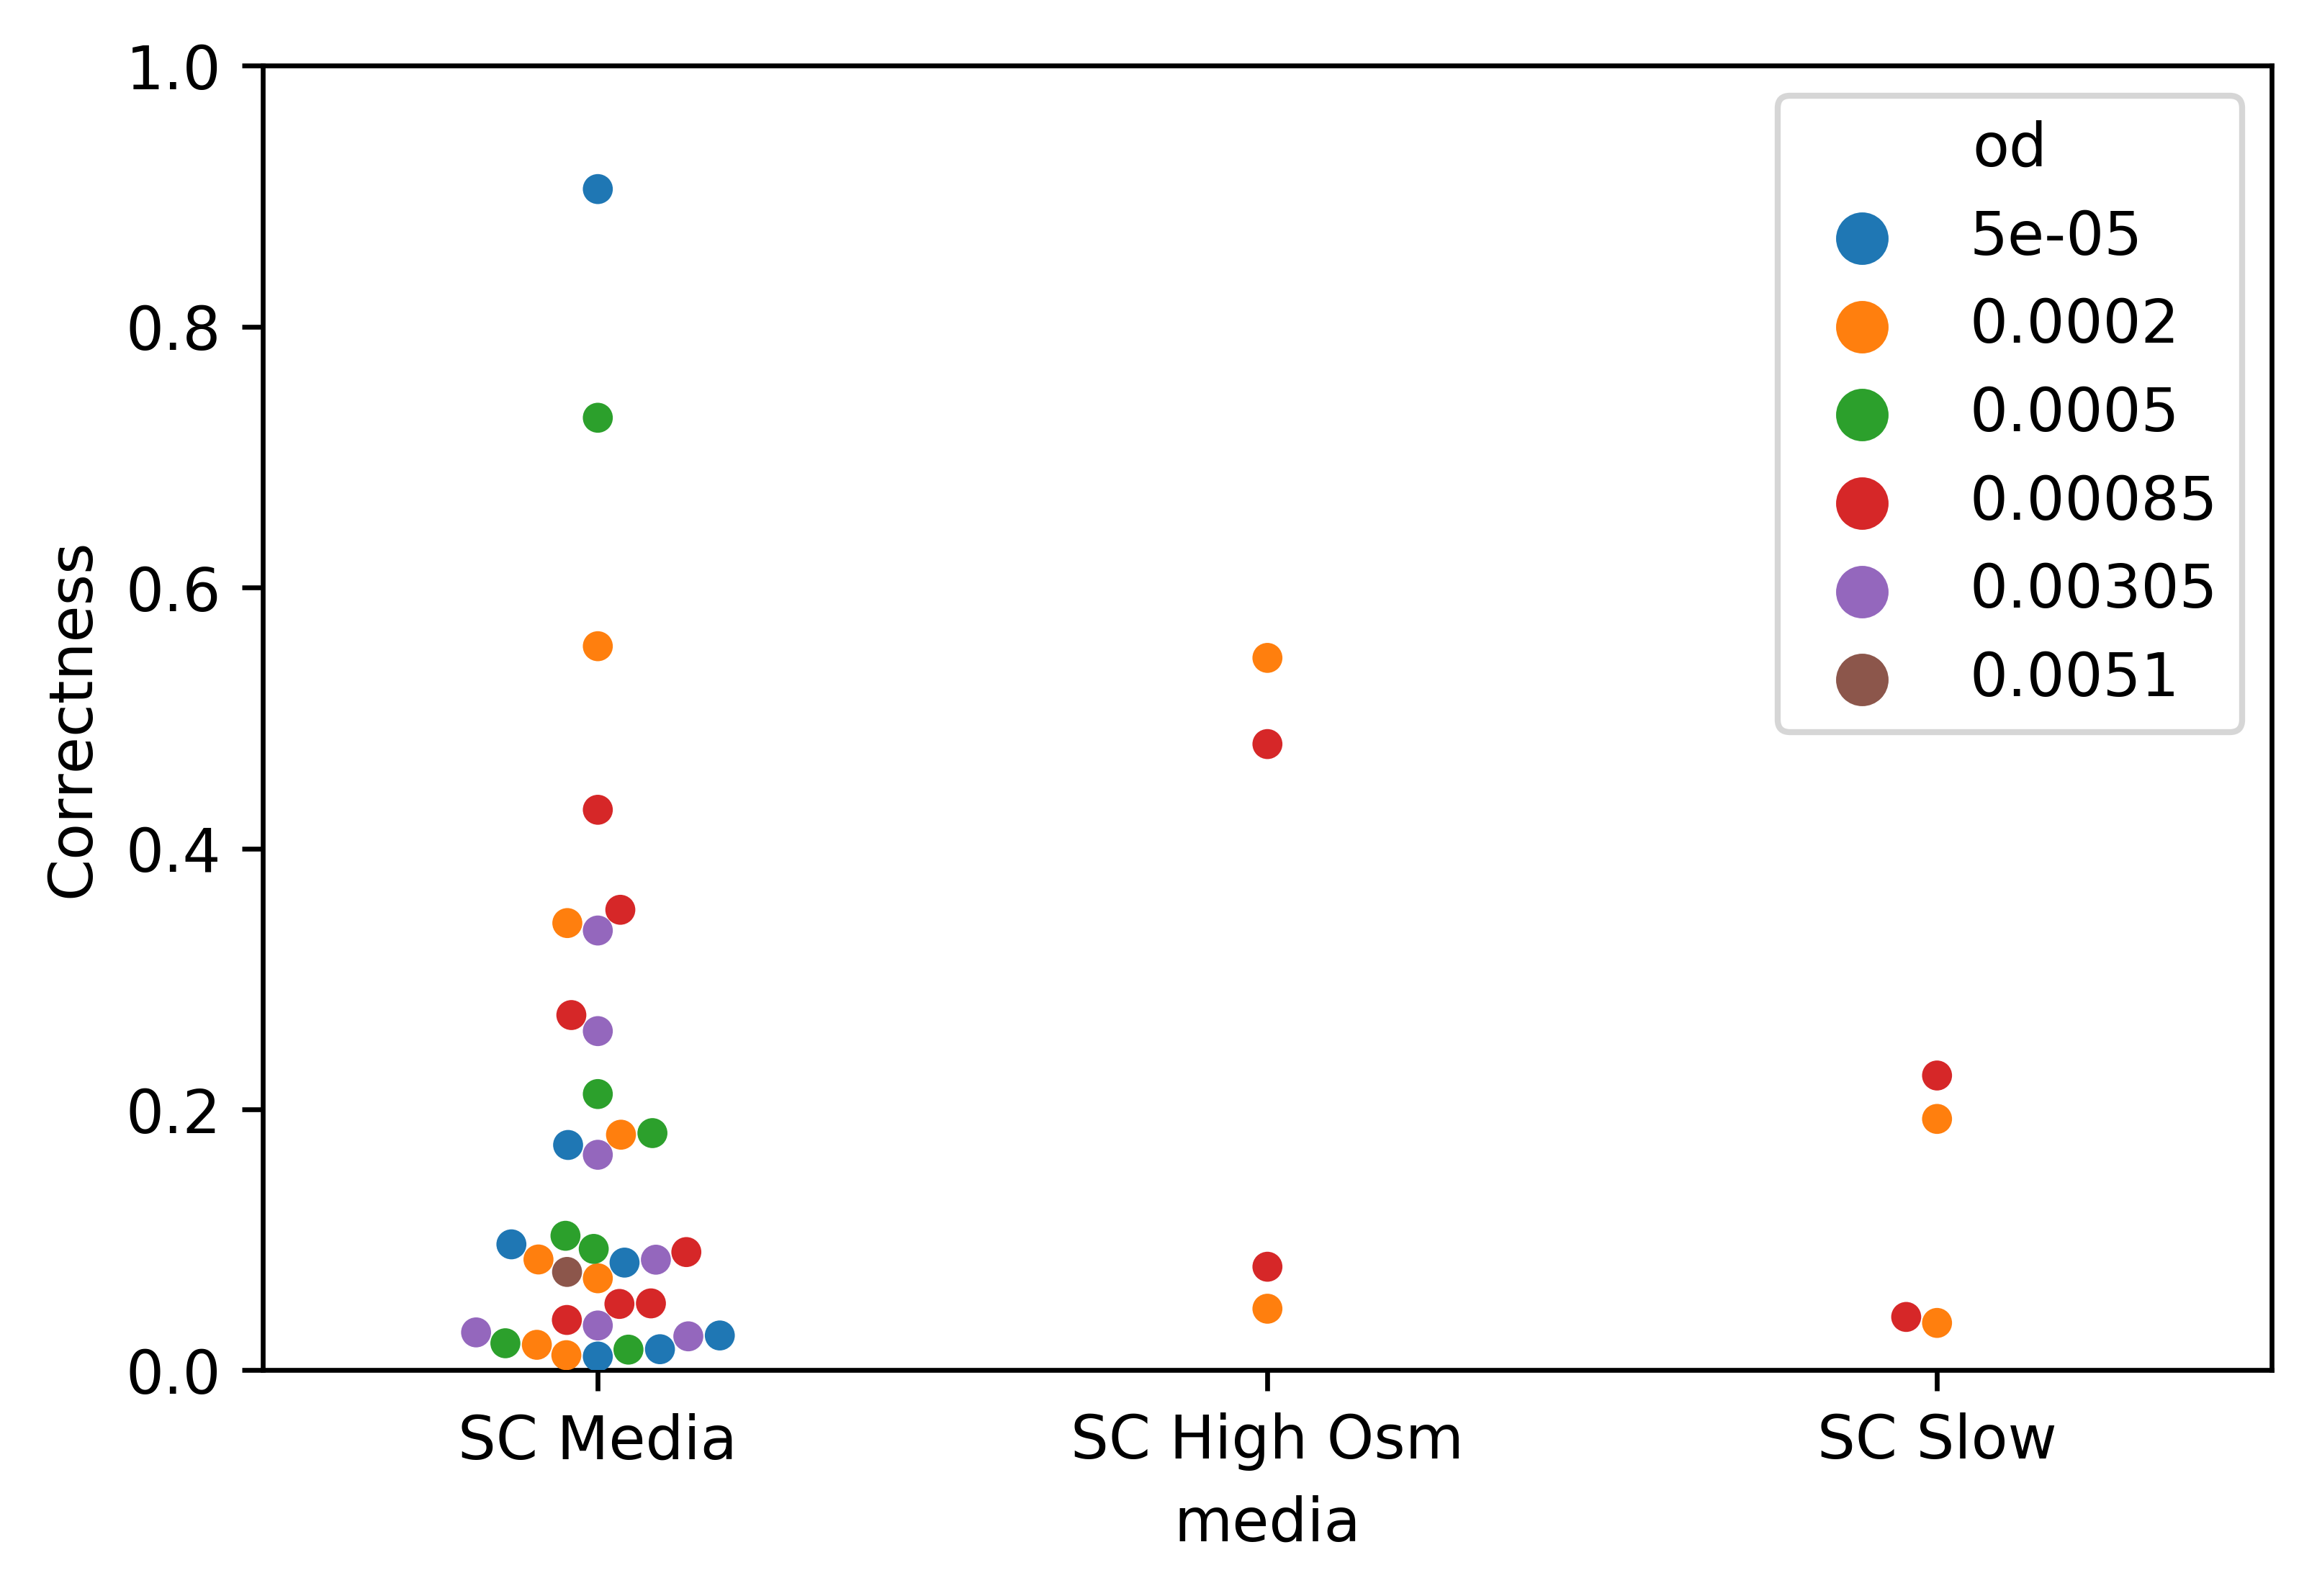

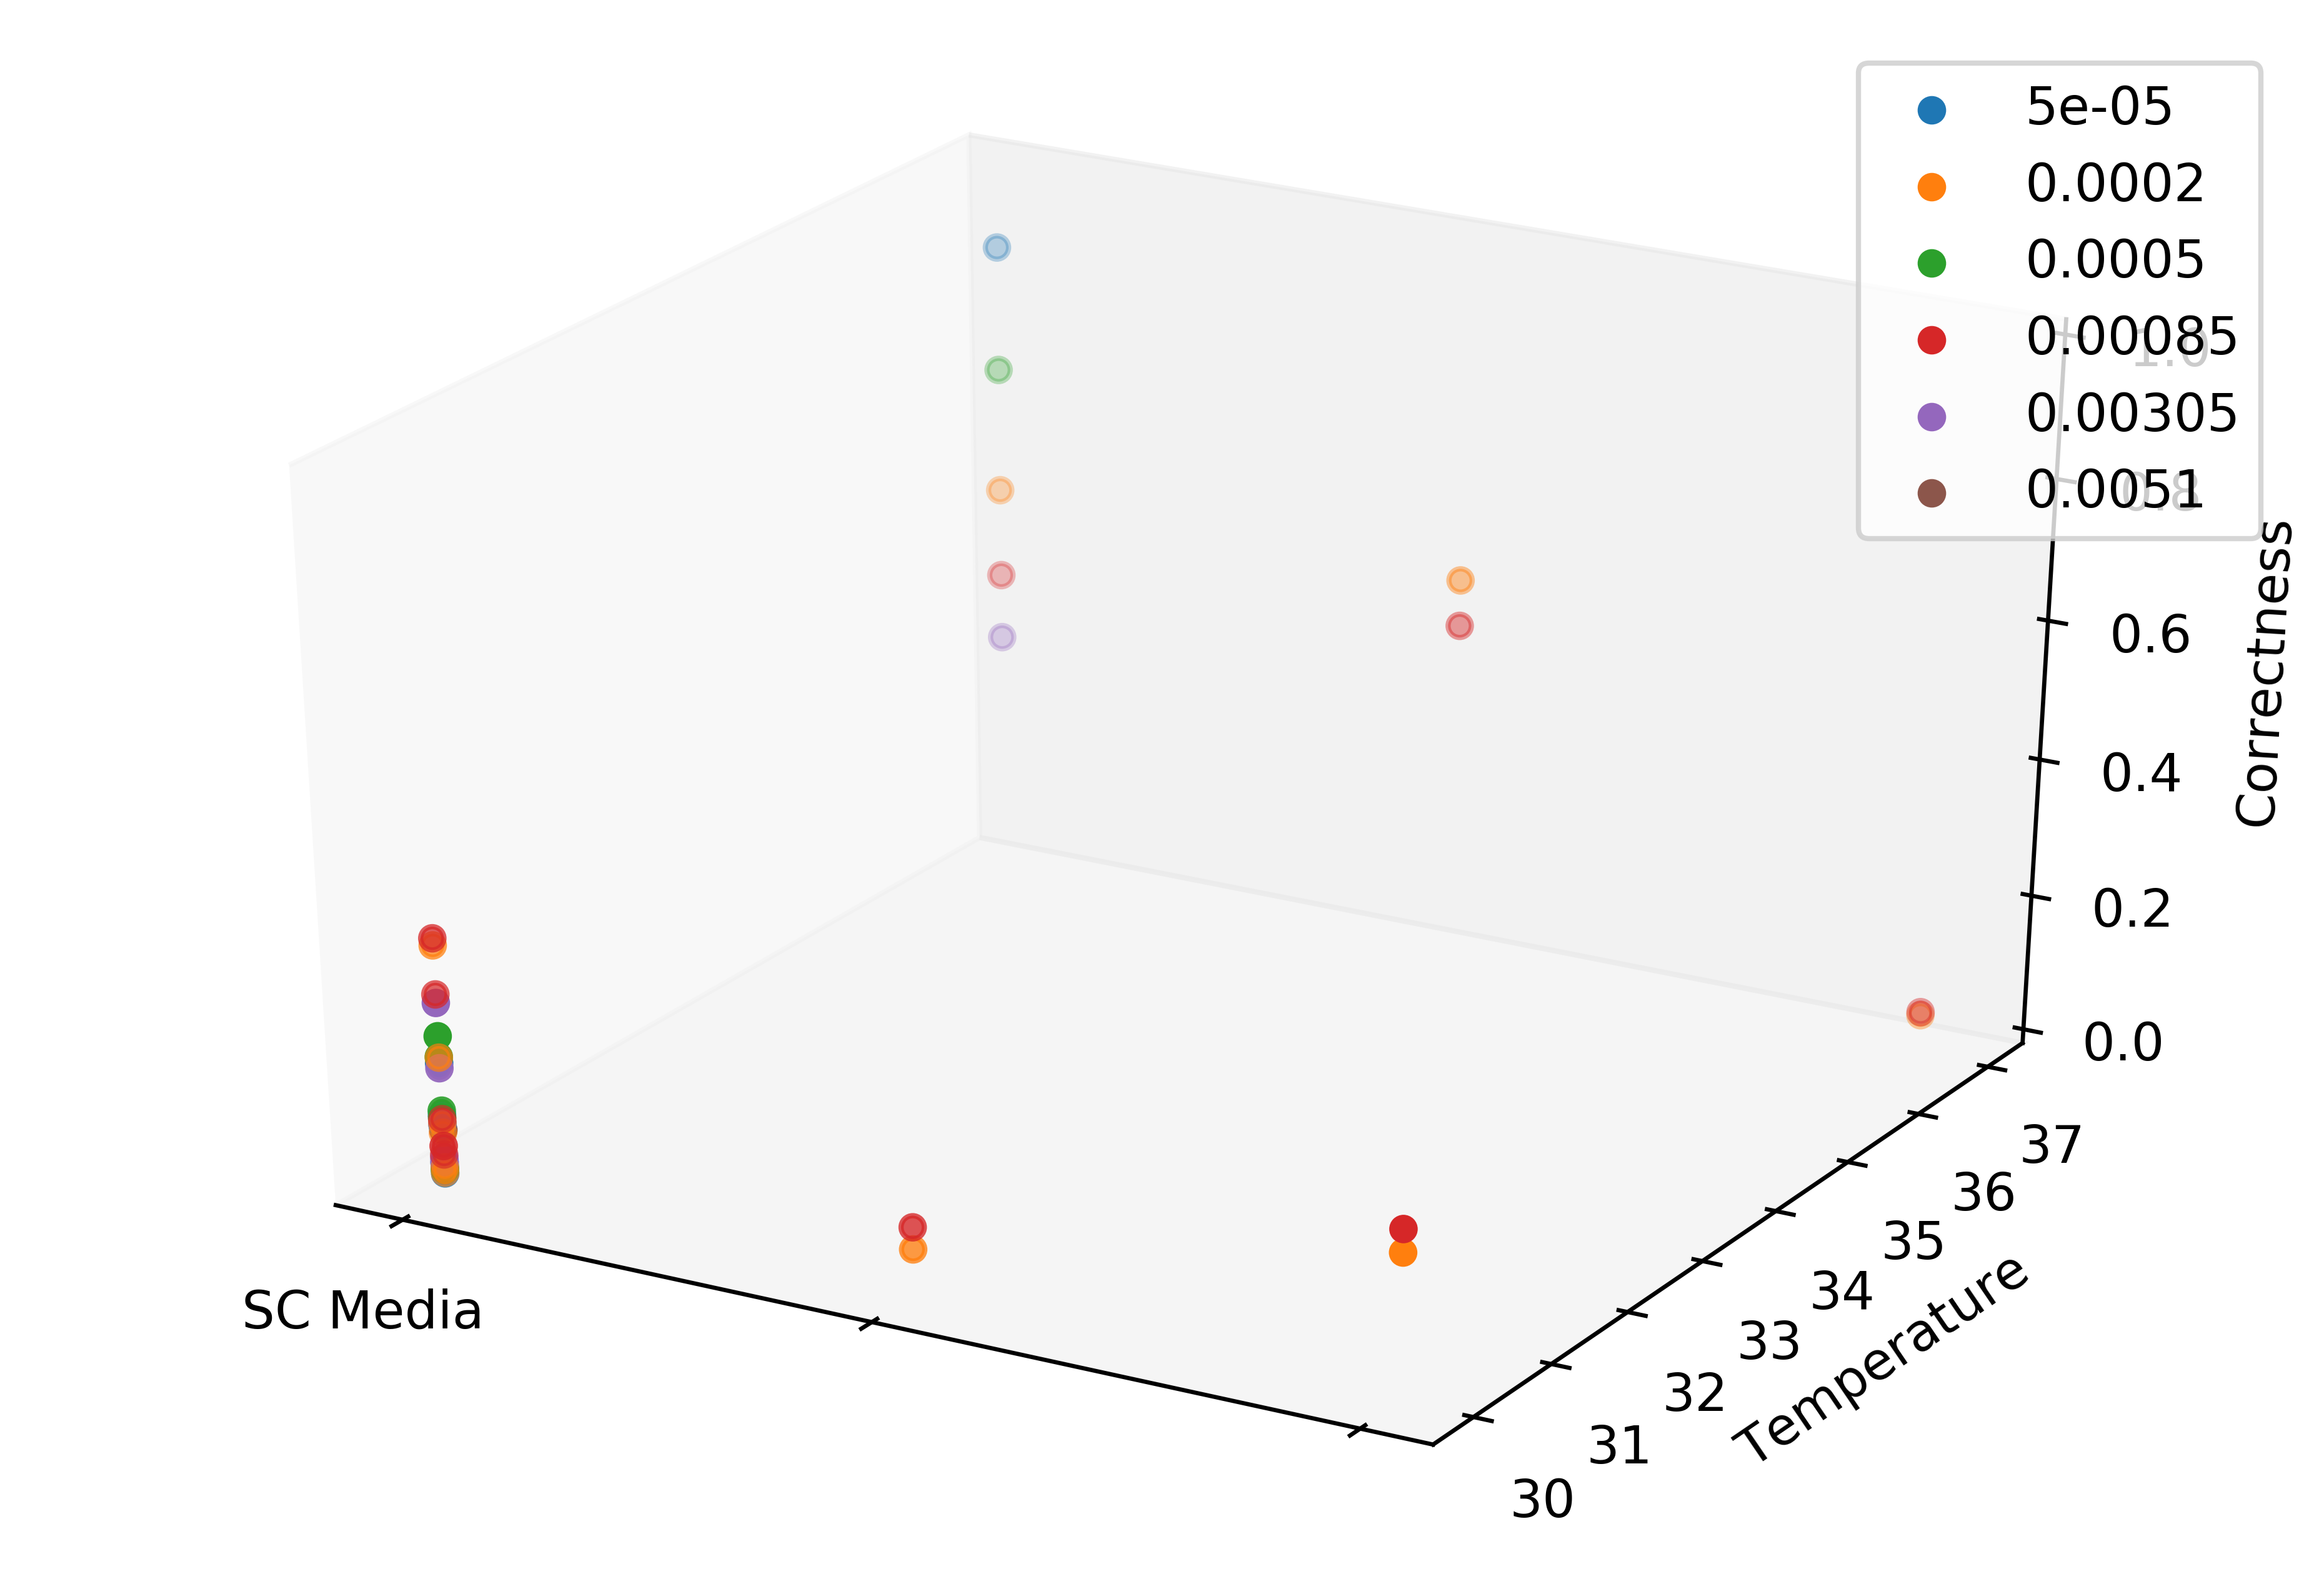

In [7]:
make_plot("NAND")
make_plot_od("NAND")
make_3D_plot("NAND")

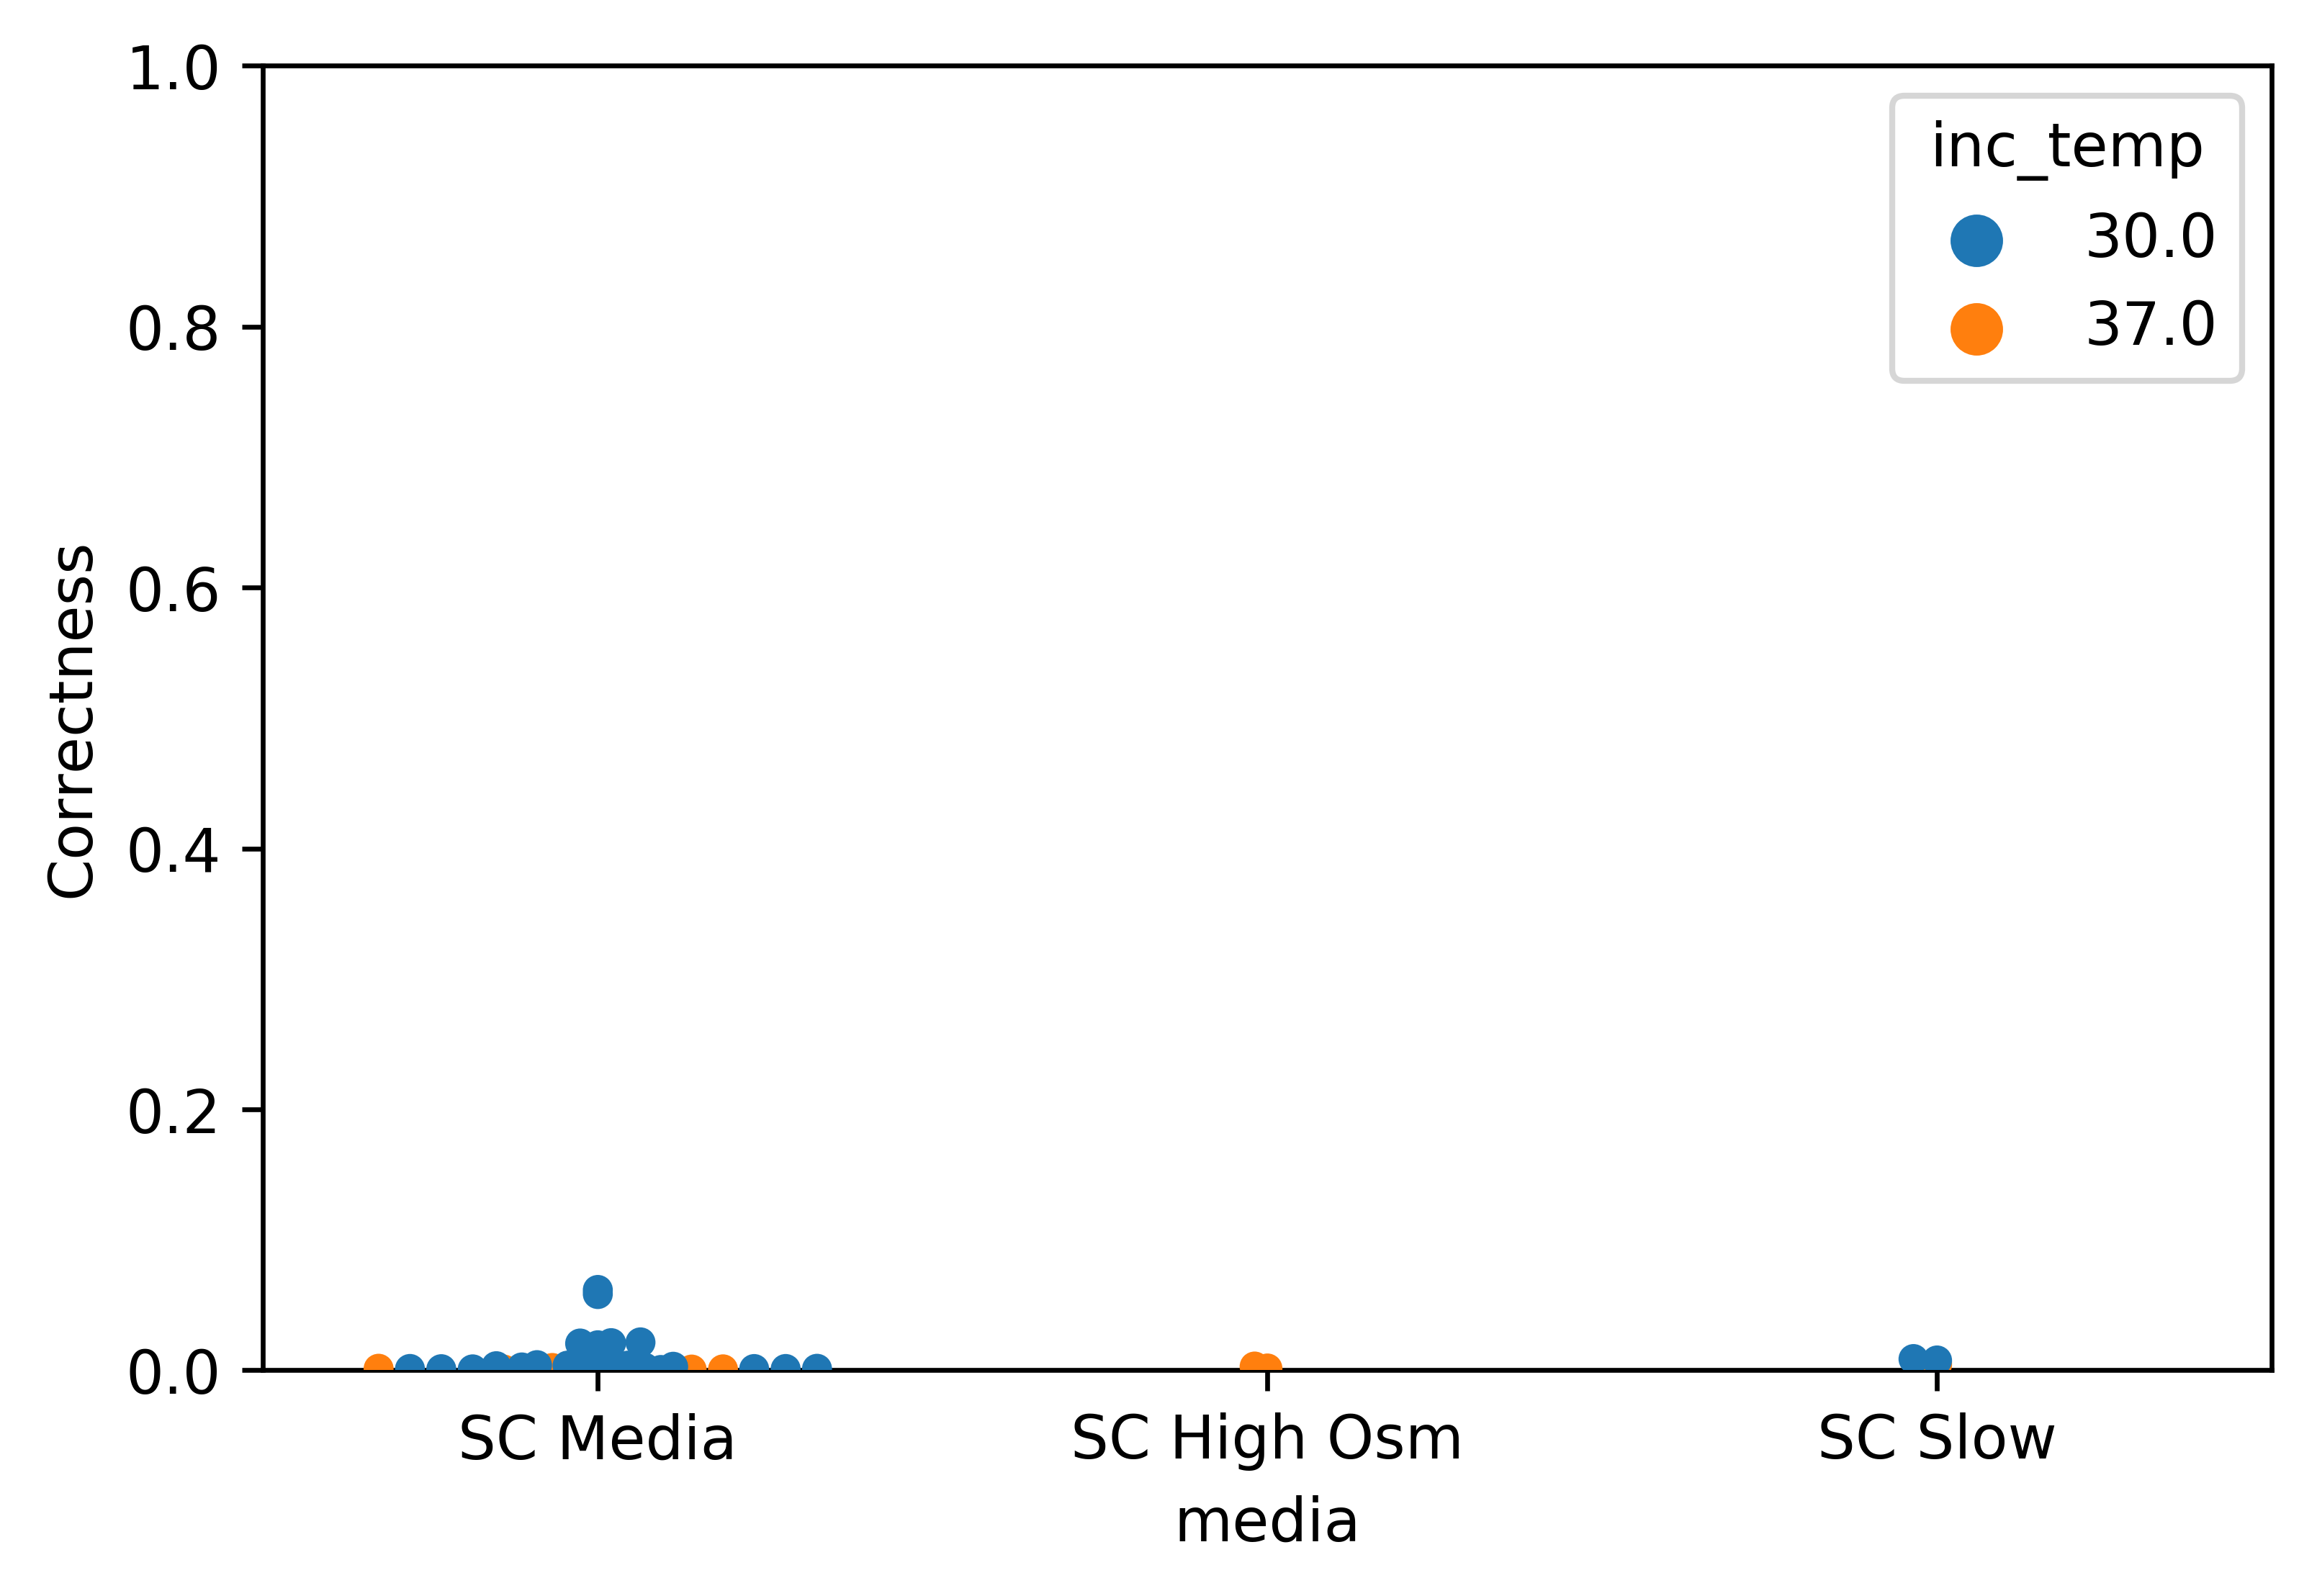

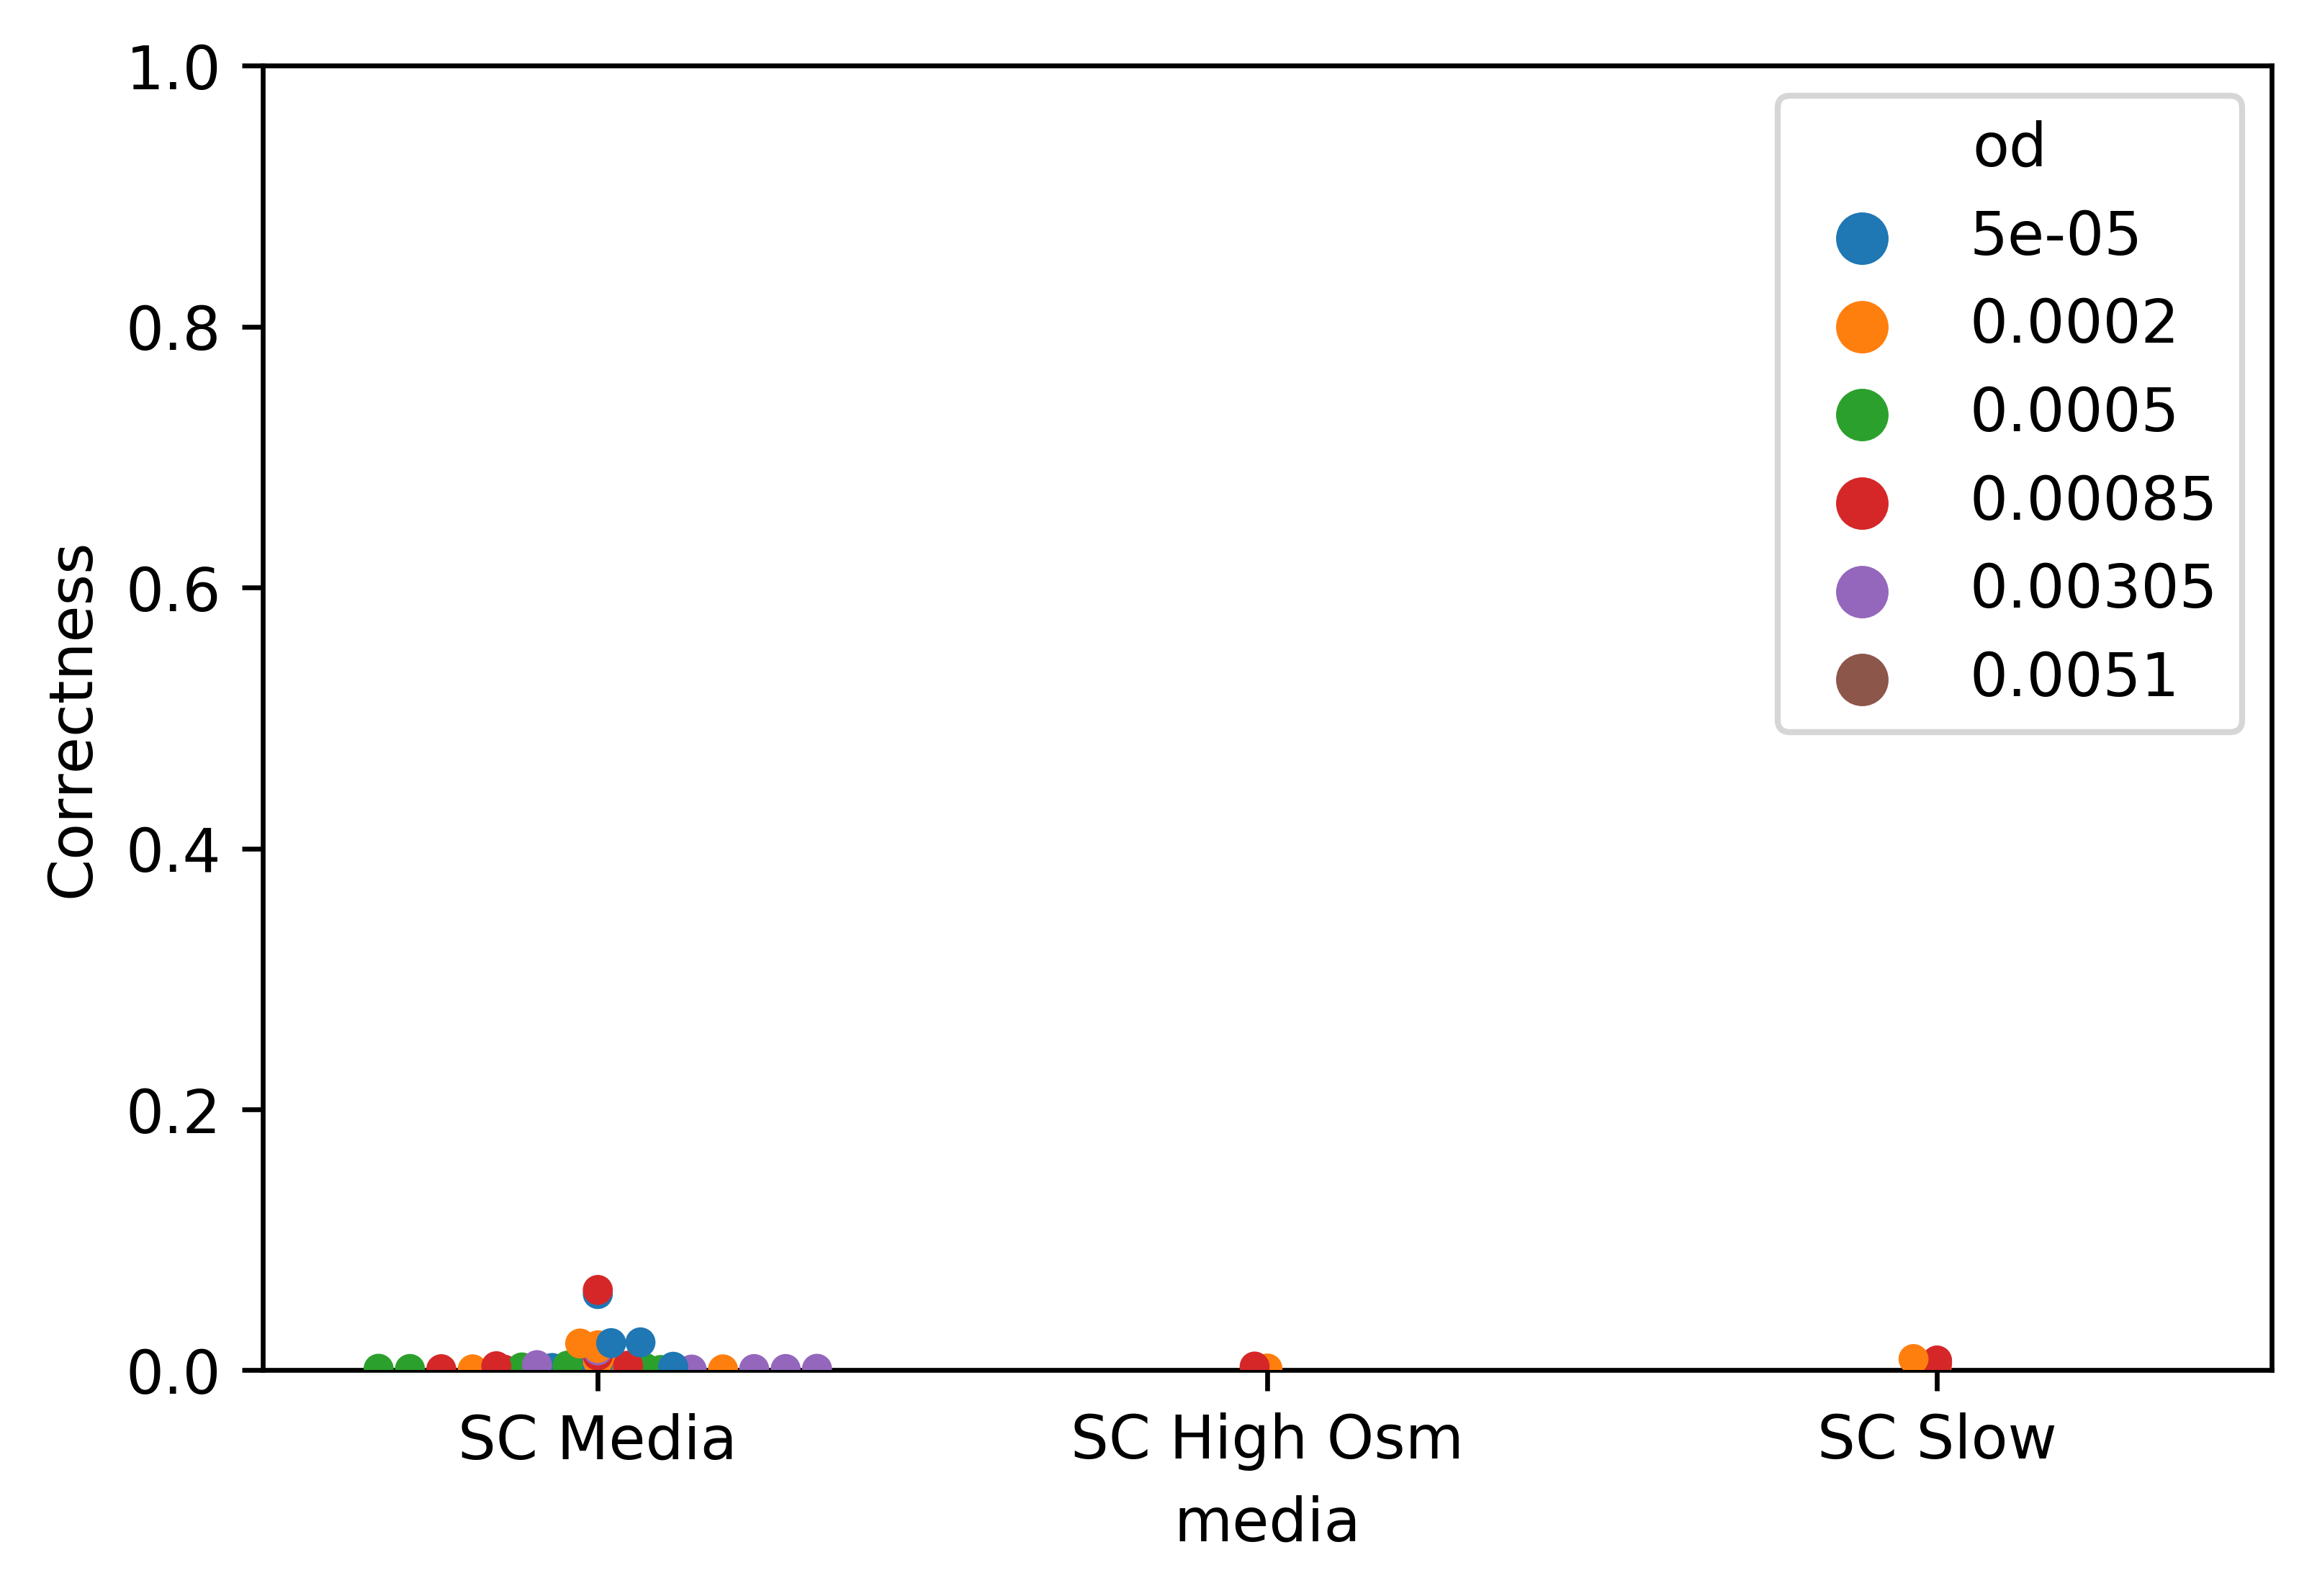

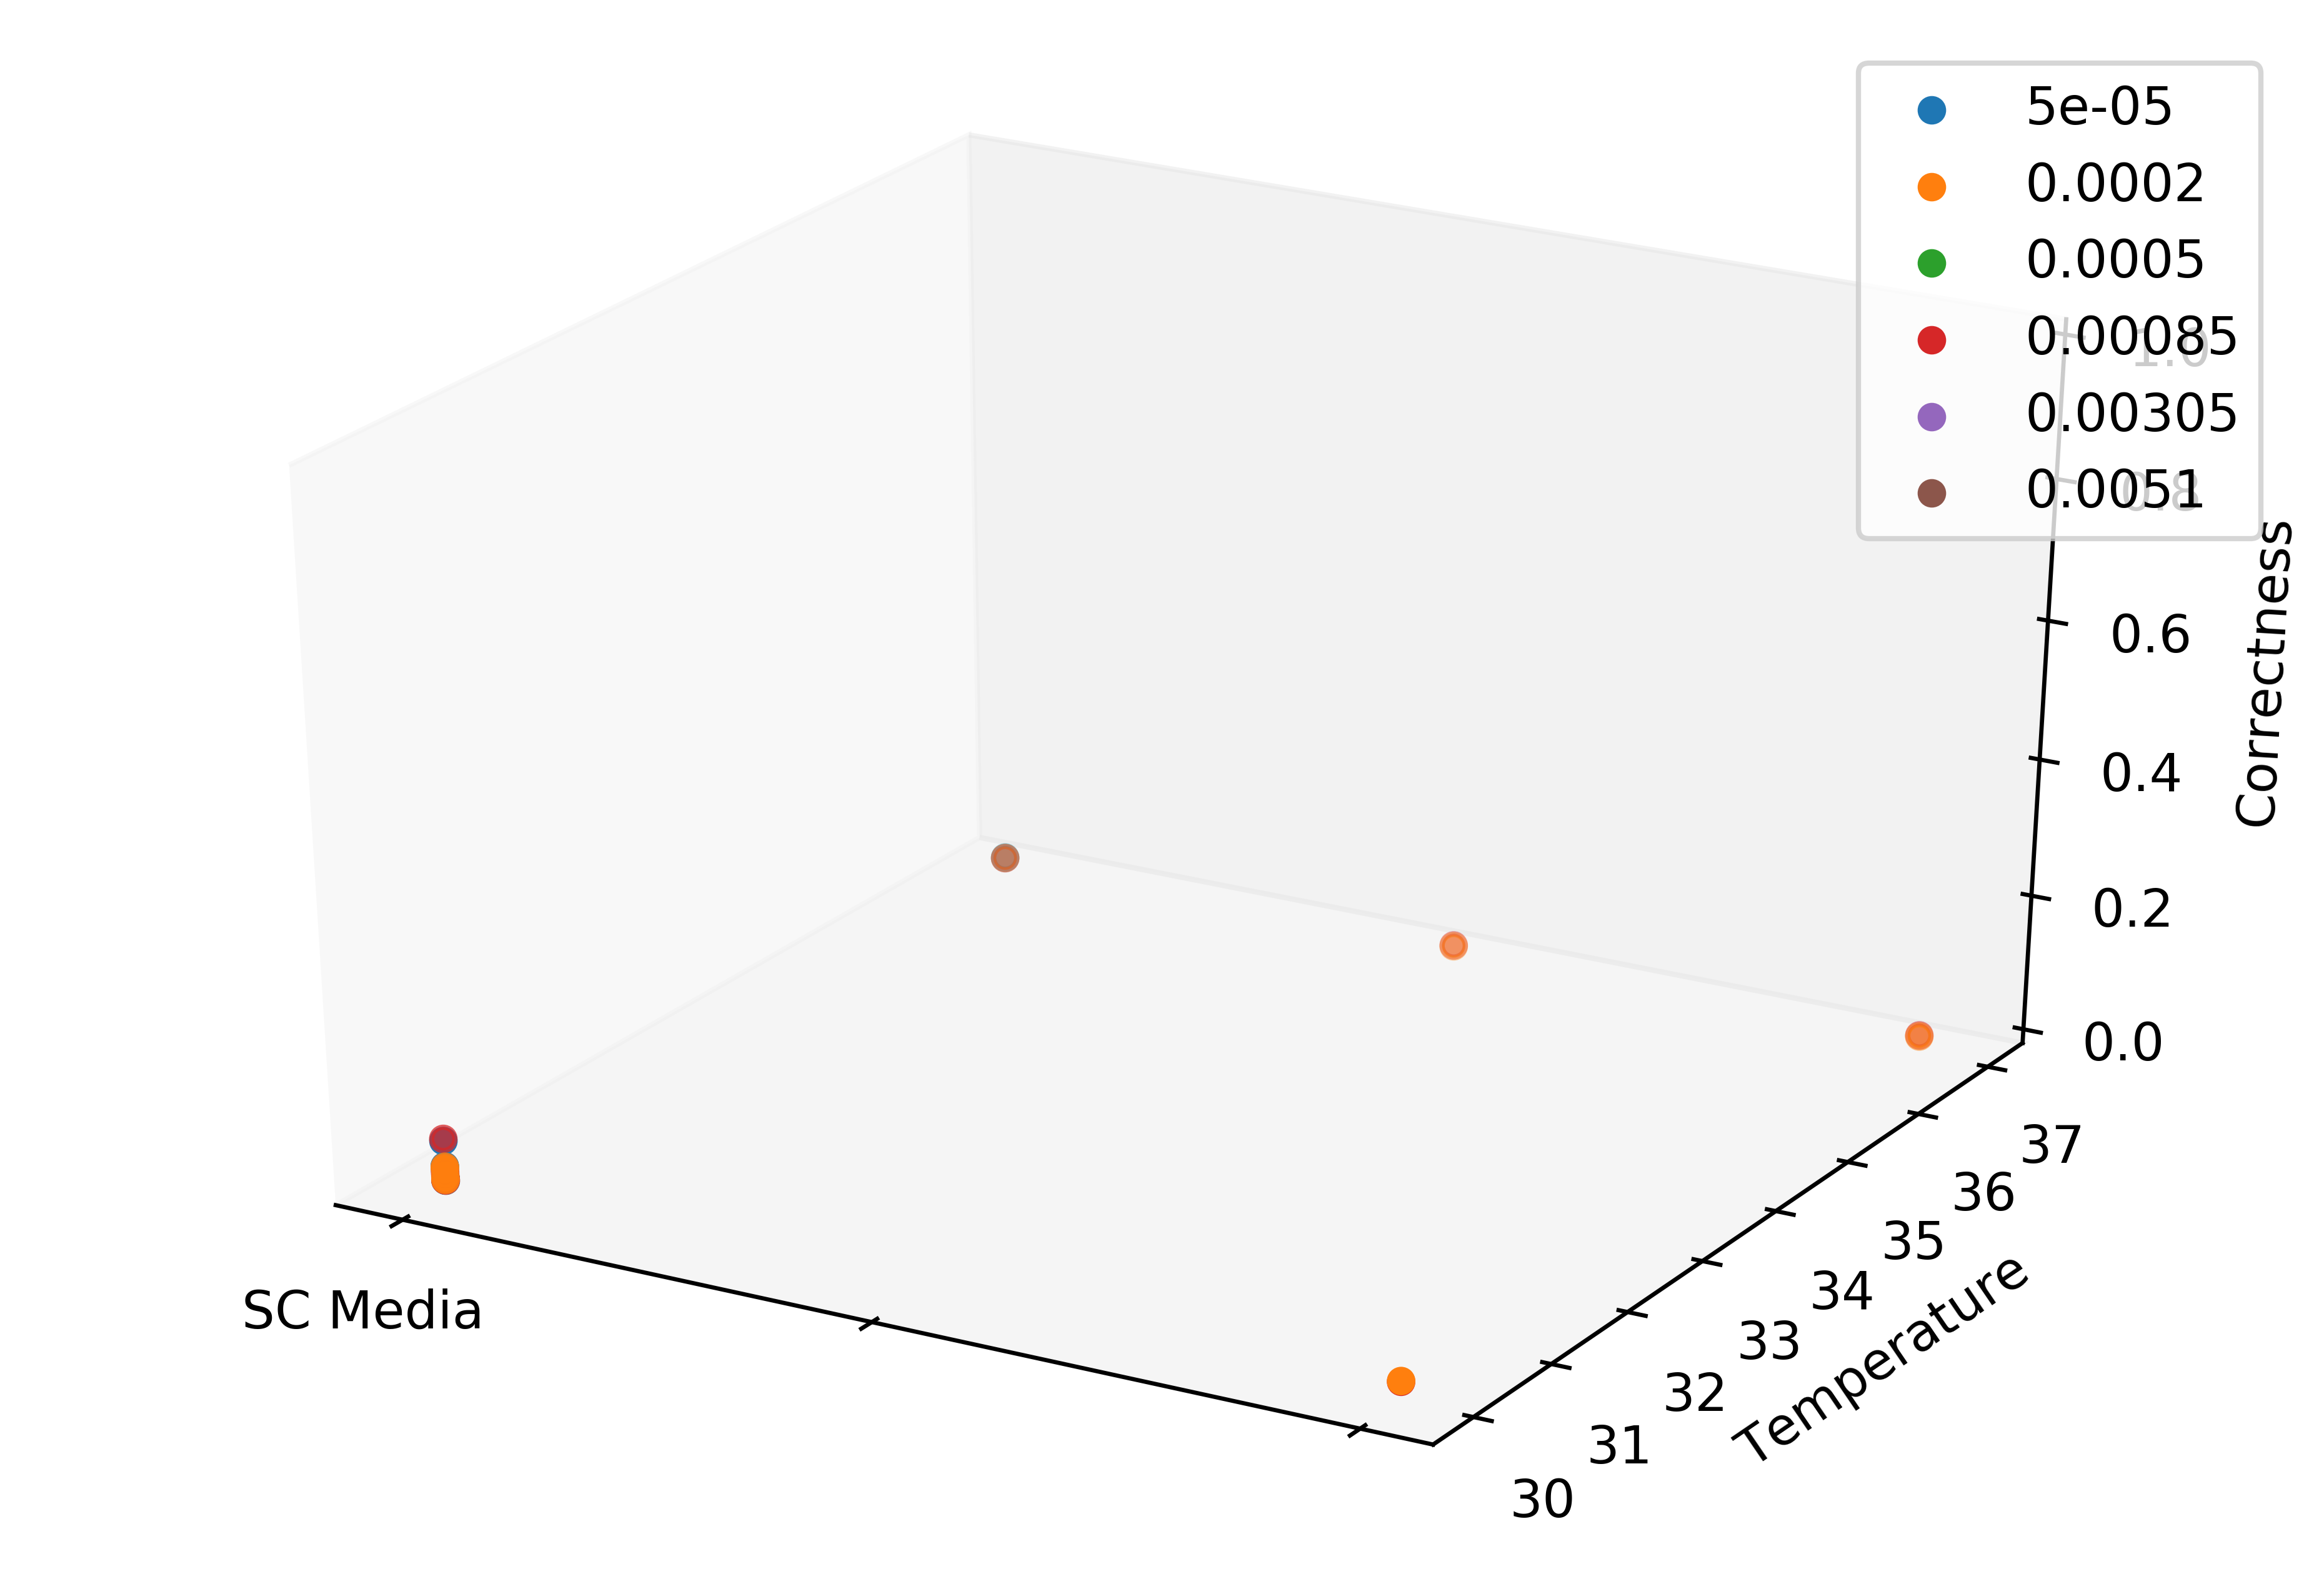

In [8]:
make_plot("OR")
make_plot_od("OR")
make_3D_plot("OR")

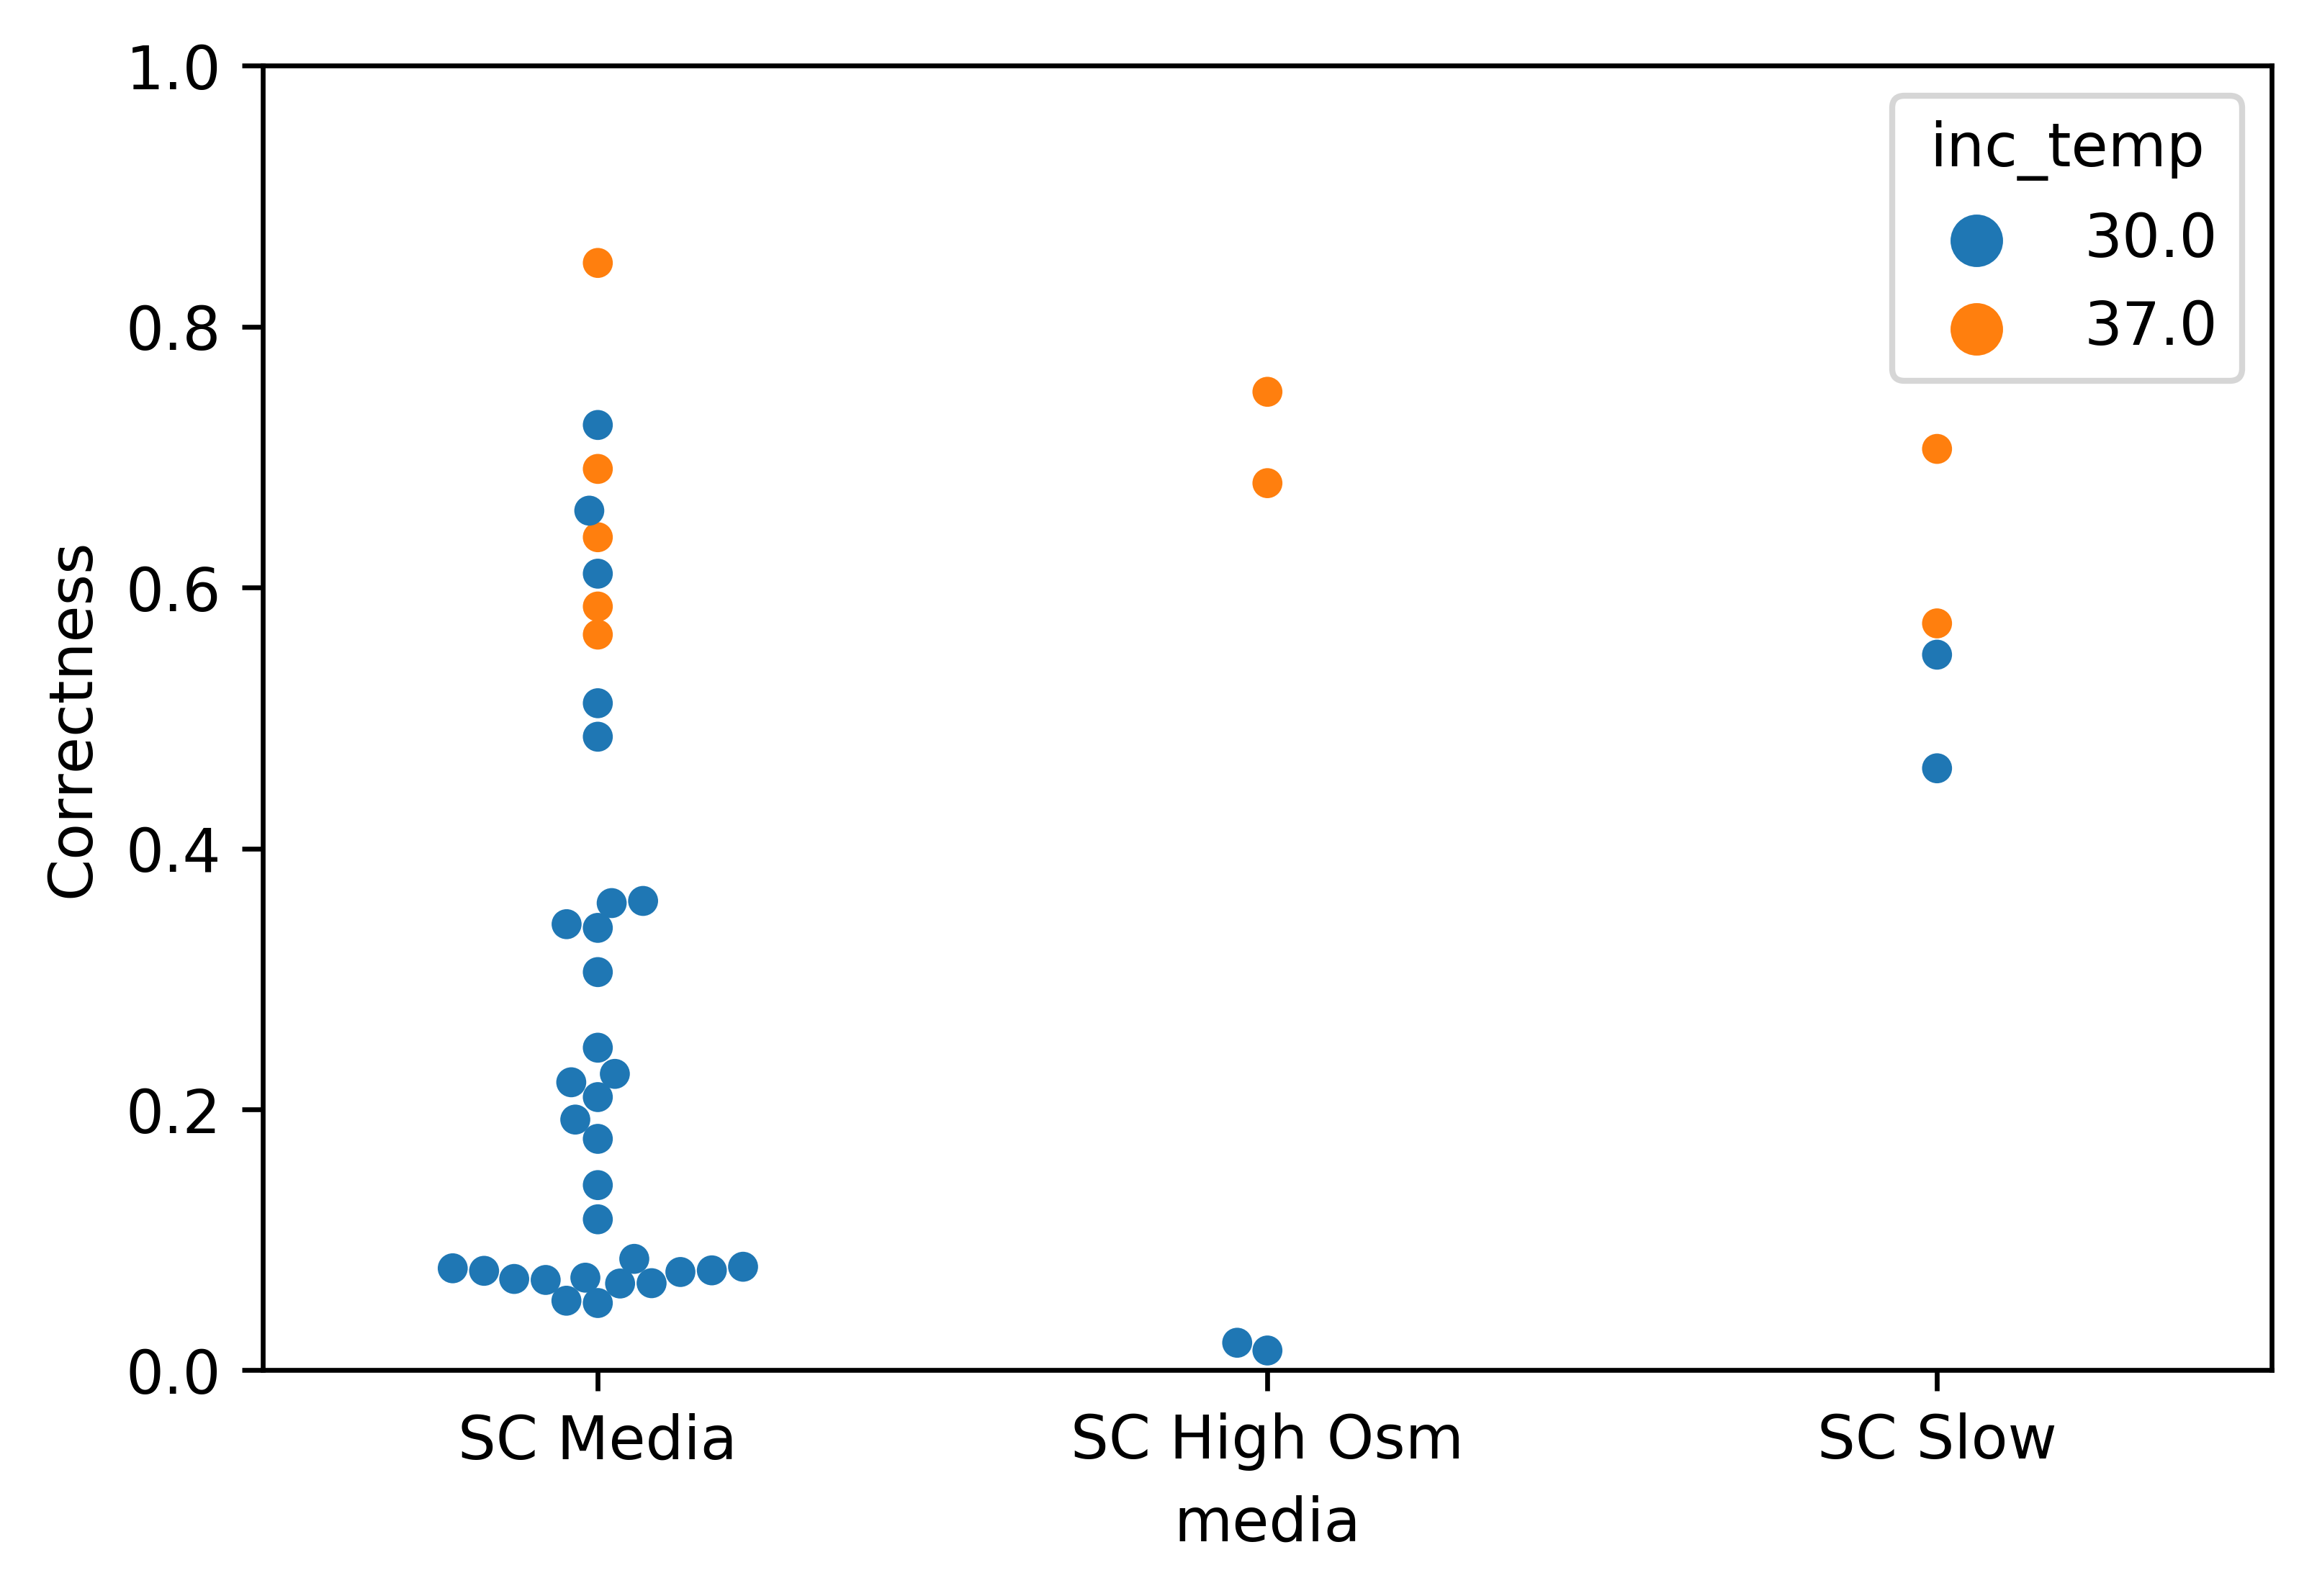

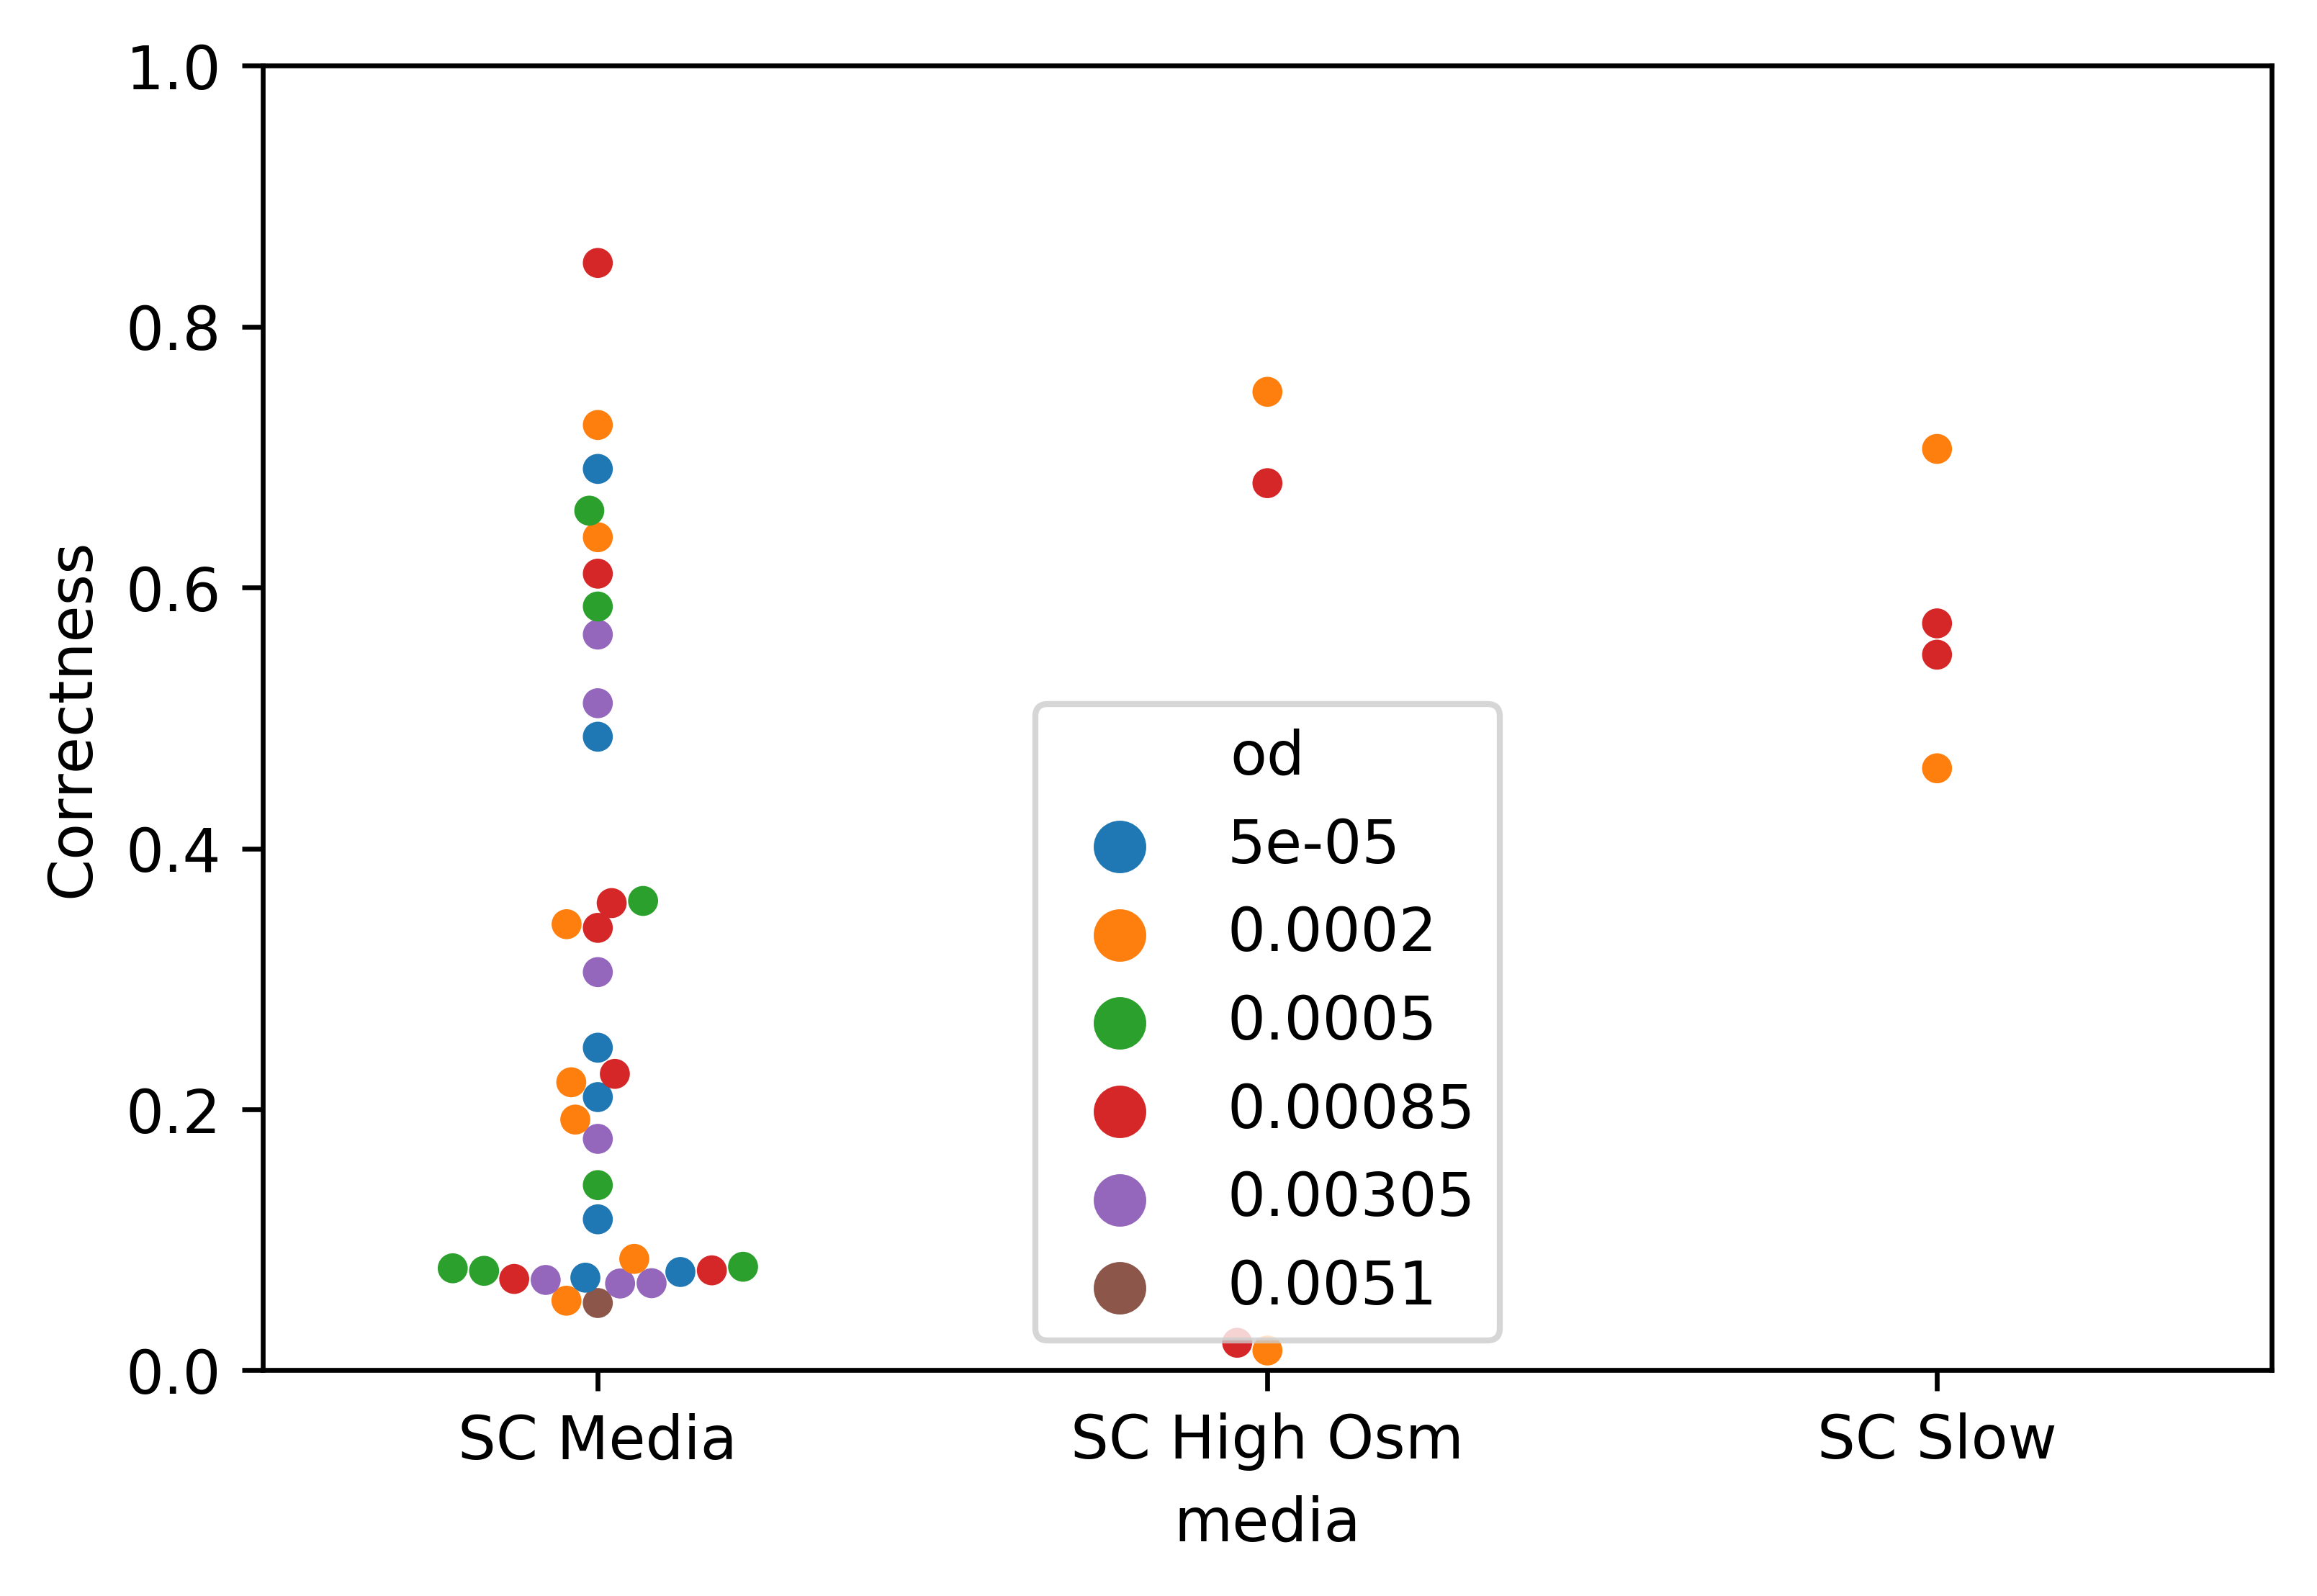

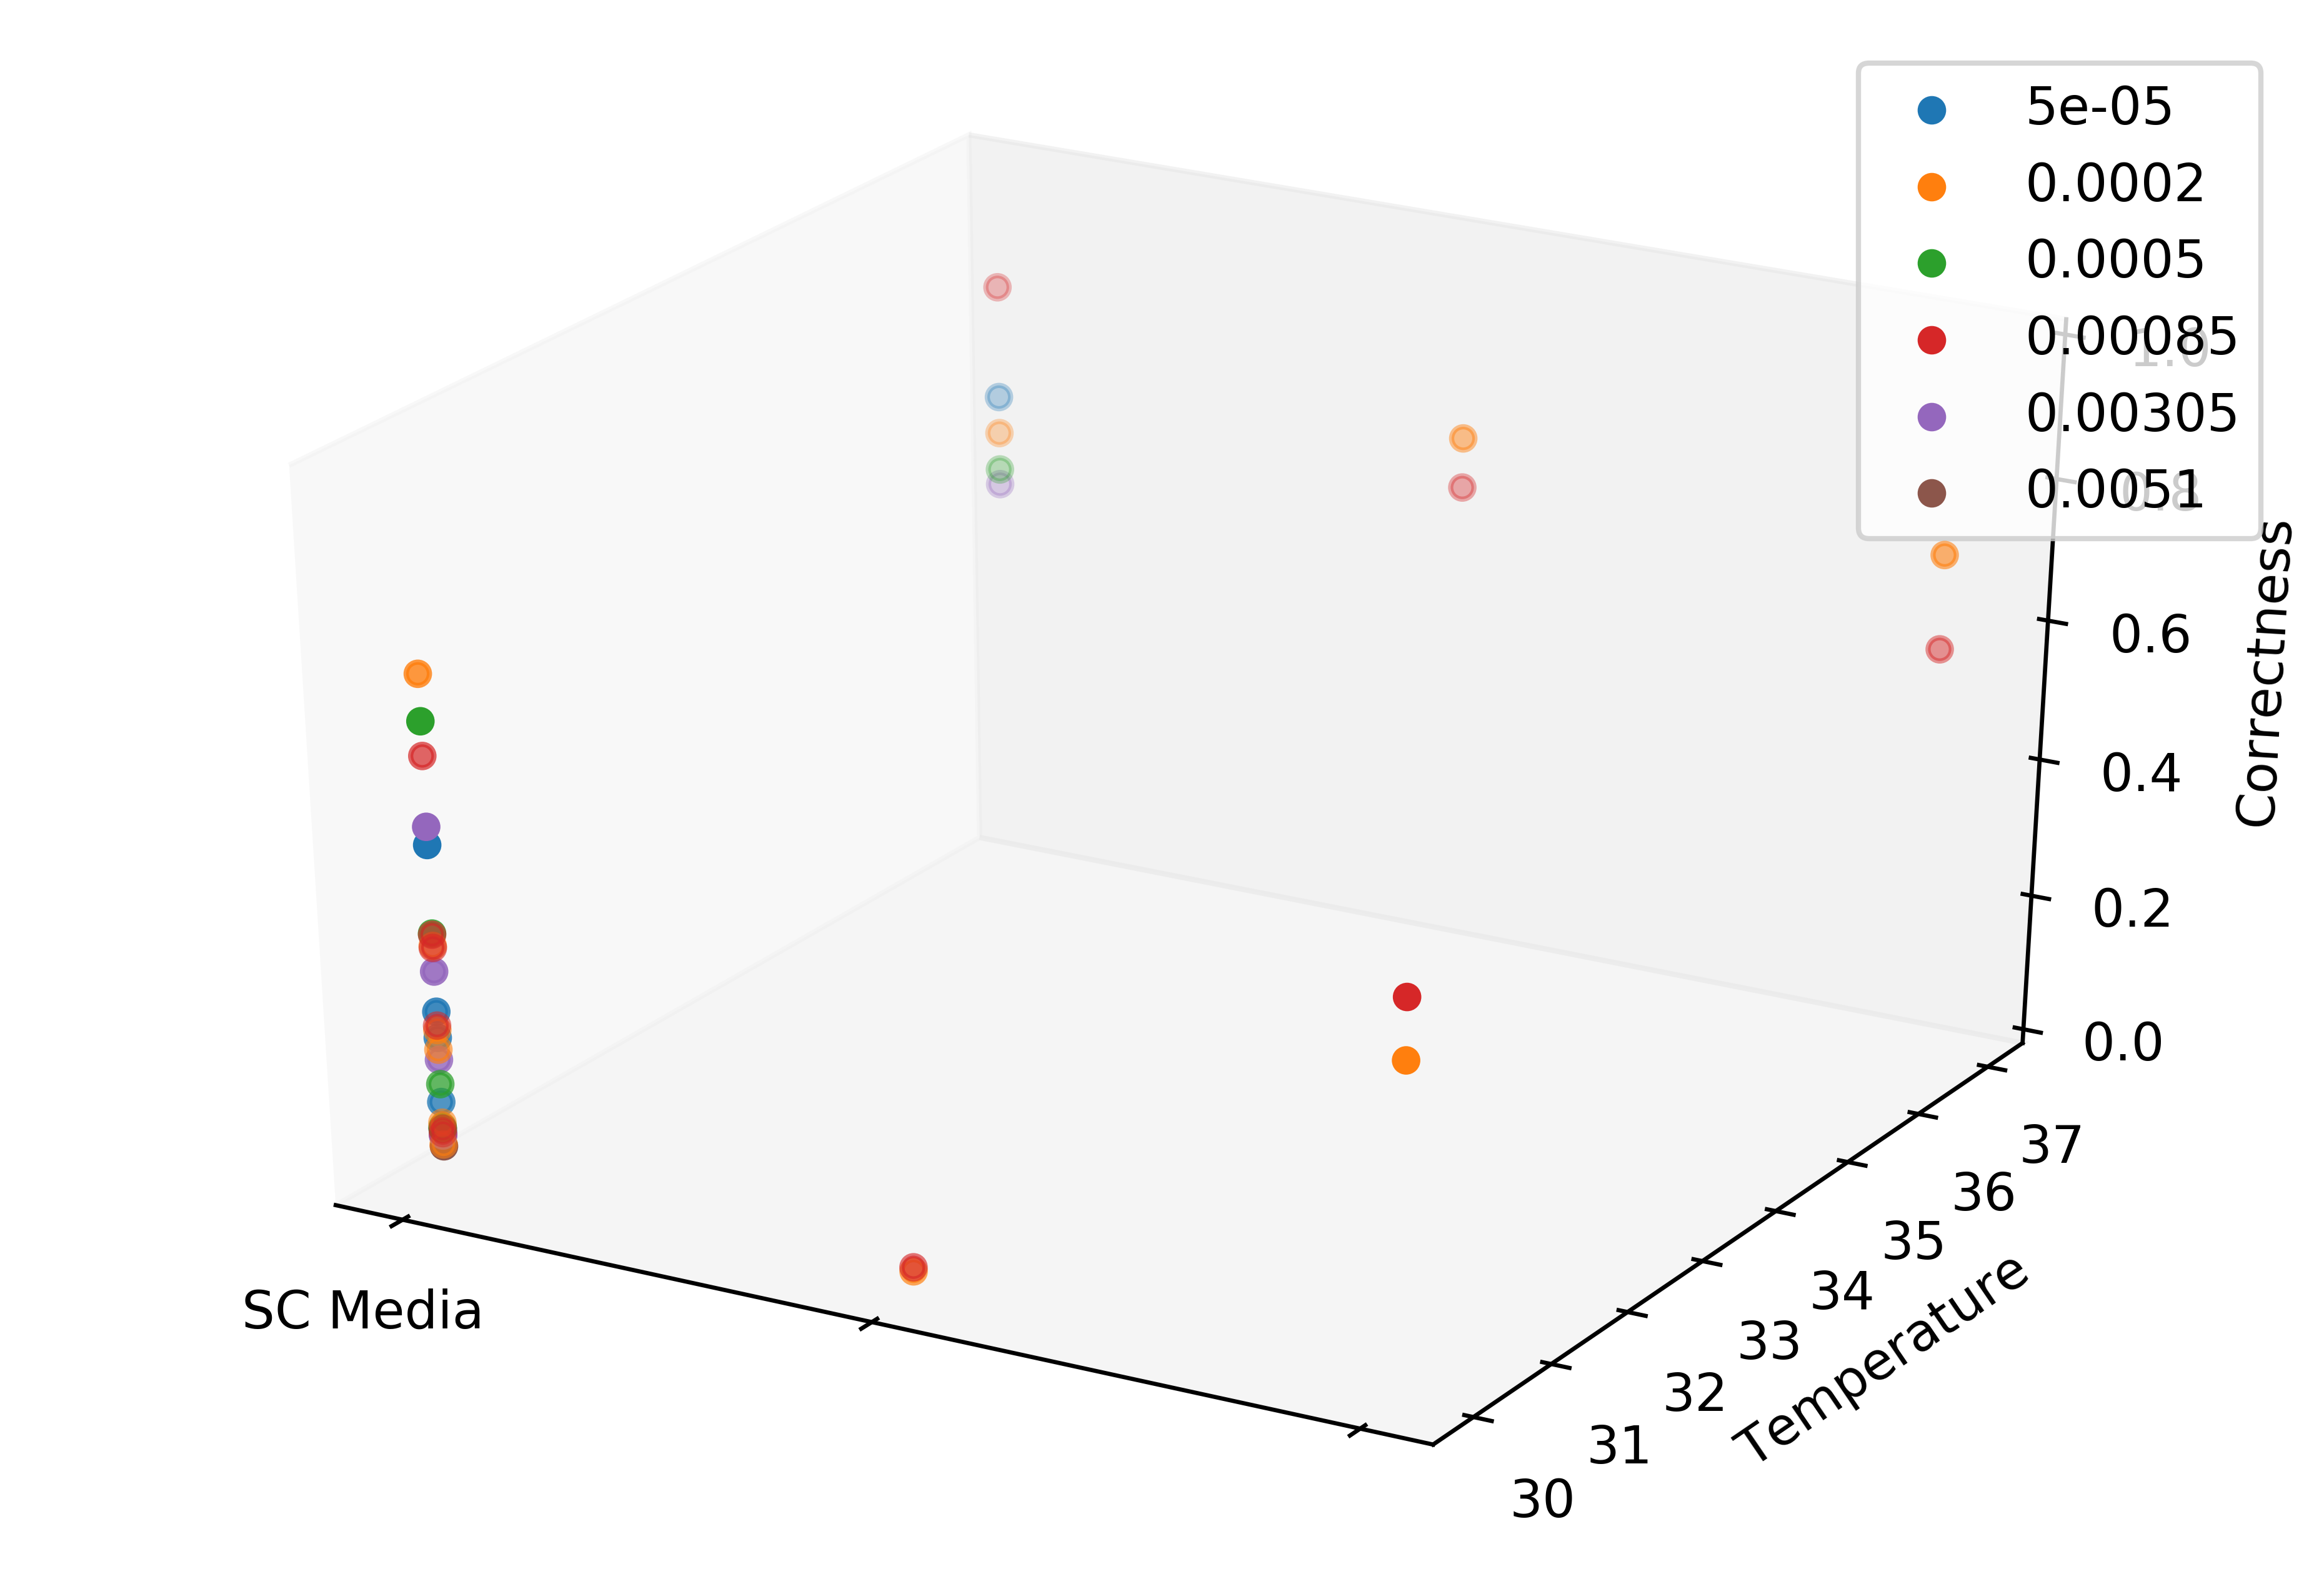

In [9]:
make_plot("NOR")
make_plot_od("NOR")
make_3D_plot("NOR")

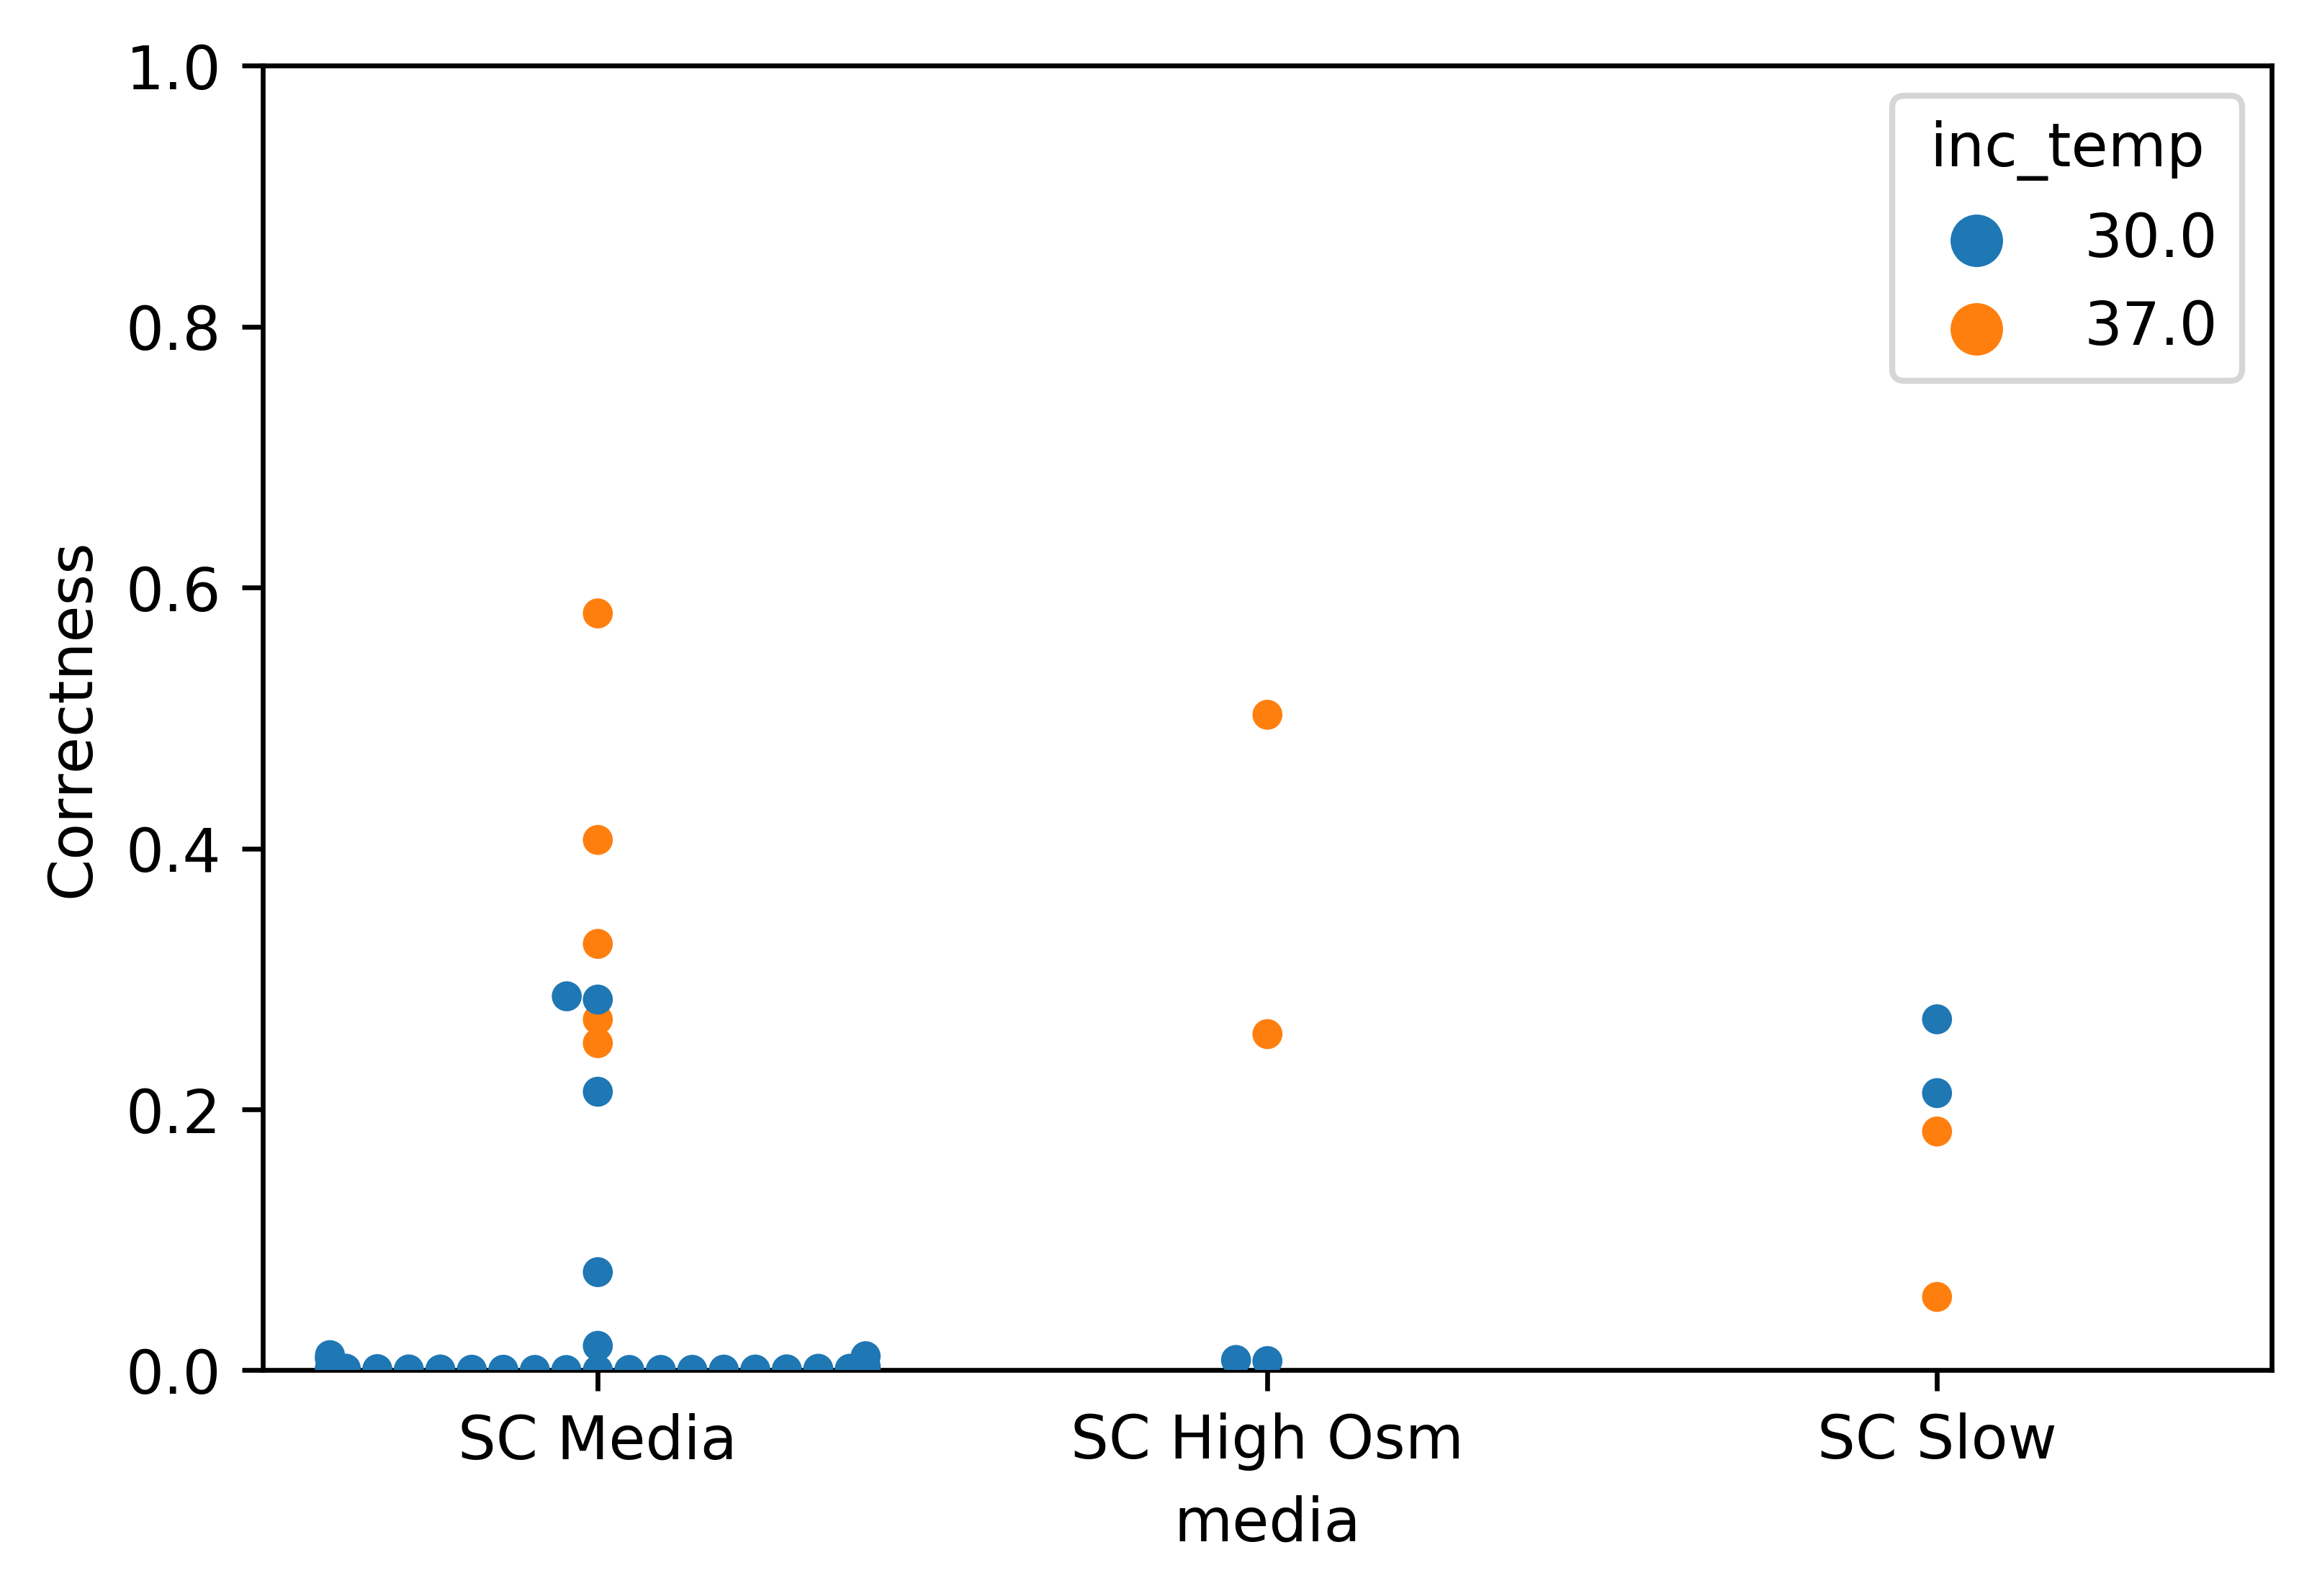

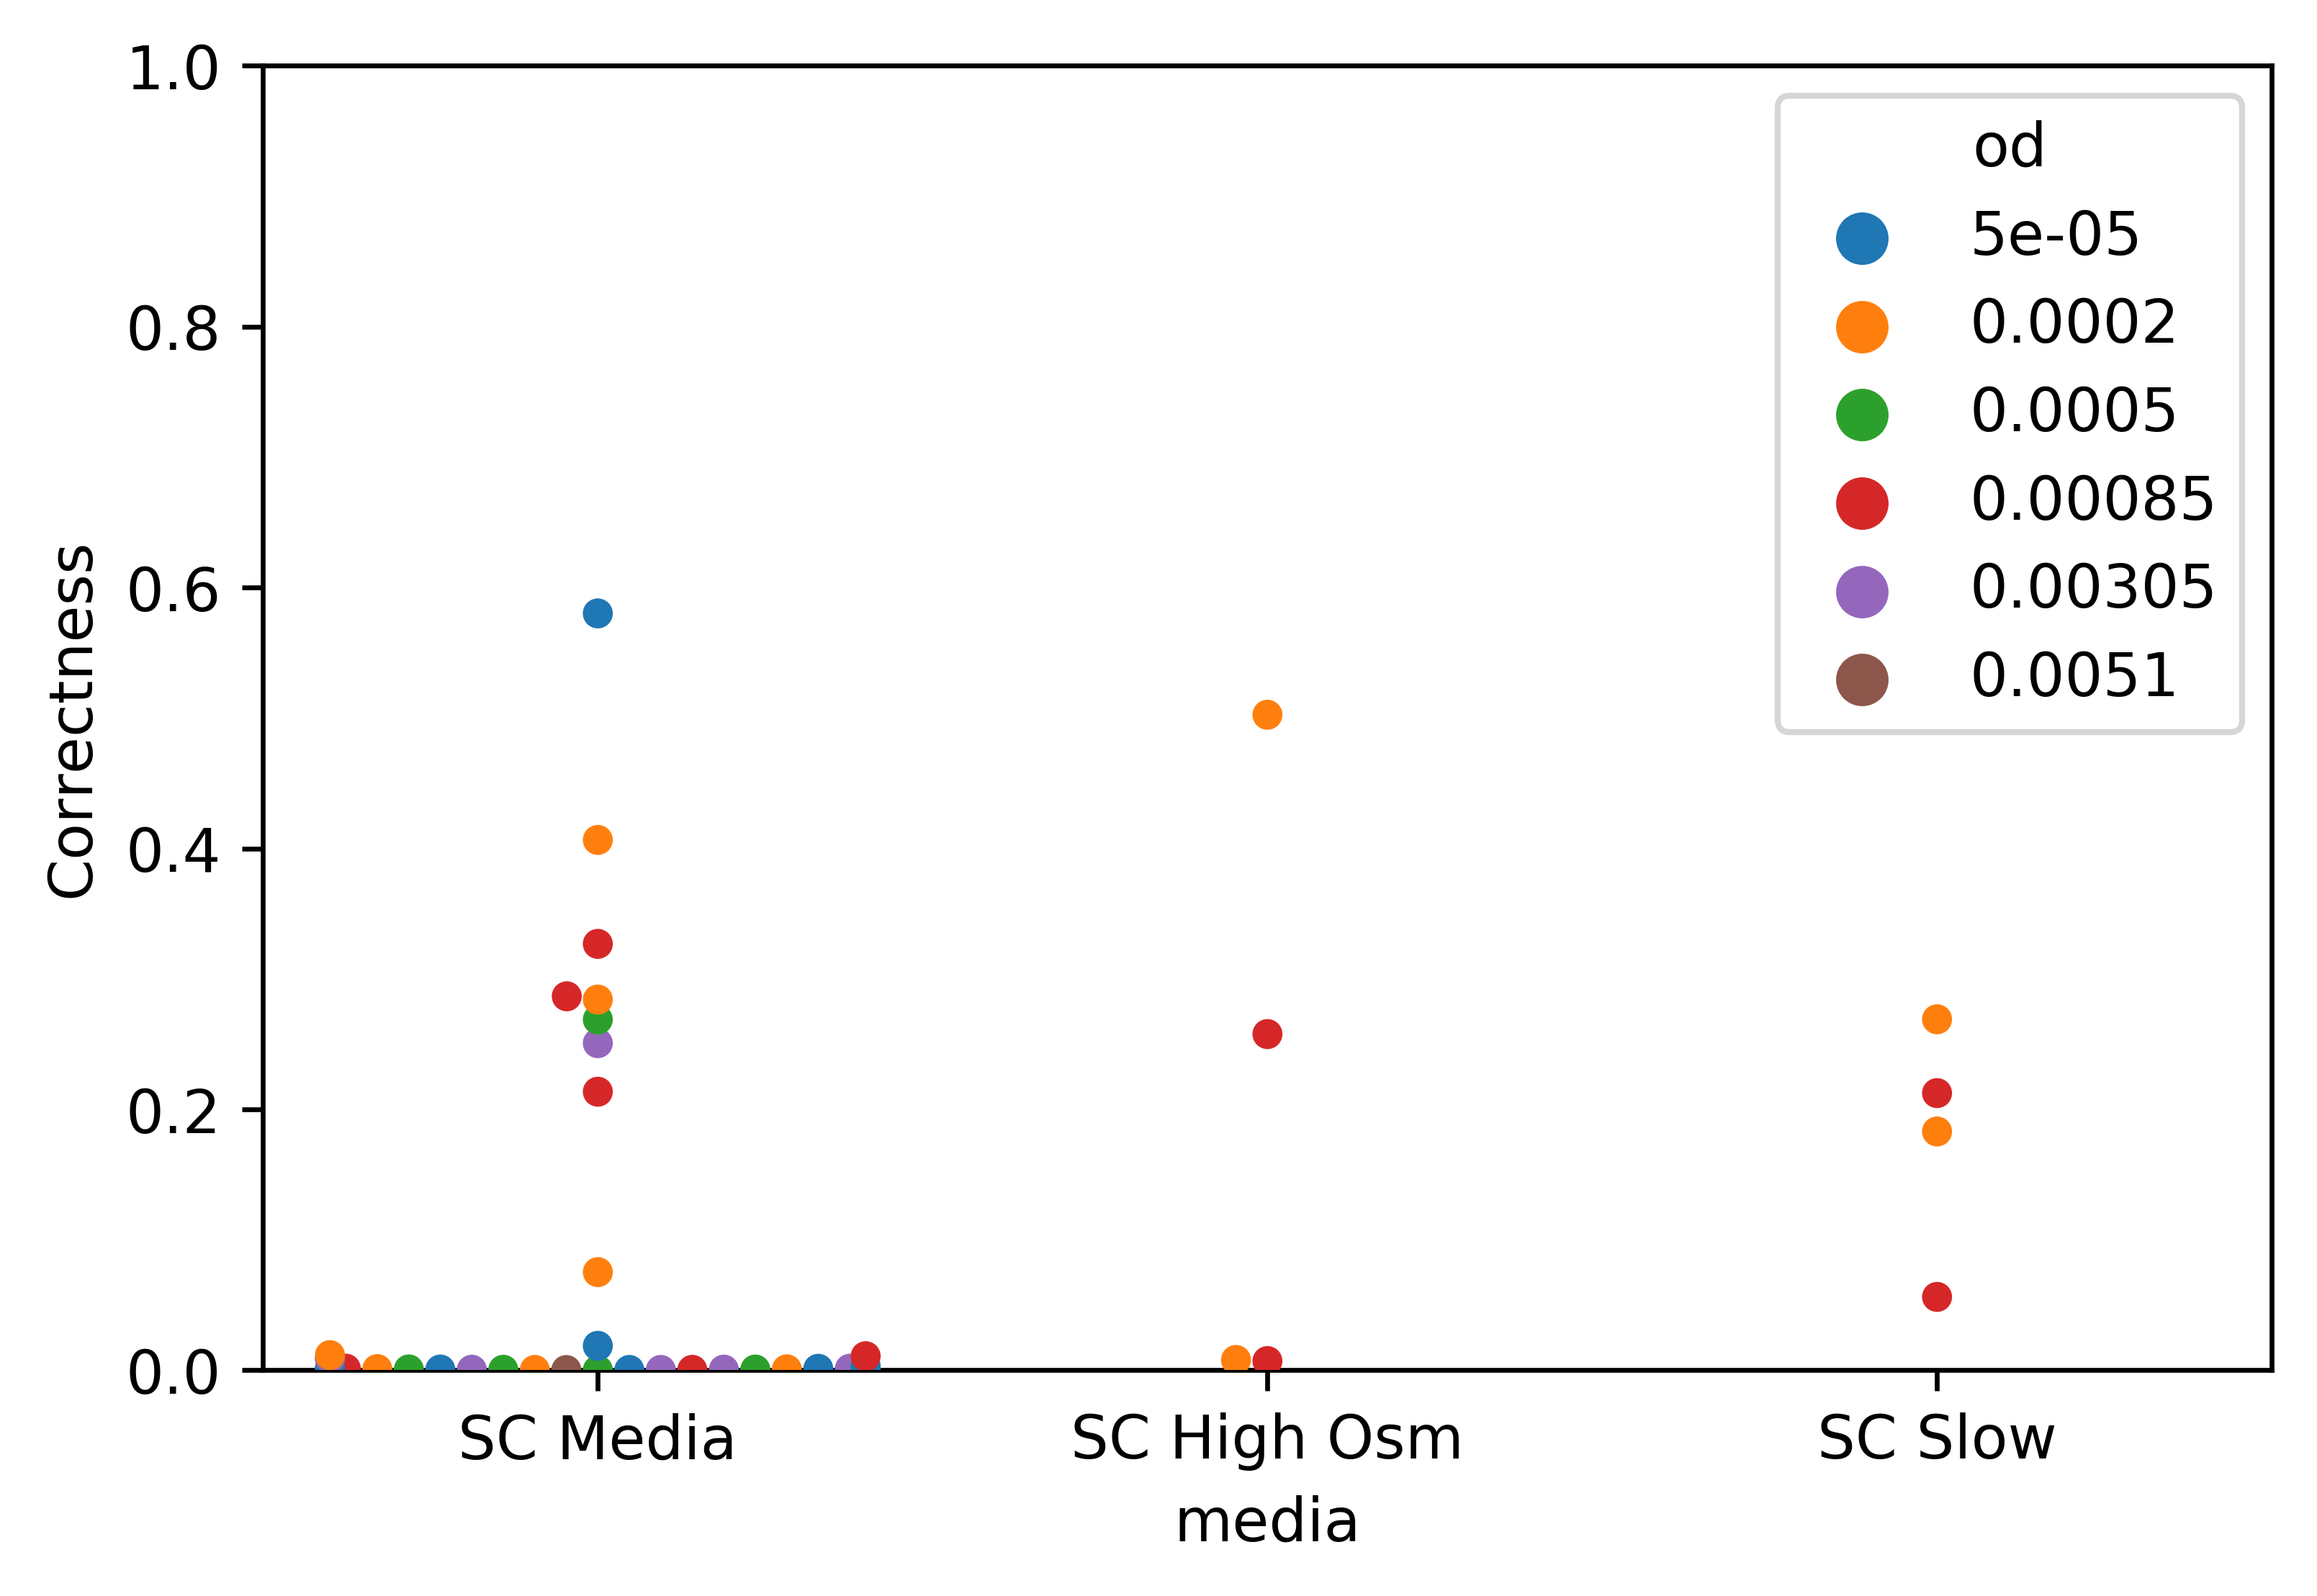

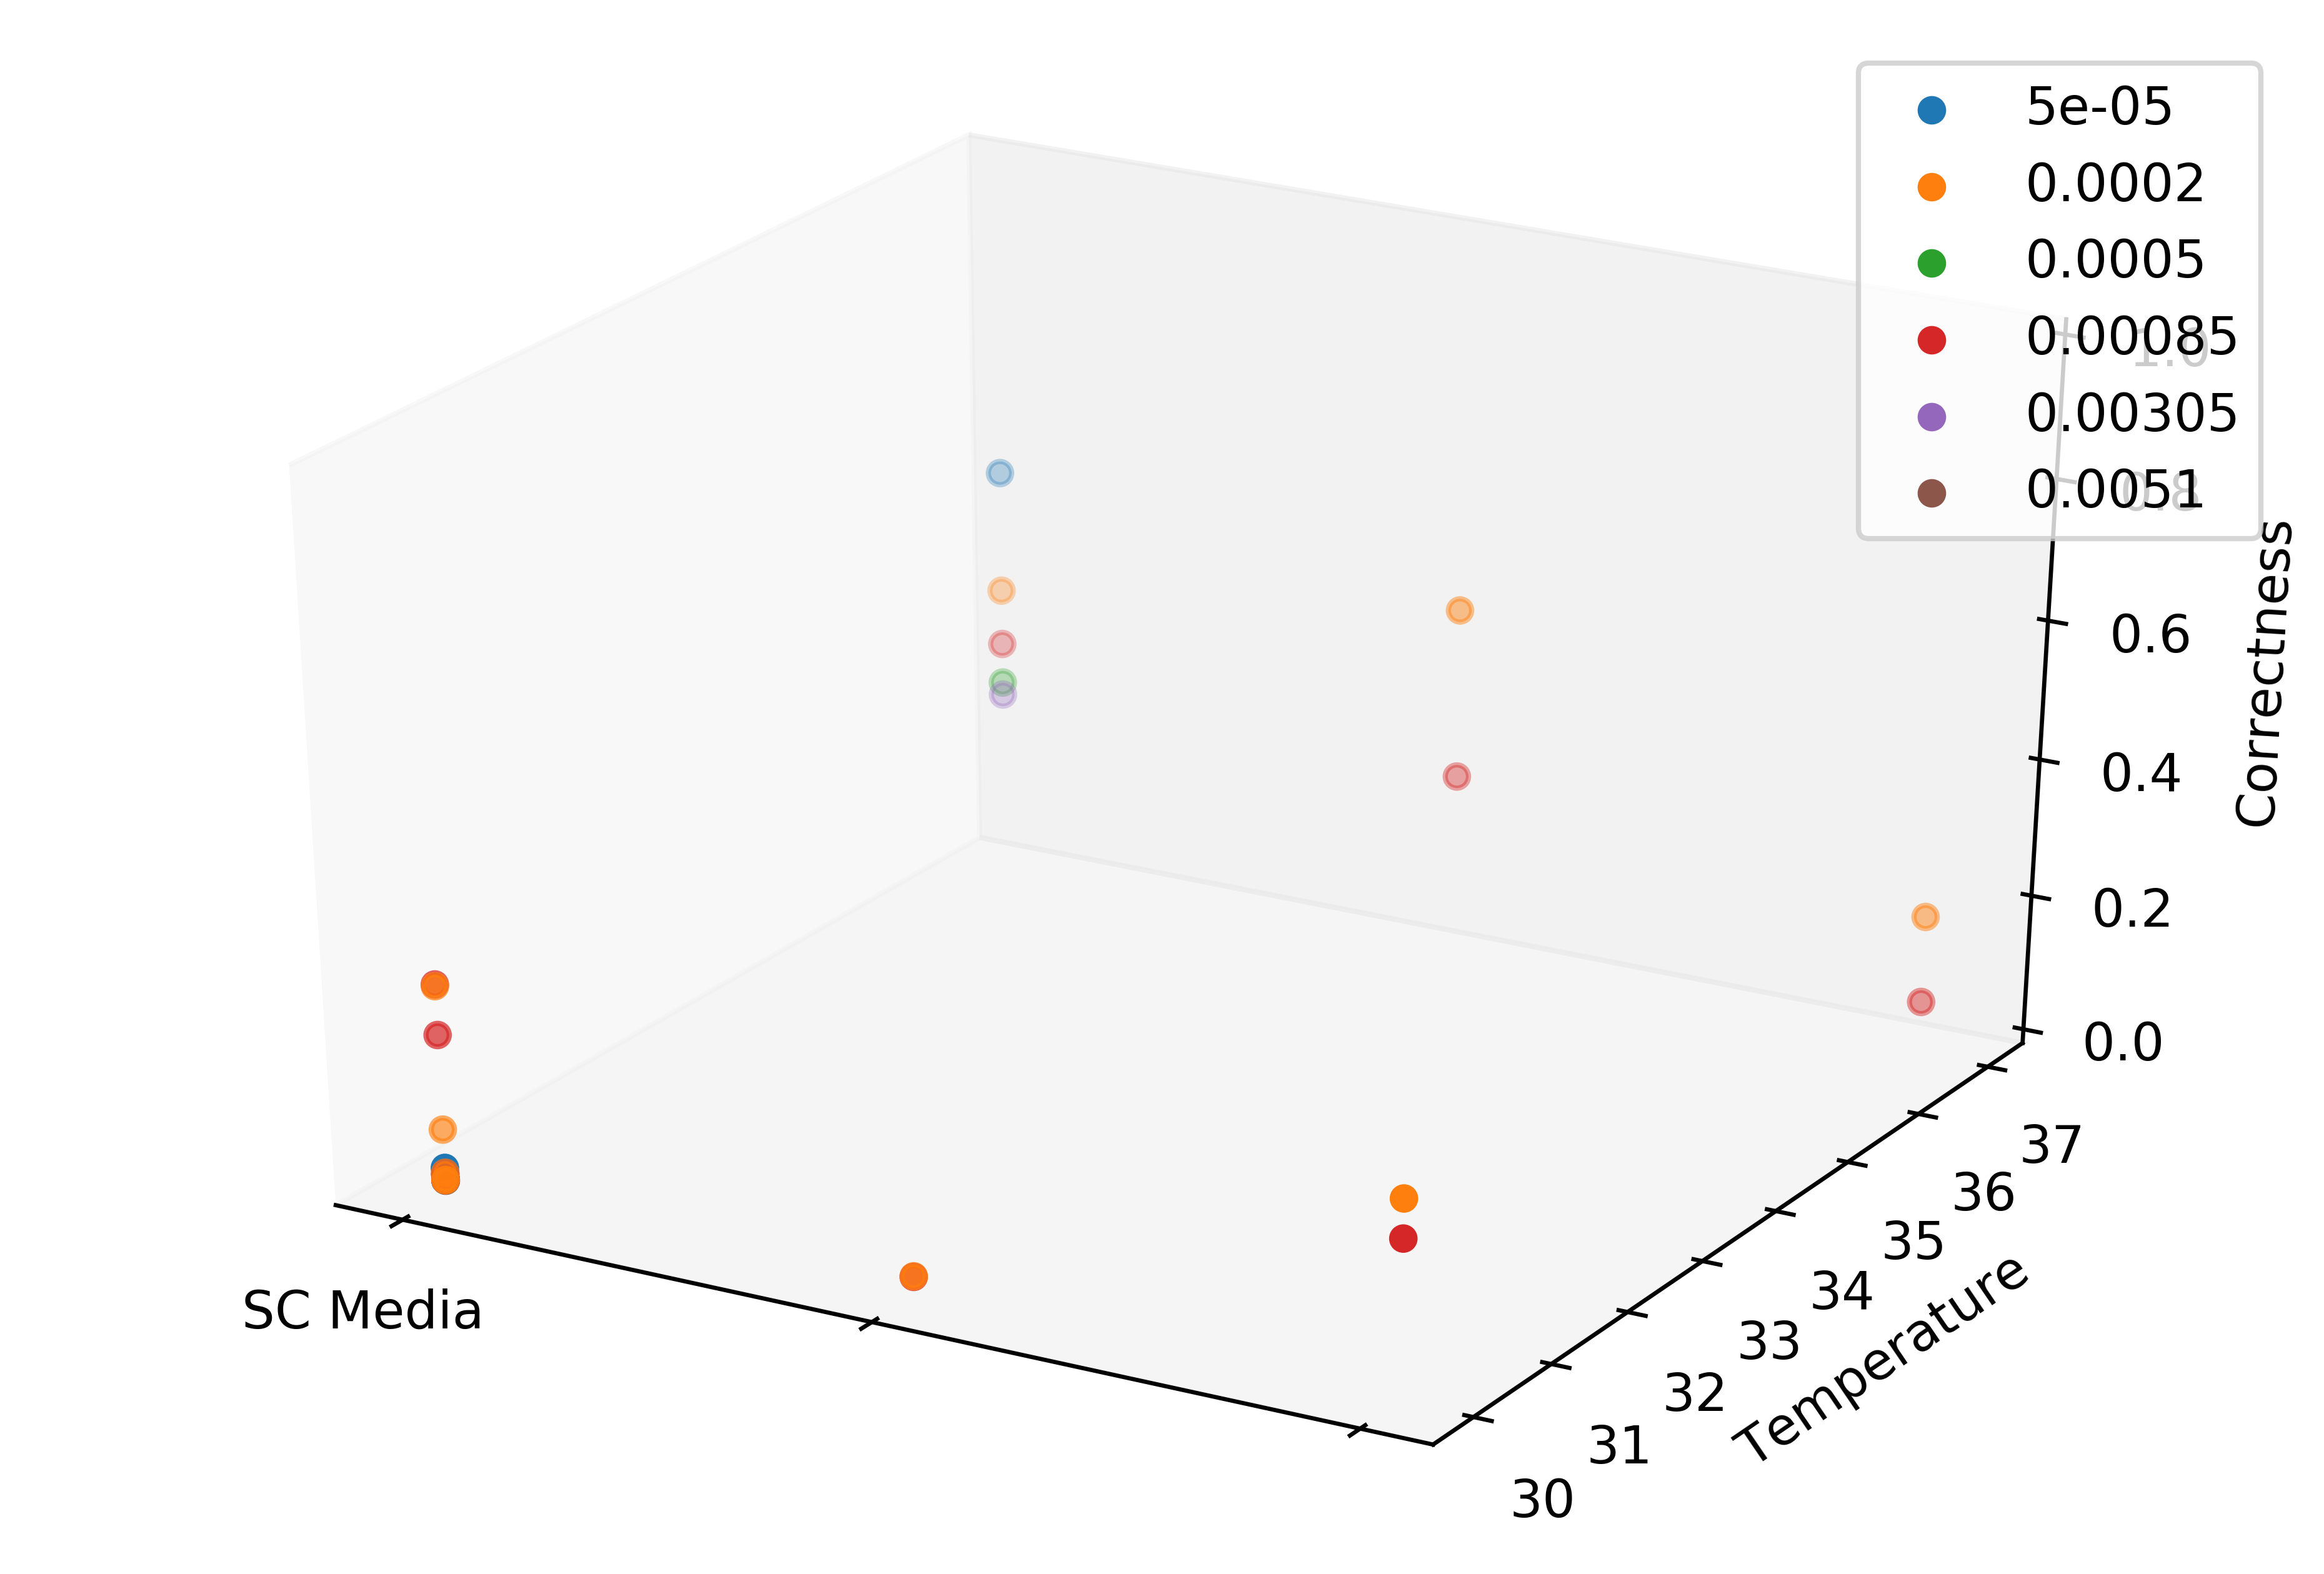

In [10]:
make_plot("XOR")
make_plot_od("XOR")
make_3D_plot("XOR")

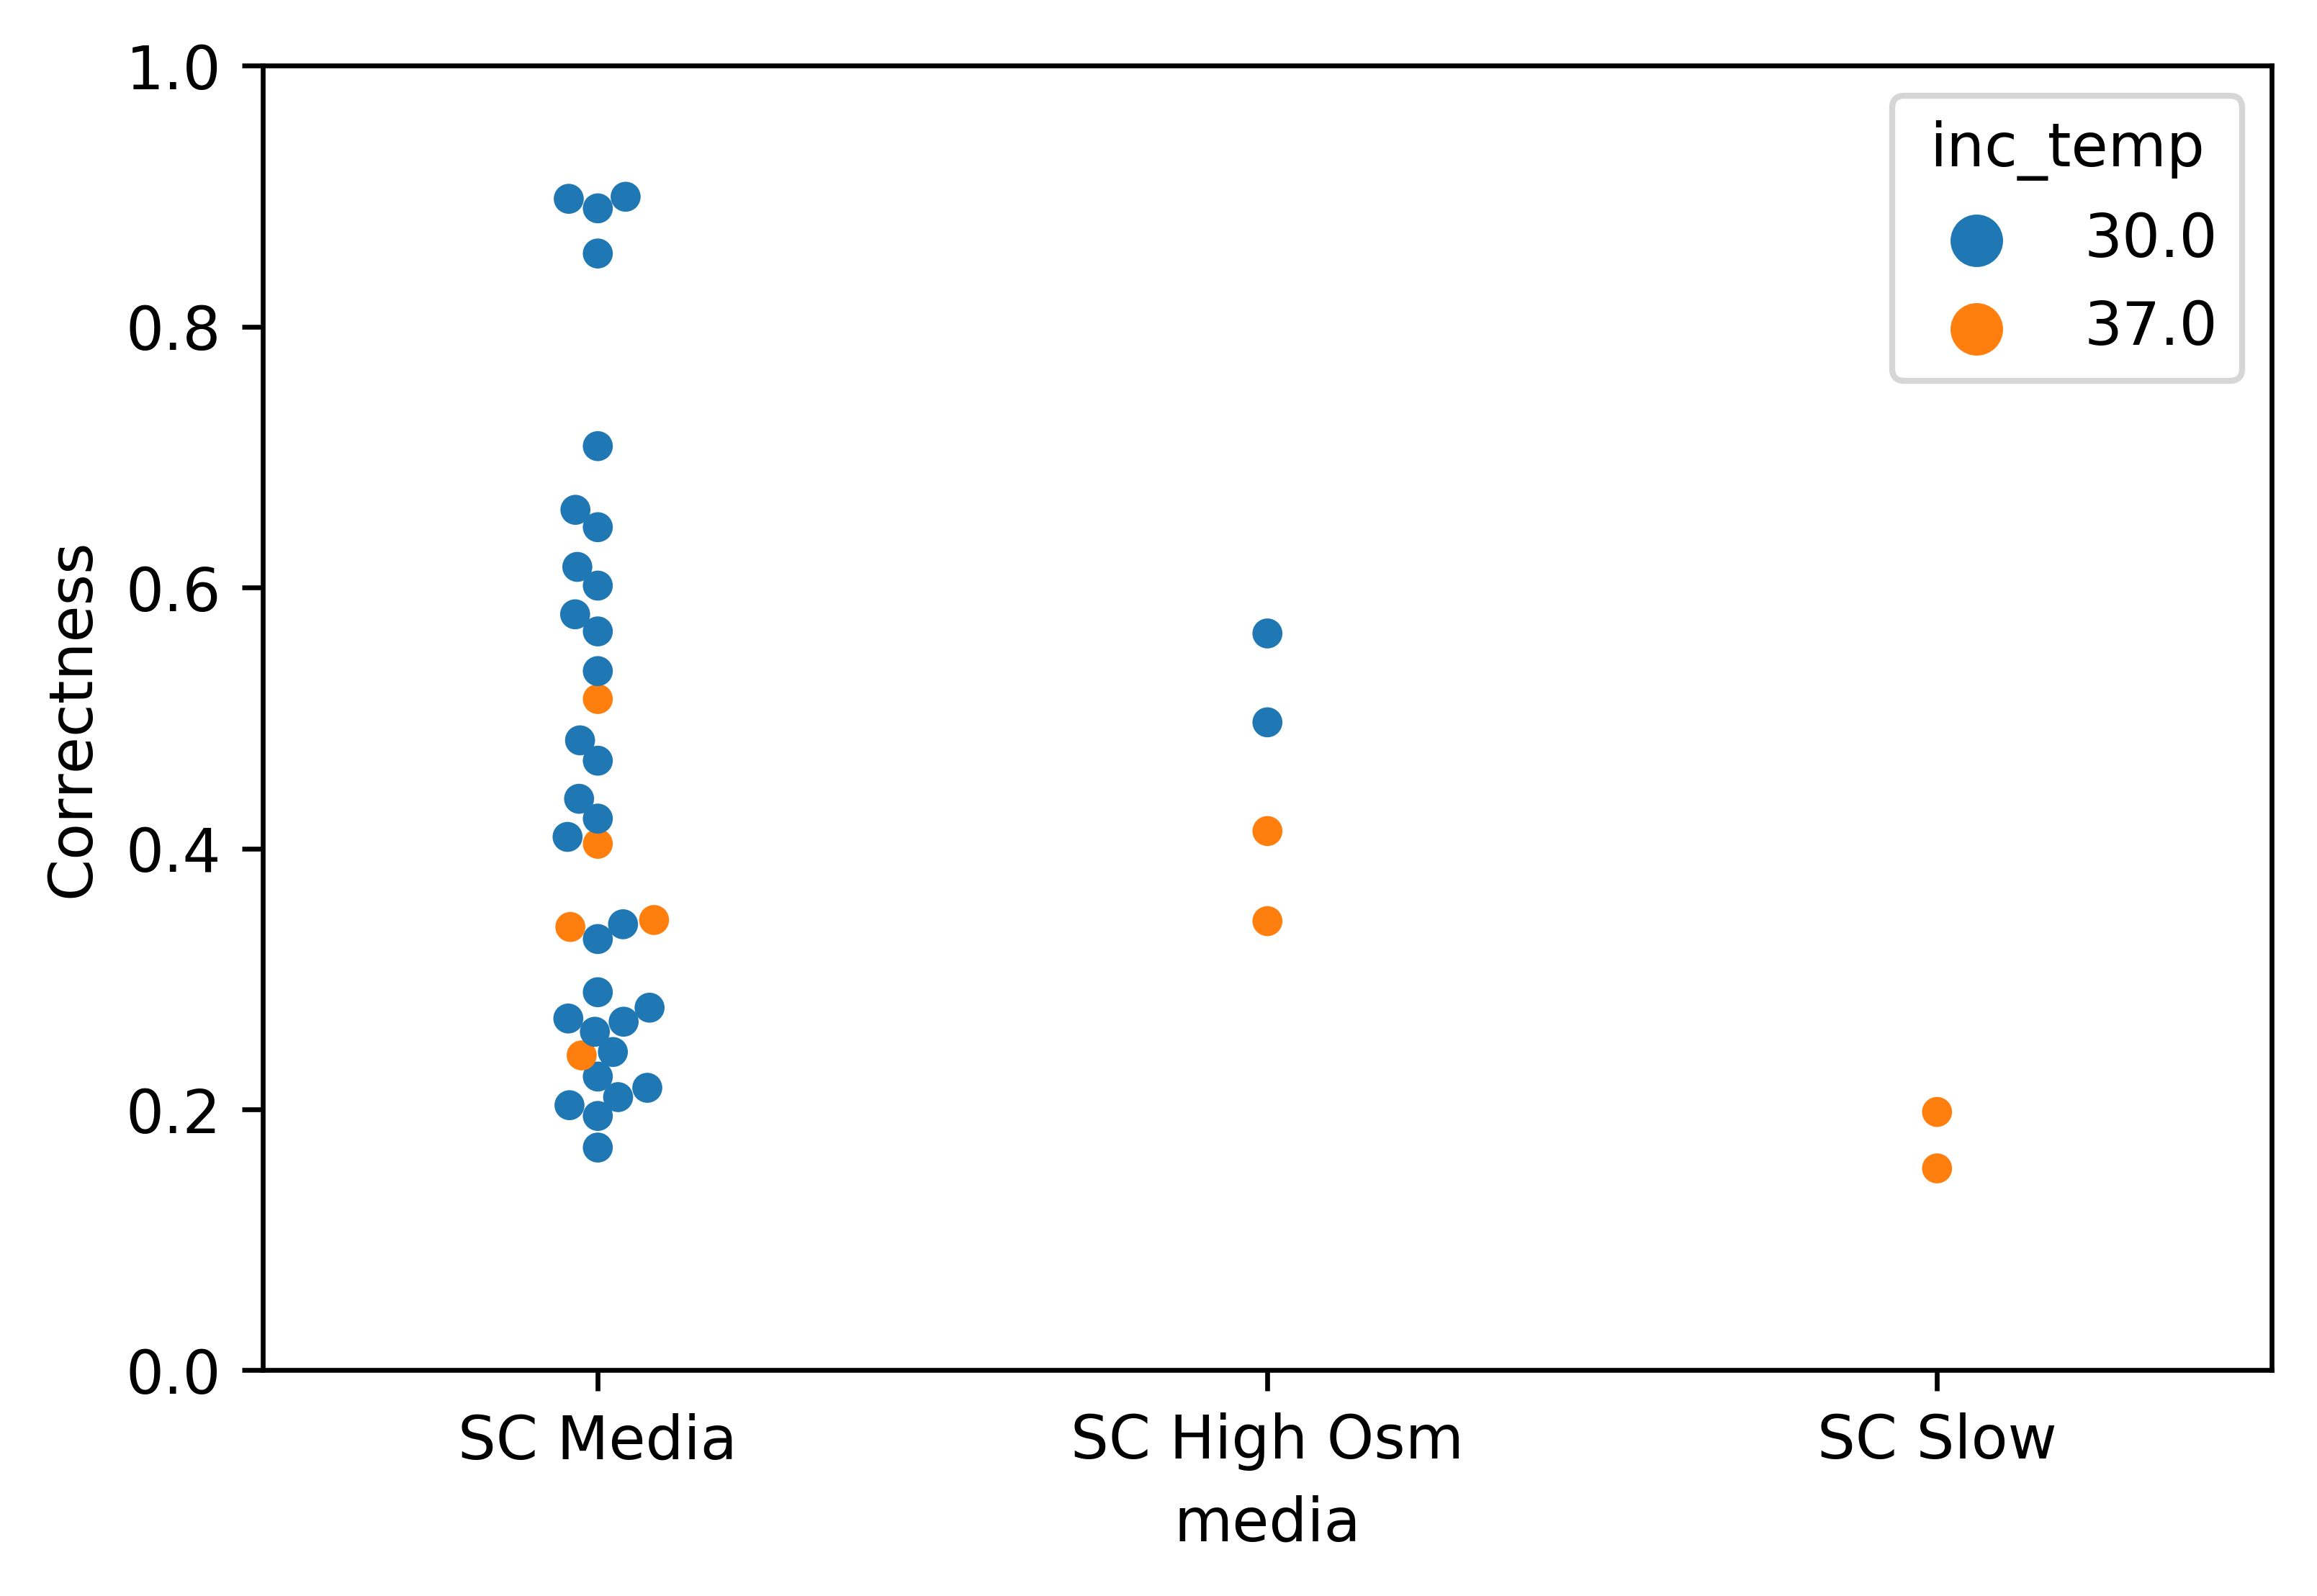

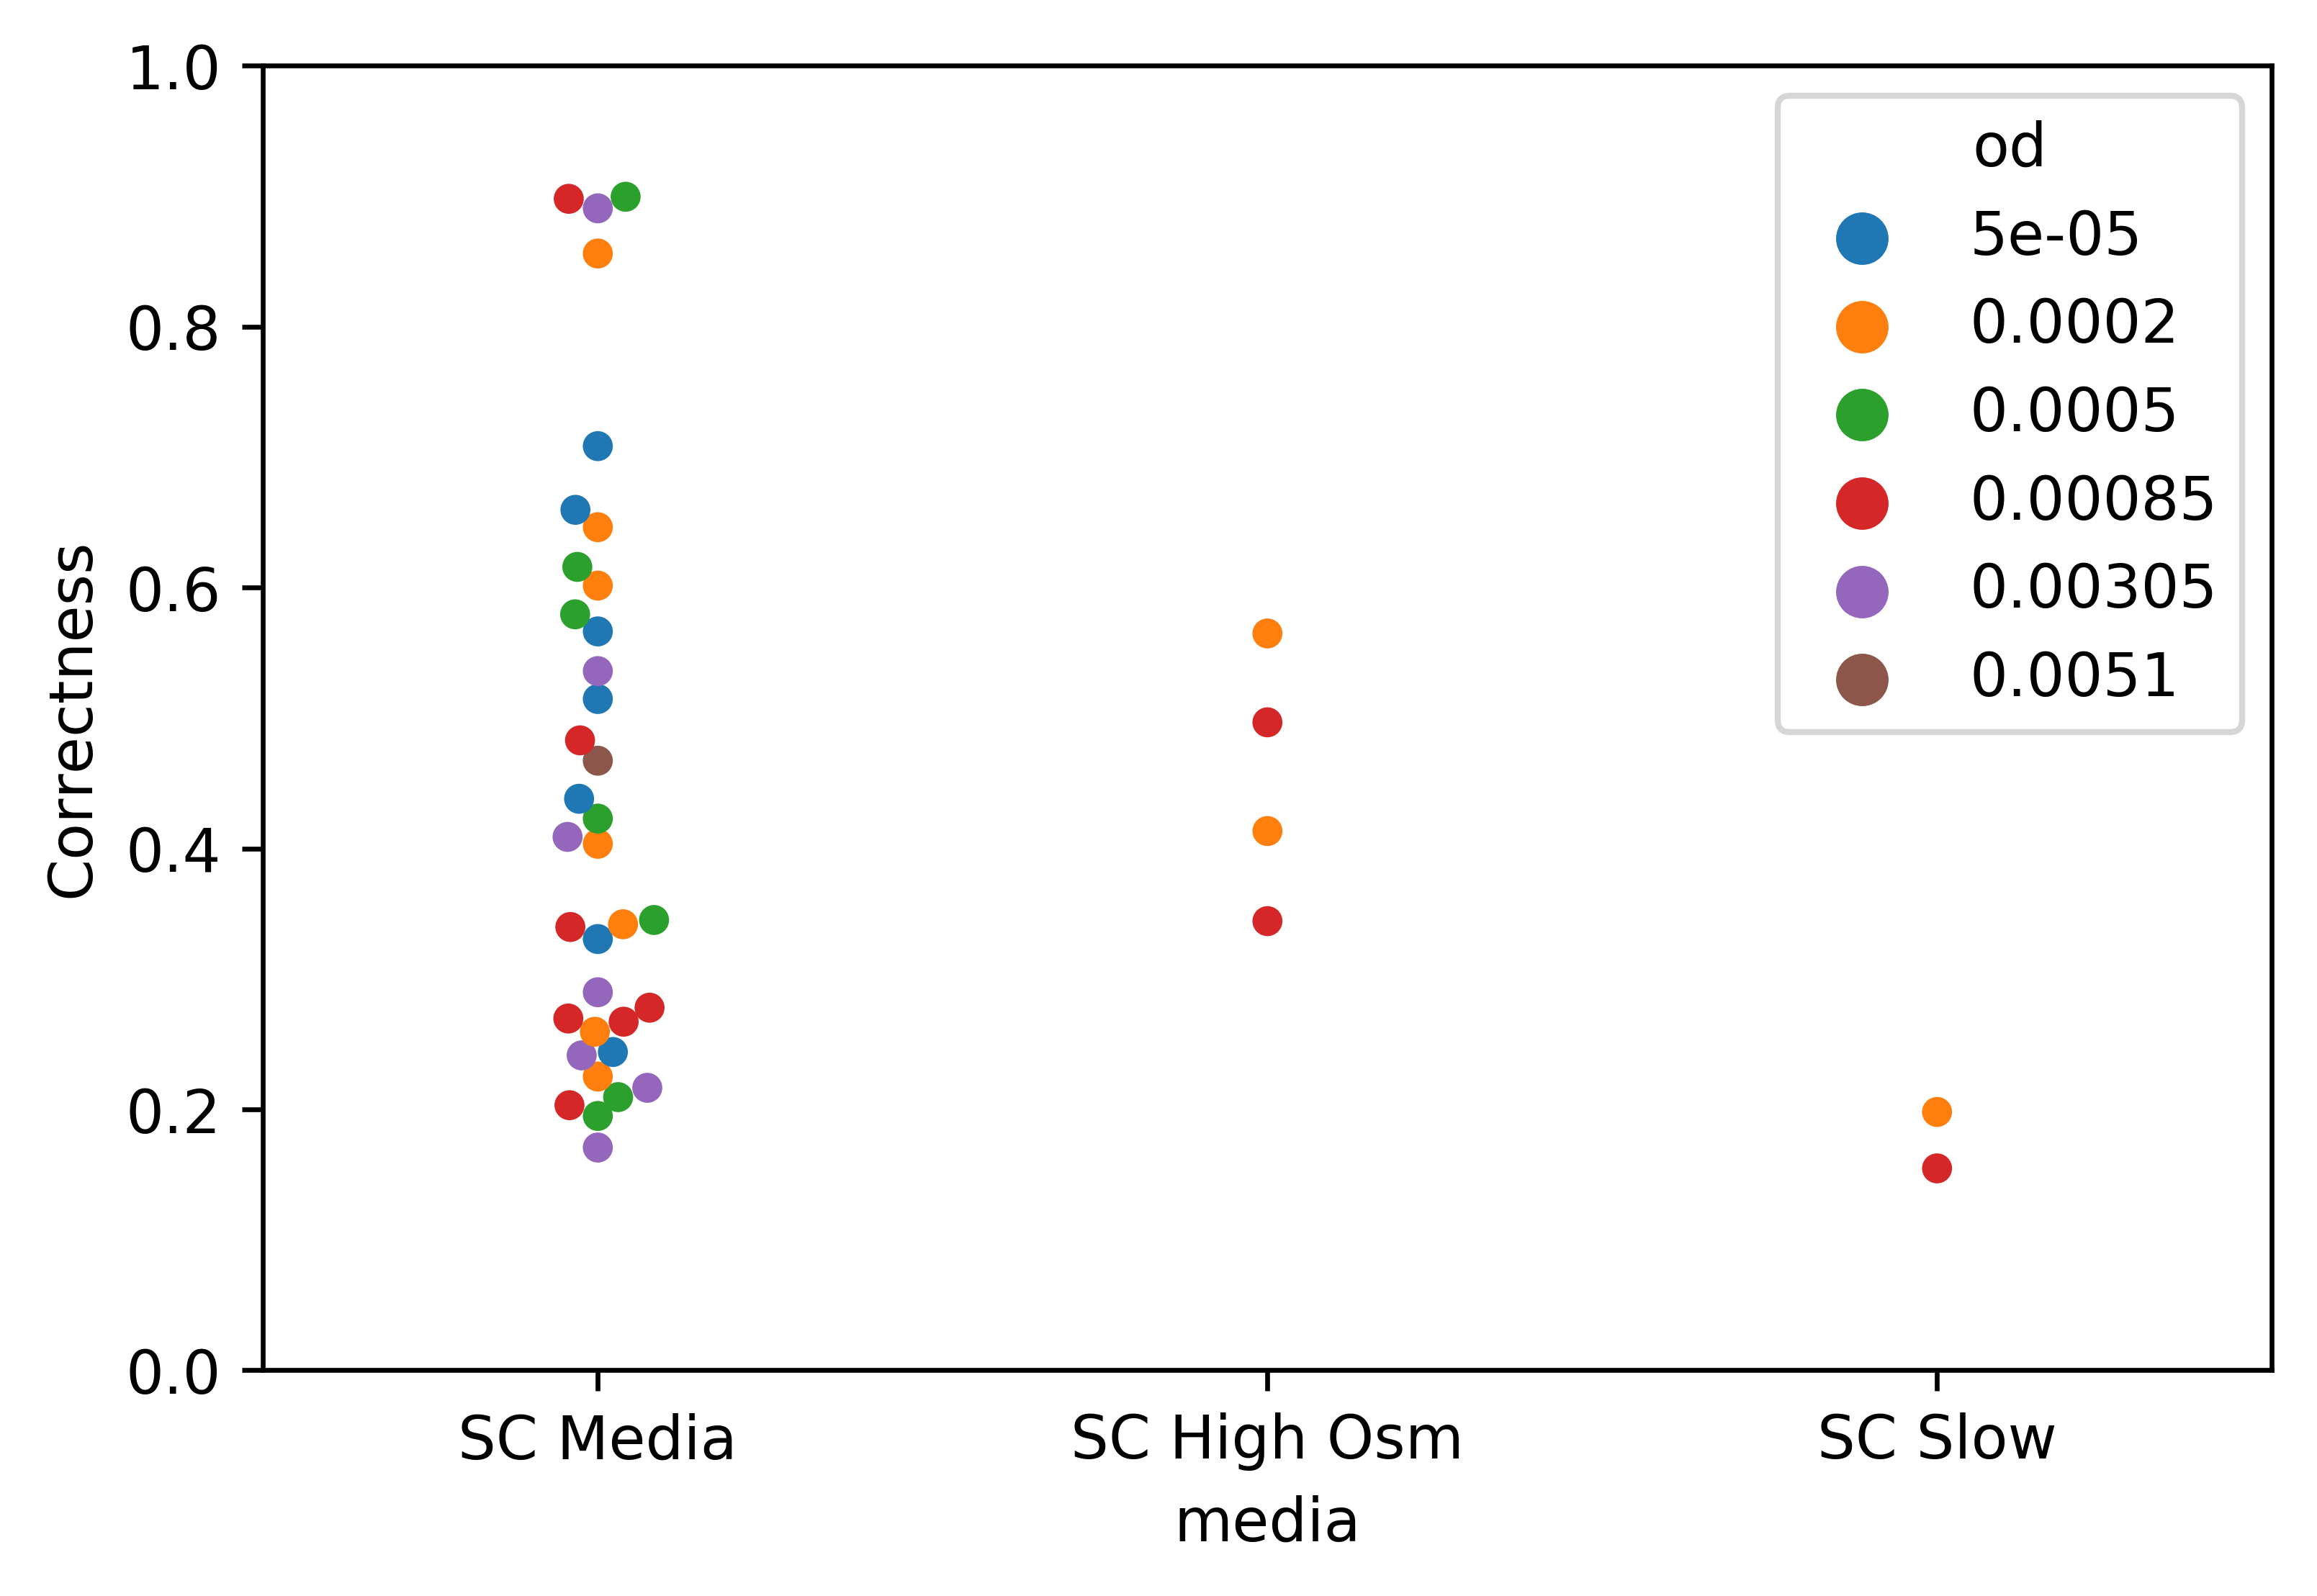

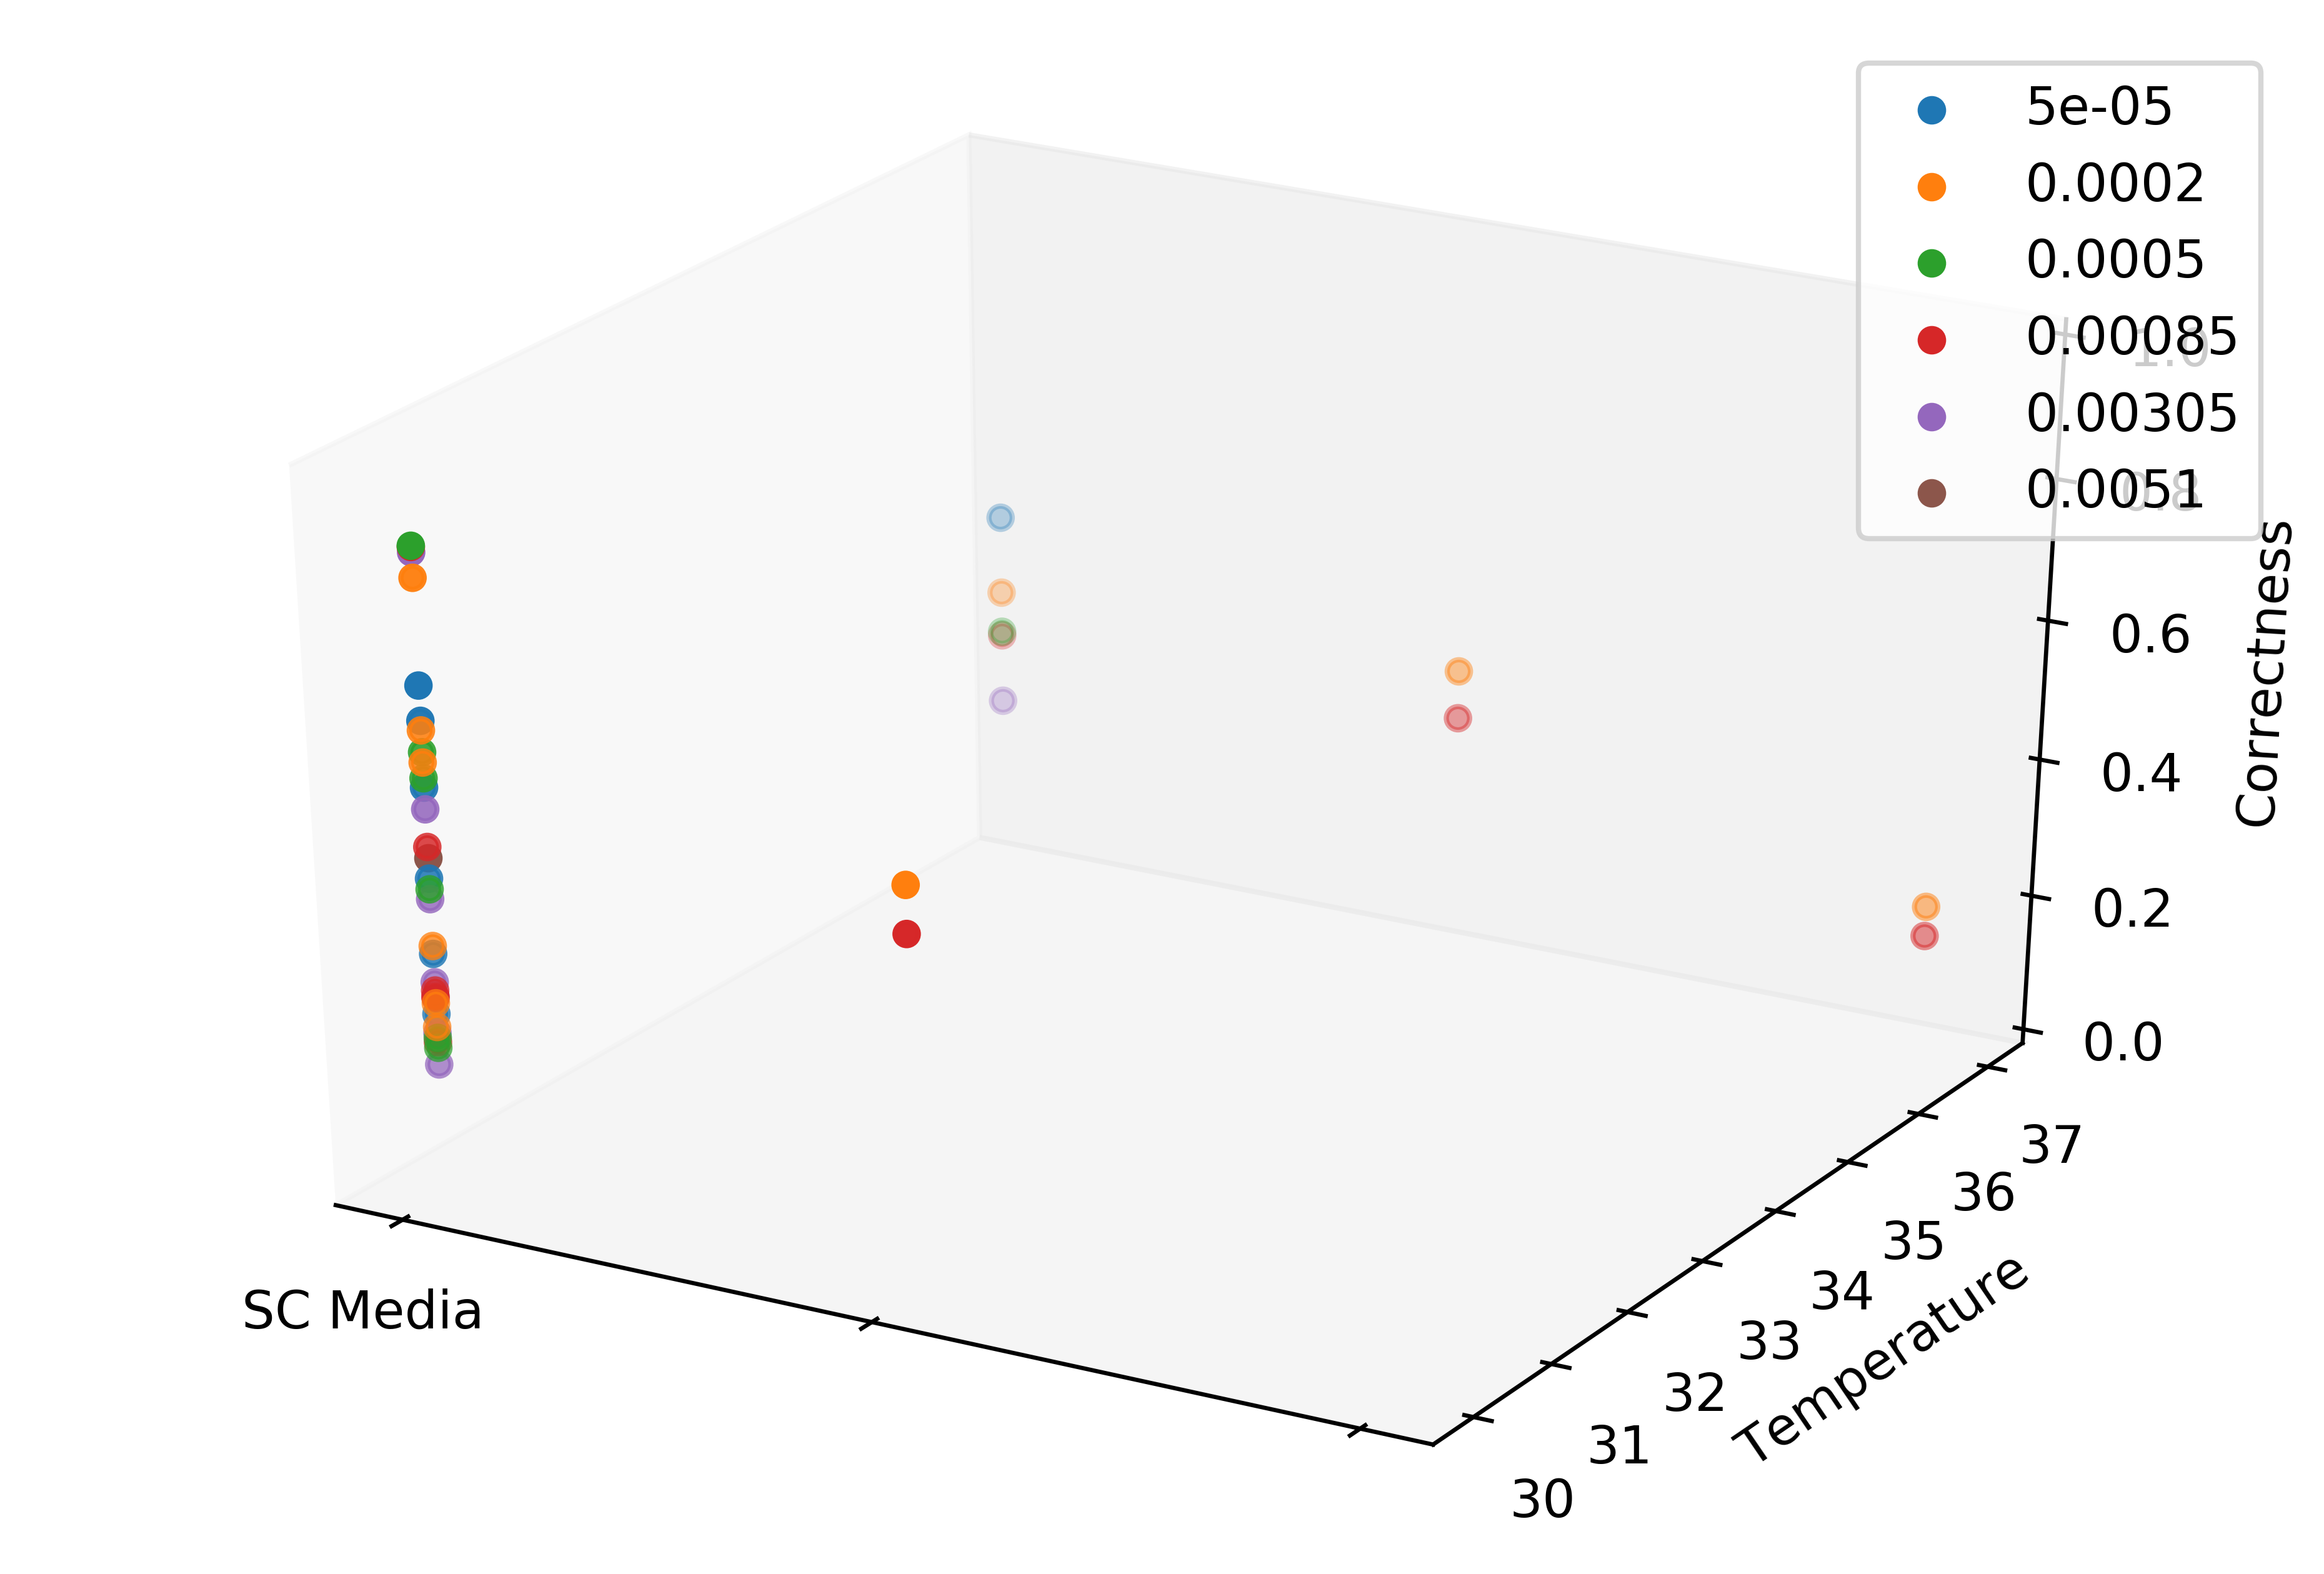

In [11]:
make_plot("XNOR")
make_plot_od("XNOR")
make_3D_plot("XNOR")

In [12]:
conditions2=['media', 'inc_temp', 'od']
circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(circuit_score_df_prod_inc.to_html(index=False))


In [13]:
conditions3=['media', 'od']
circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(circuit_score_df_prod_inc_temp.to_html(index=False))

In [14]:
def print_od_media_table(circuit):
    temp_df = circuit_score_df_prod_inc_temp.loc[circuit_score_df_prod_inc_temp['gate'] == circuit]
    print("\n{}\n".format(circuit))
    return temp_df.pivot_table(index="media", columns='od', values=correctness_col)


    

In [15]:
print_od_media_table("AND")


AND



od            0.00005   0.00020   0.00050   0.00085  0.00305   0.00510
media                                                                 
SC High Osm       NaN  0.777670       NaN  0.648170      NaN       NaN
SC Media     0.714152  0.585273  0.630609  0.567883   0.5899  0.677844
SC Slow           NaN  0.445034       NaN  0.452238      NaN       NaN

In [16]:
print_od_media_table("NAND")


NAND



od            0.00005   0.00020   0.00050   0.00085  0.00305   0.00510
media                                                                 
SC High Osm       NaN  0.296592       NaN  0.279652      NaN       NaN
SC Media     0.486467  0.336644  0.417231  0.286168  0.21845  0.075327
SC Slow           NaN  0.114426       NaN  0.133367      NaN       NaN

In [17]:
print_od_media_table("OR")


OR



od            0.00005   0.00020   0.00050   0.00085   0.00305   0.00510
media                                                                  
SC High Osm       NaN  0.001317       NaN  0.002802       NaN       NaN
SC Media     0.009813  0.005794  0.001282  0.006903  0.002077  0.000056
SC Slow           NaN  0.006347       NaN  0.006633       NaN       NaN

In [18]:
print_od_media_table("NOR")


NOR



od            0.00005   0.00020   0.00050   0.00085   0.00305   0.00510
media                                                                  
SC High Osm       NaN  0.382573       NaN  0.350526       NaN       NaN
SC Media     0.445807  0.454120  0.408902  0.564537  0.381645  0.051494
SC Slow           NaN  0.583849       NaN  0.560520       NaN       NaN

In [19]:
print_od_media_table("XOR")


XOR



od            0.00005   0.00020   0.00050   0.00085   0.00305   0.00510
media                                                                  
SC High Osm       NaN  0.255153       NaN  0.132331       NaN       NaN
SC Media     0.292154  0.234294  0.135408  0.206203  0.126388  0.000132
SC Slow           NaN  0.226001       NaN  0.134304       NaN       NaN

In [20]:
print_od_media_table("XNOR")


XNOR



od            0.00005   0.00020   0.00050   0.00085   0.00305   0.00510
media                                                                  
SC High Osm       NaN  0.489049       NaN  0.420469       NaN       NaN
SC Media     0.502842  0.445962  0.416064  0.369778  0.330036  0.467243
SC Slow           NaN  0.197979       NaN  0.154716       NaN       NaN

In [21]:
circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
HTML(circuit_score_df_prod_media_only.sort_values(by=[correctness_col],ascending=False).to_html(index=False))

In [22]:
HTML(circuit_score_df_prod_media_only.sort_values(by=["gate",correctness_col]).to_html(index=False))


In [23]:
HTML(circuit_score_df_prod_media_only.sort_values(by=["media",correctness_col],ascending=False).to_html(index=False))


In [24]:
overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(overall_circuit_score_df_prod.sort_values(by=[correctness_col],ascending=False).to_html(index=False))


In [25]:
# Dan's robustness score based on std
# Robustness is the std deviation of the score across all conditions after aggregation
circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
circuit_robustness_df.loc[:,"std"] = circuit_robustness_df.loc[:,correctness_col] 
# circuit_robustness_df.loc[:, 'reproducibility'] = circuit_robustness_df.apply(lambda x: 1.0- x[correctness_col], axis=1)
circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
# HTML(circuit_robustness_df.sort_values(by=['reproducibility'],ascending=False).to_html(index=False))
HTML(circuit_robustness_df.sort_values(by=['std'],ascending=False).to_html(index=False))


In [26]:
## Change order of means

conditions3=['media', 'inc_temp']
circuit_score_df_prod_od = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_od_std = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.std).reset_index()
circuit_score_df_prod_od.loc[:,"std"] = circuit_score_df_prod_od_std.loc[:,correctness_col].values
HTML(circuit_score_df_prod_od.to_html(index=False))


In [27]:
circuit_score_df_prod_media_only_odfirst = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_media_only_odfirst.sort_values(by=[correctness_col])
HTML(circuit_score_df_prod_media_only_odfirst.sort_values(by=[correctness_col],ascending=False).to_html(index=False))



In [28]:
overall_circuit_score_df_prod_only_odfirst = circuit_score_df_prod_media_only_odfirst.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(overall_circuit_score_df_prod_only_odfirst.sort_values(by=[correctness_col],ascending=False).to_html(index=False))


In [29]:
mpl.rcParams['figure.dpi']= 600
csdp1 = circuit_score_df_prod_od
# make error bar plots
def errorplot(gate):
    plt.figure()
    df_prod = csdp1[(csdp1["gate"]==gate)]
    data30 = df_prod.loc[df_prod.inc_temp==30.0][correctness_col].values
    data37 = df_prod.loc[df_prod.inc_temp==37.0][correctness_col].values
    std30 = df_prod.loc[df_prod.inc_temp==30.0]["std"].values
    std37 = df_prod.loc[df_prod.inc_temp==37.0]["std"].values
    plt.errorbar(range(0,len(data30)),data30,std30,color="b",linestyle="none",marker="o",label="30C")
    plt.errorbar(range(0,len(data37)),data37,std37,color="r",linestyle="none",marker="o",label="37C")
    plt.xticks(range(0,3), df_prod.media.unique())
    plt.ylim((0,1))
    plt.ylabel("Correctness") 
    

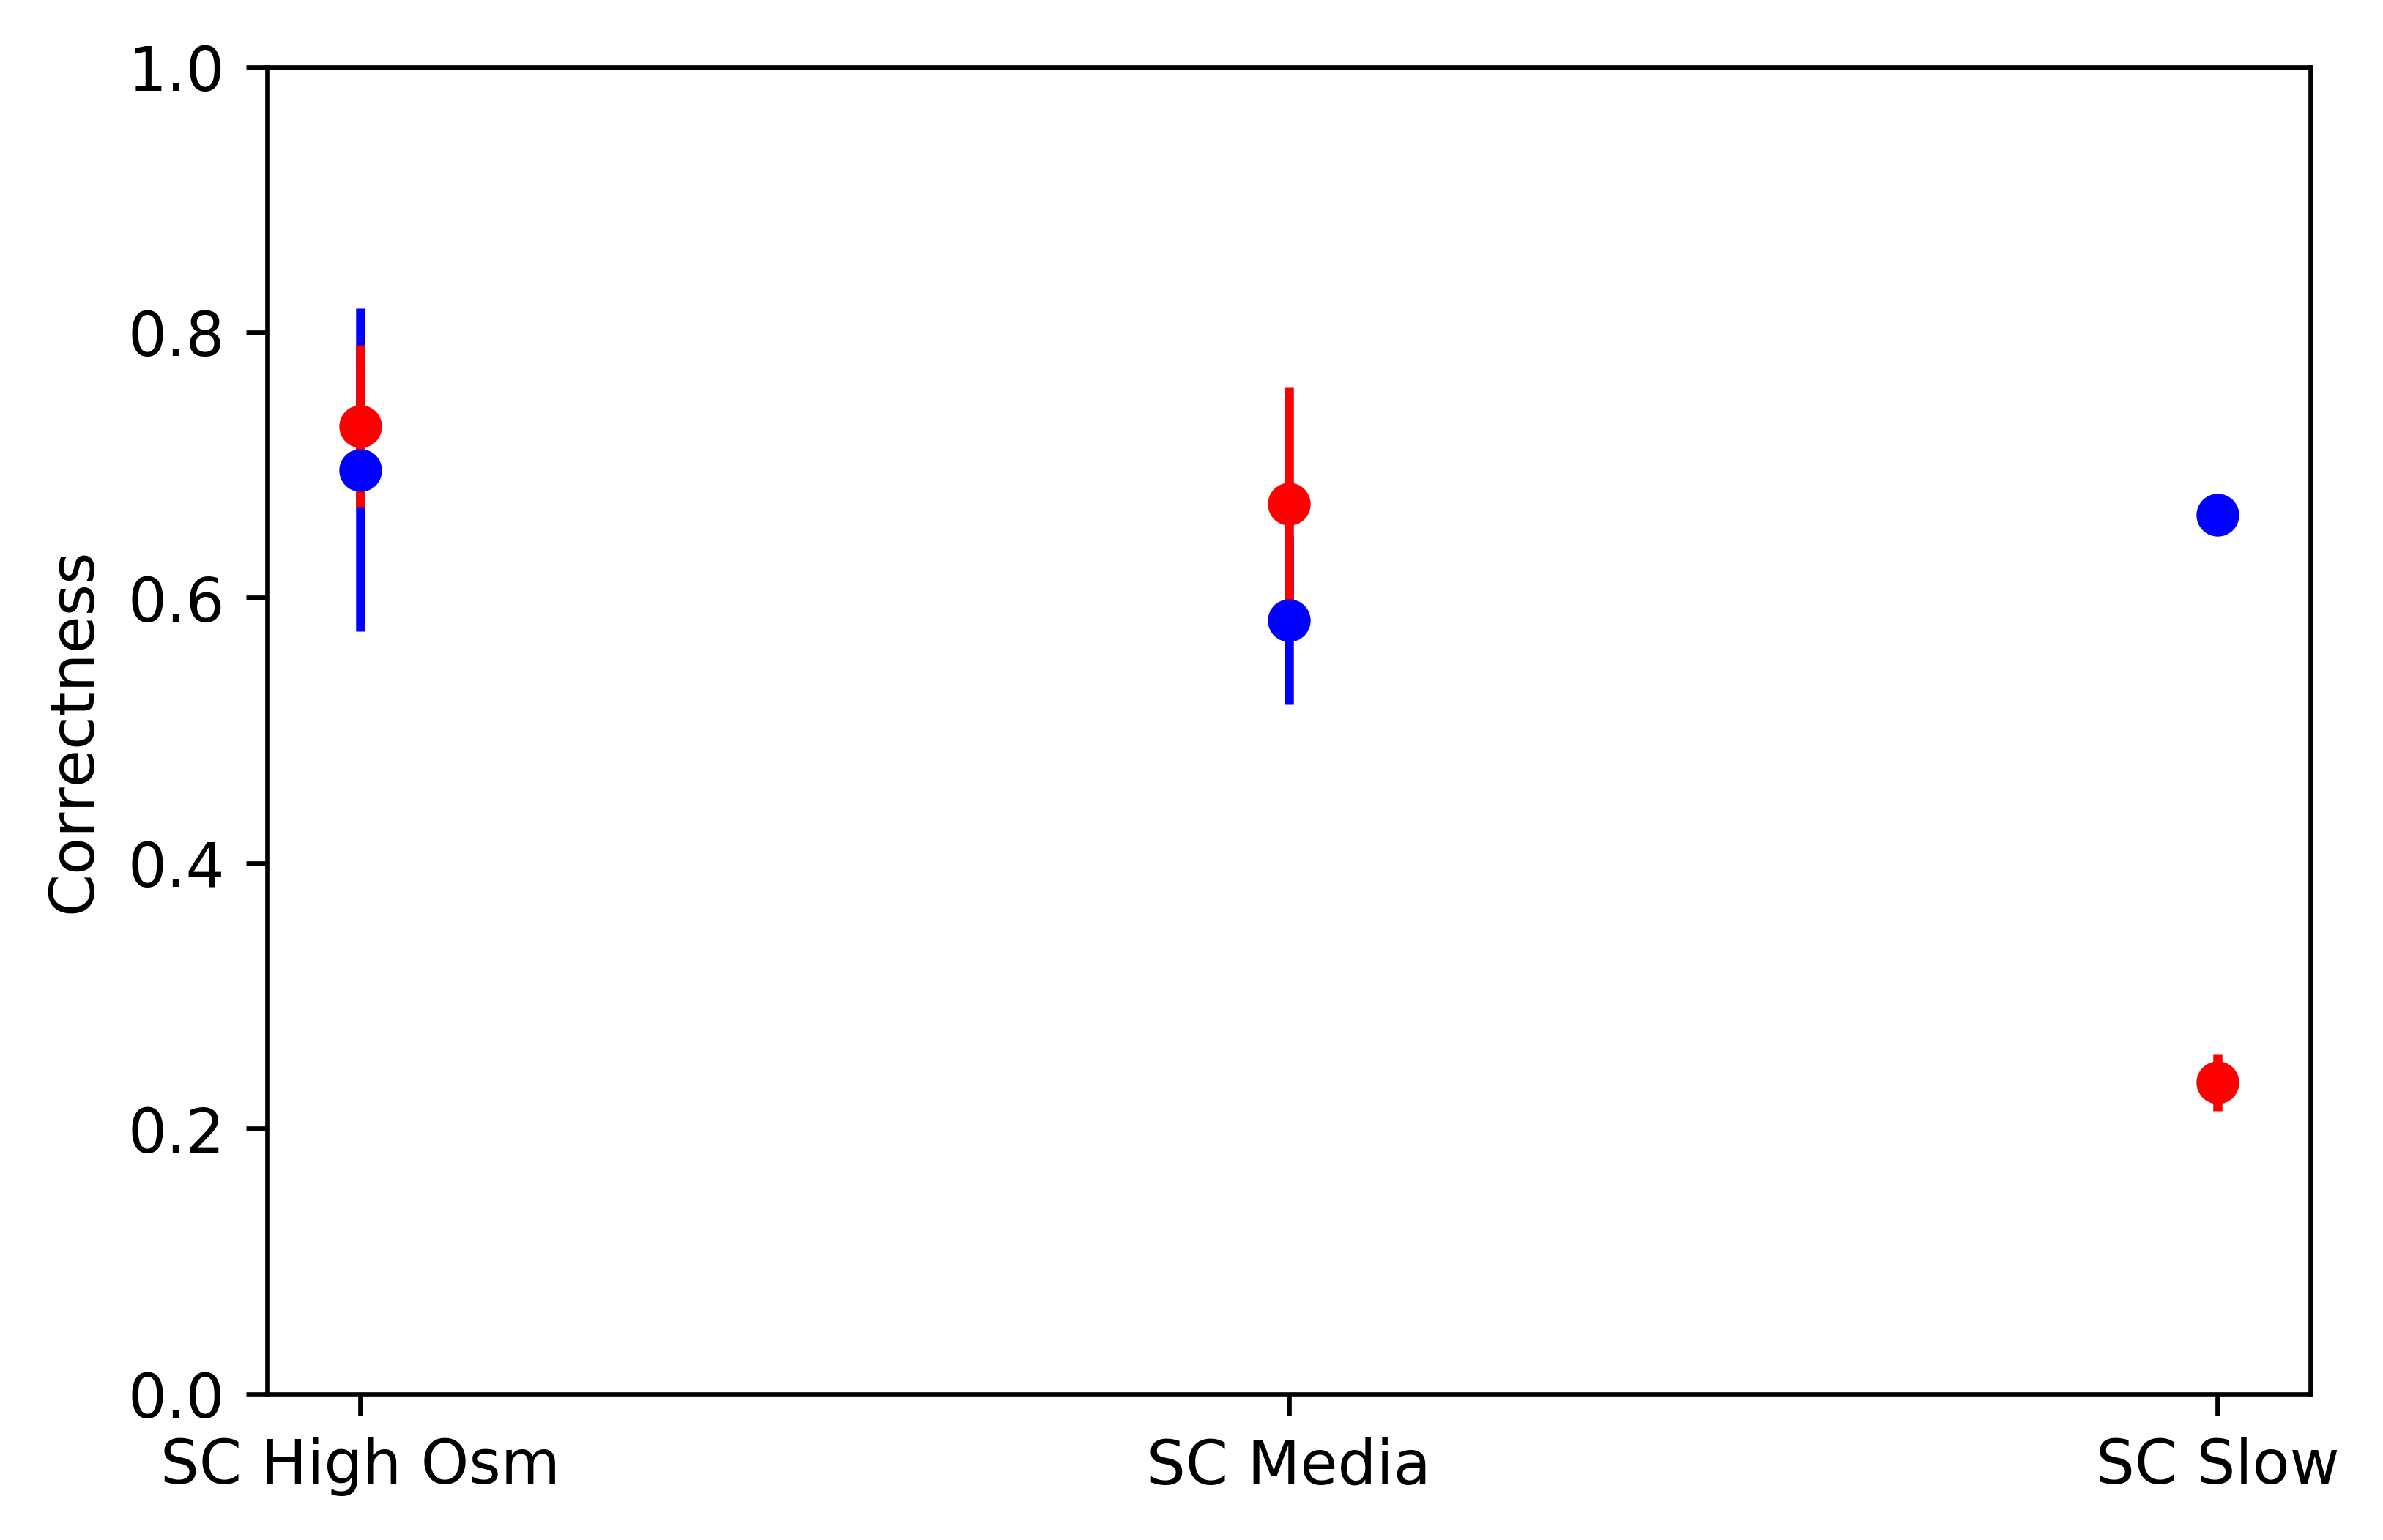

In [30]:
errorplot("AND")

In [31]:
mpl.rcParams['figure.dpi']= 600
csdp1 = circuit_score_df_prod
# make error bar plots
def whisker(gate):
    plt.figure()
    df_prod = csdp1[(csdp1["gate"]==gate)]
    data30_sc = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="SC Media")][correctness_col].values
    data30_osm = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="SC High Osm")][correctness_col].values
    data30_slow = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="SC Slow")][correctness_col].values
    data37_sc = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="SC Media")][correctness_col].values
    data37_osm = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="SC High Osm")][correctness_col].values
    data37_slow = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="SC Slow")][correctness_col].values
    datasc=[data30_sc,data30_osm,data30_slow,data37_sc,data37_osm,data37_slow]
    plt.boxplot(datasc,patch_artist=True,boxprops=dict(facecolor="lightgray"))
    labels = list(y+"\n"+str(x) for x,y in itertools.product([30.0,37.0],["SC Media","High Osm","SC Slow"]))
    plt.xticks(range(1,7), labels, fontsize=10)
    plt.xlim((0.5,6.5))
    plt.ylim((-0.1,1))
    plt.ylabel("Correctness") 
    

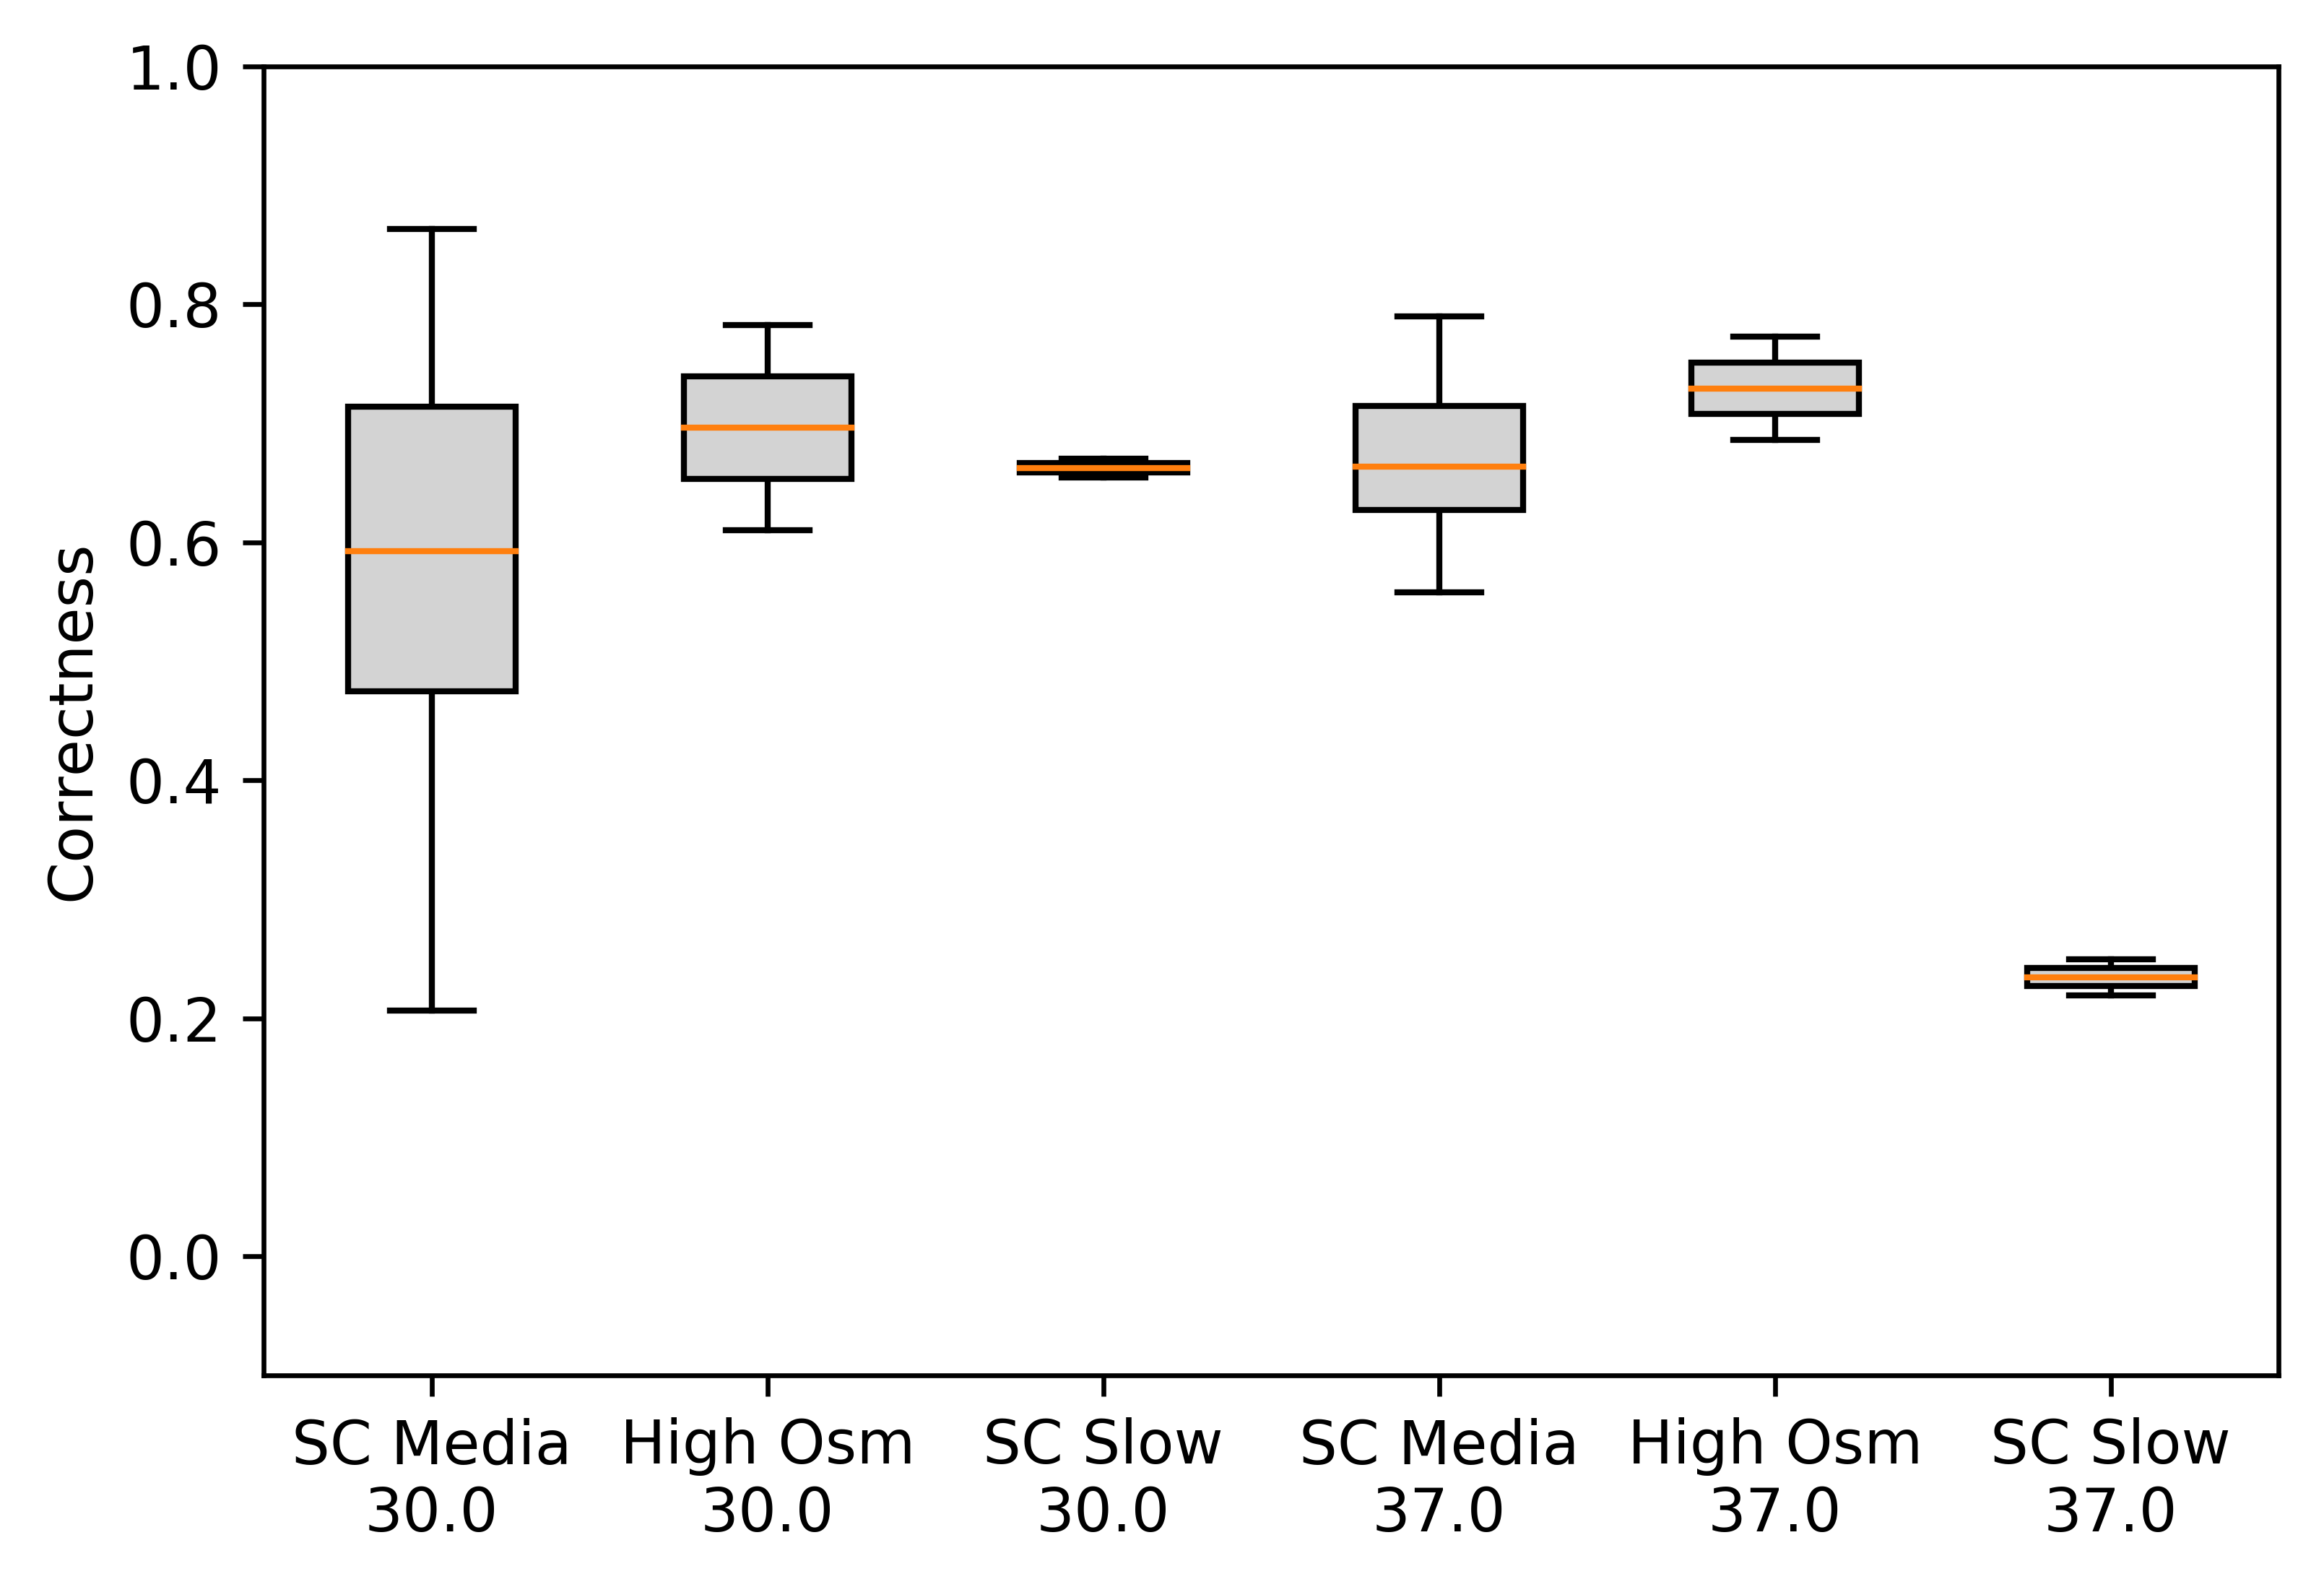

In [32]:
whisker("AND")

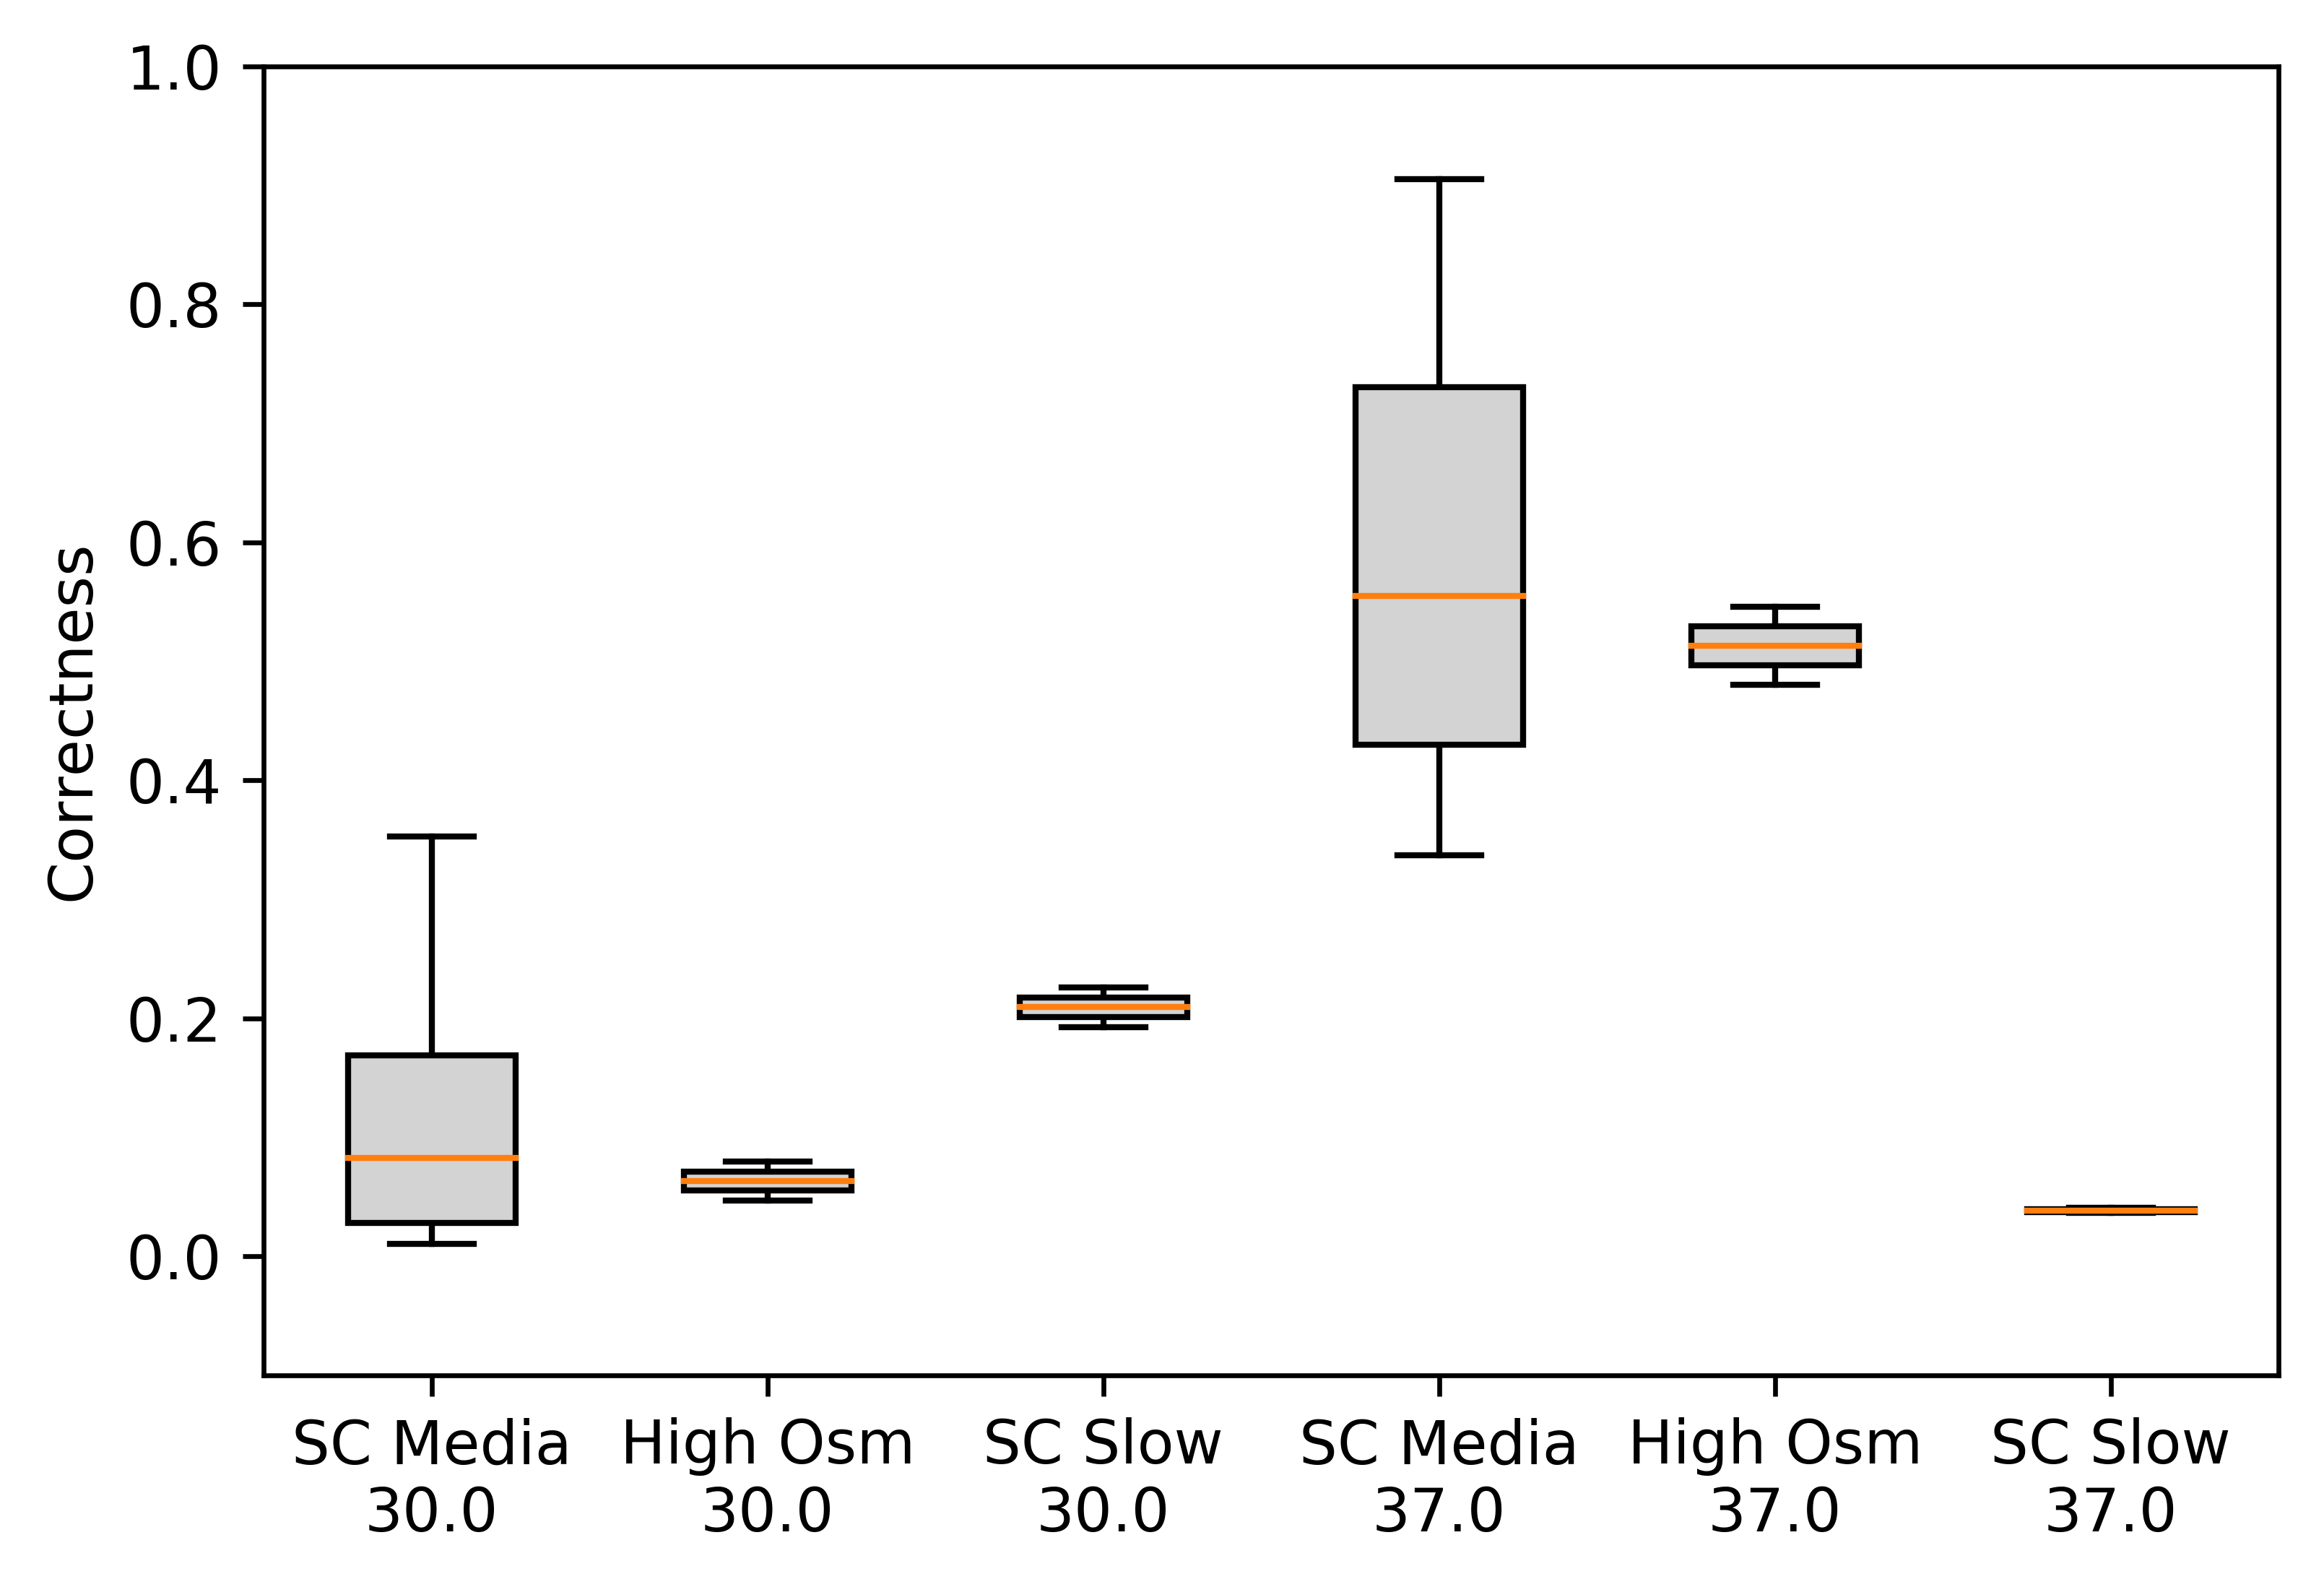

In [33]:
whisker("NAND")

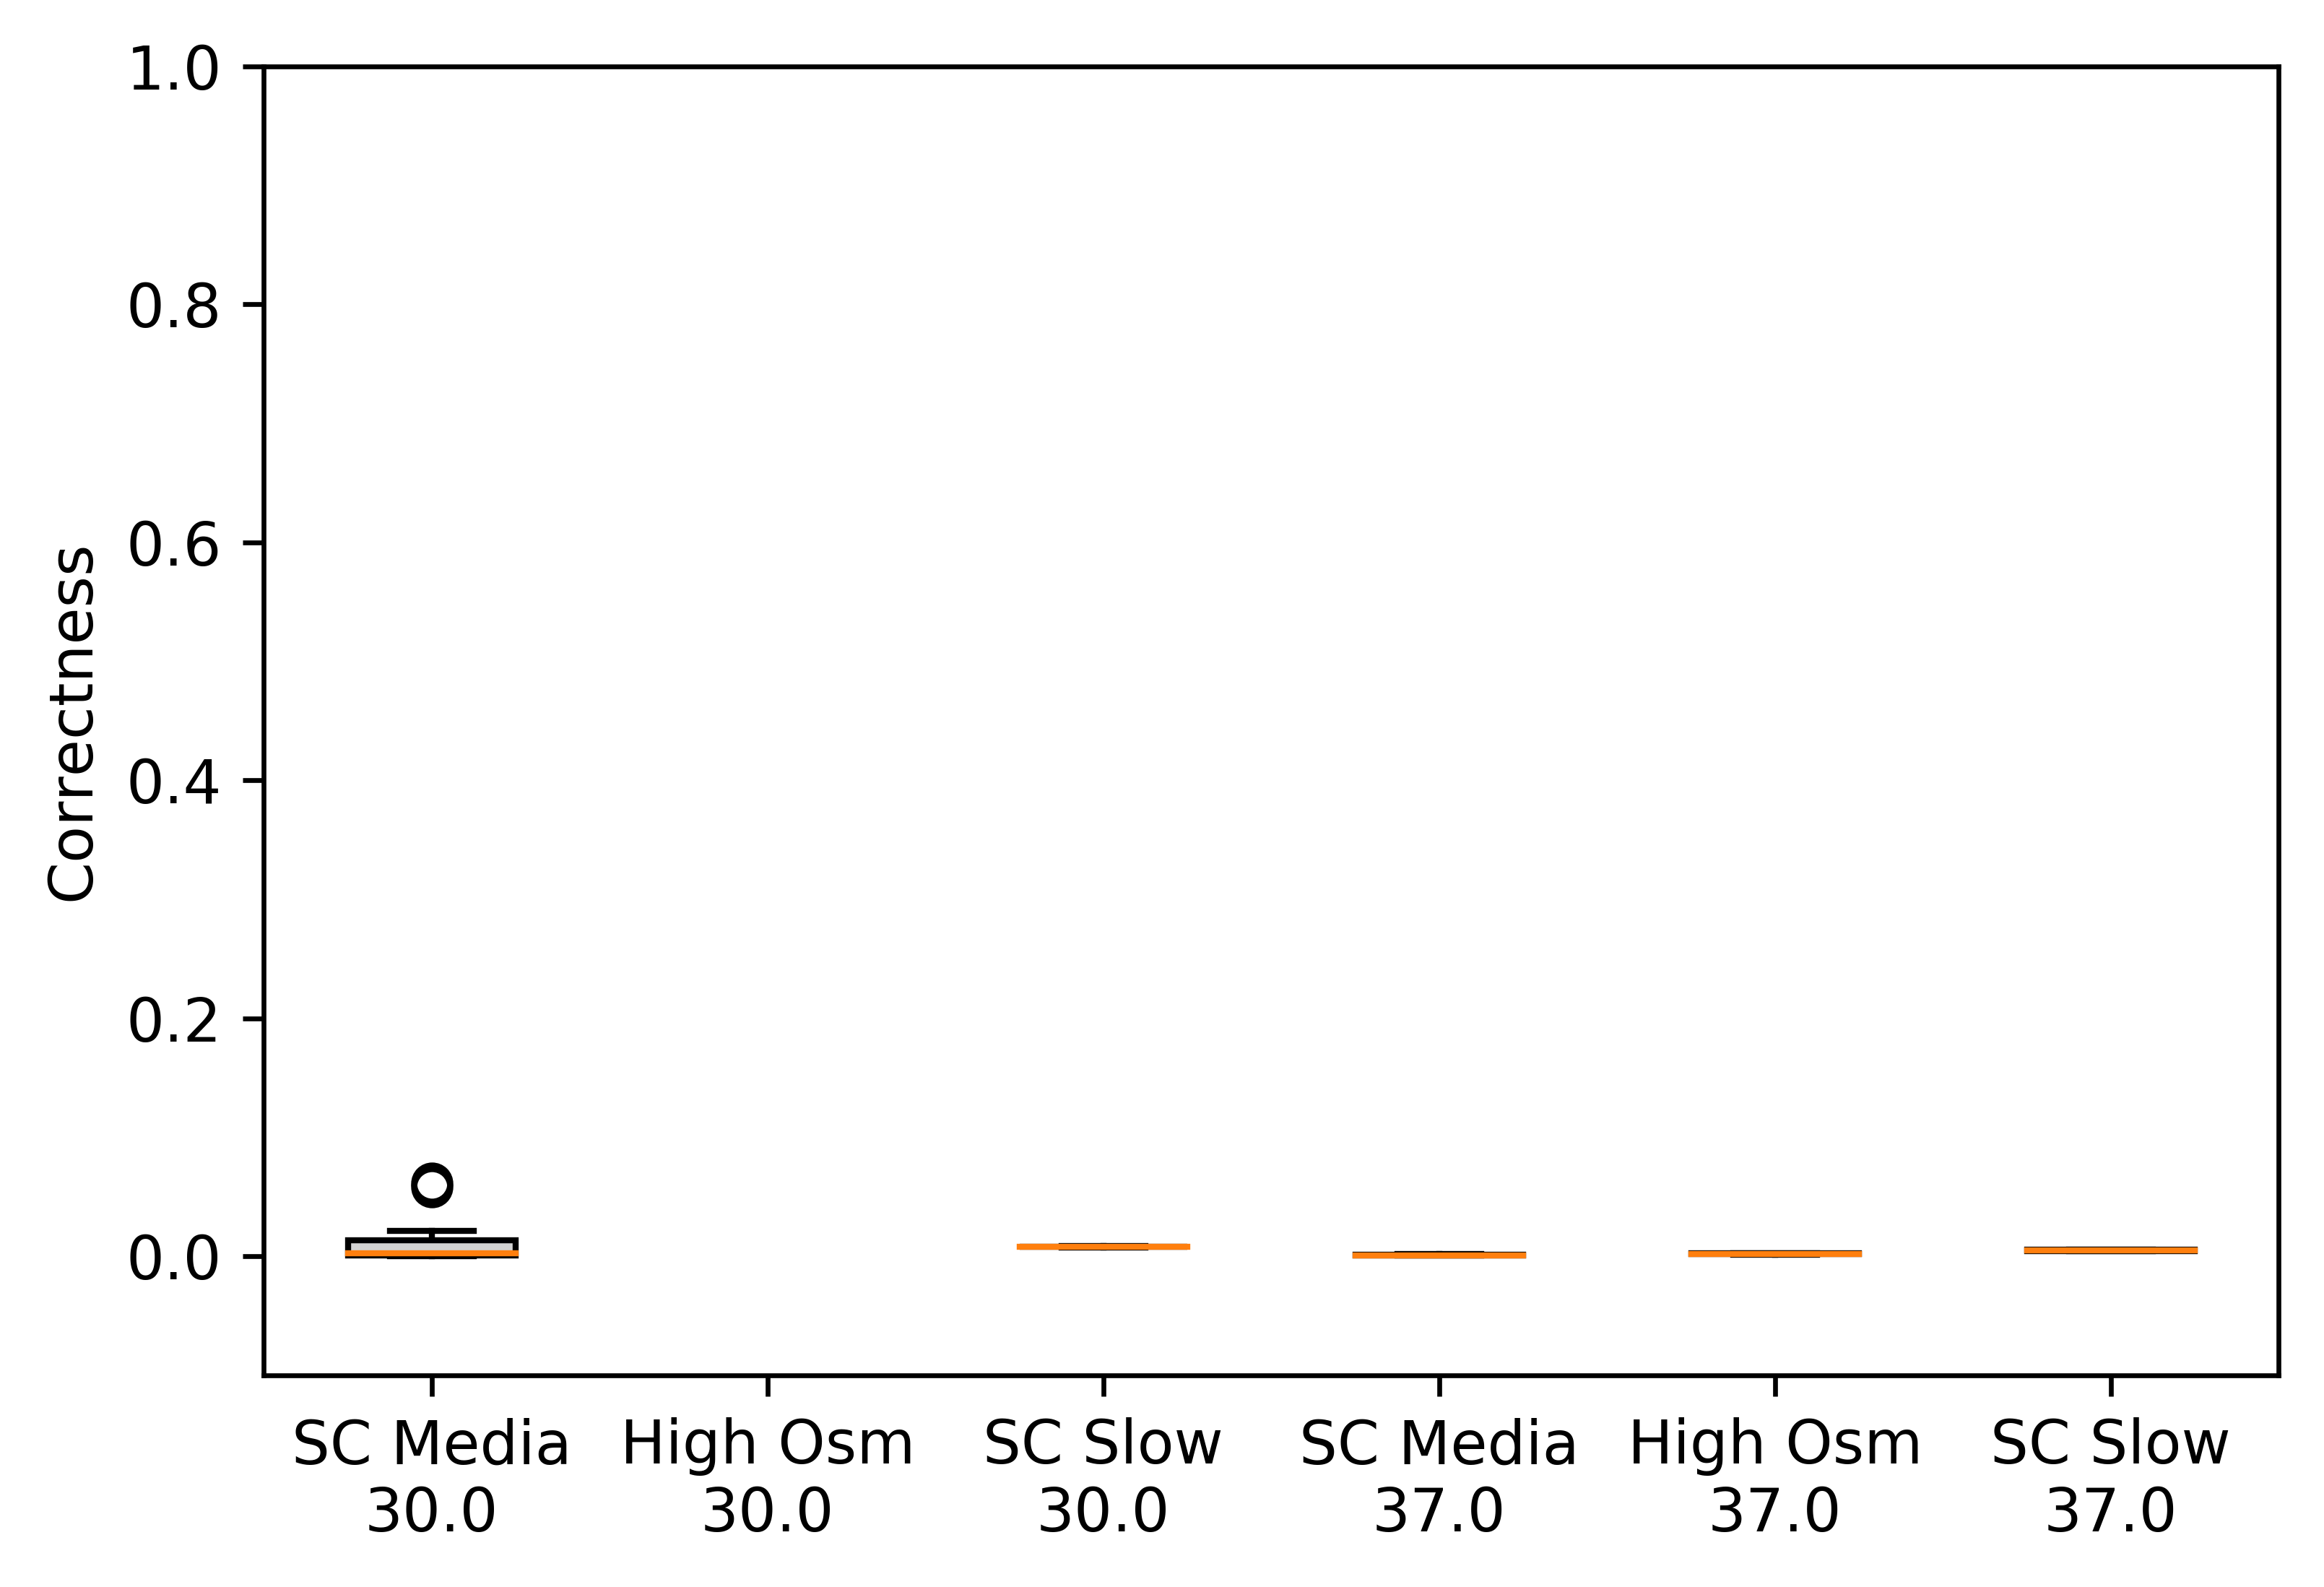

In [34]:
whisker("OR")

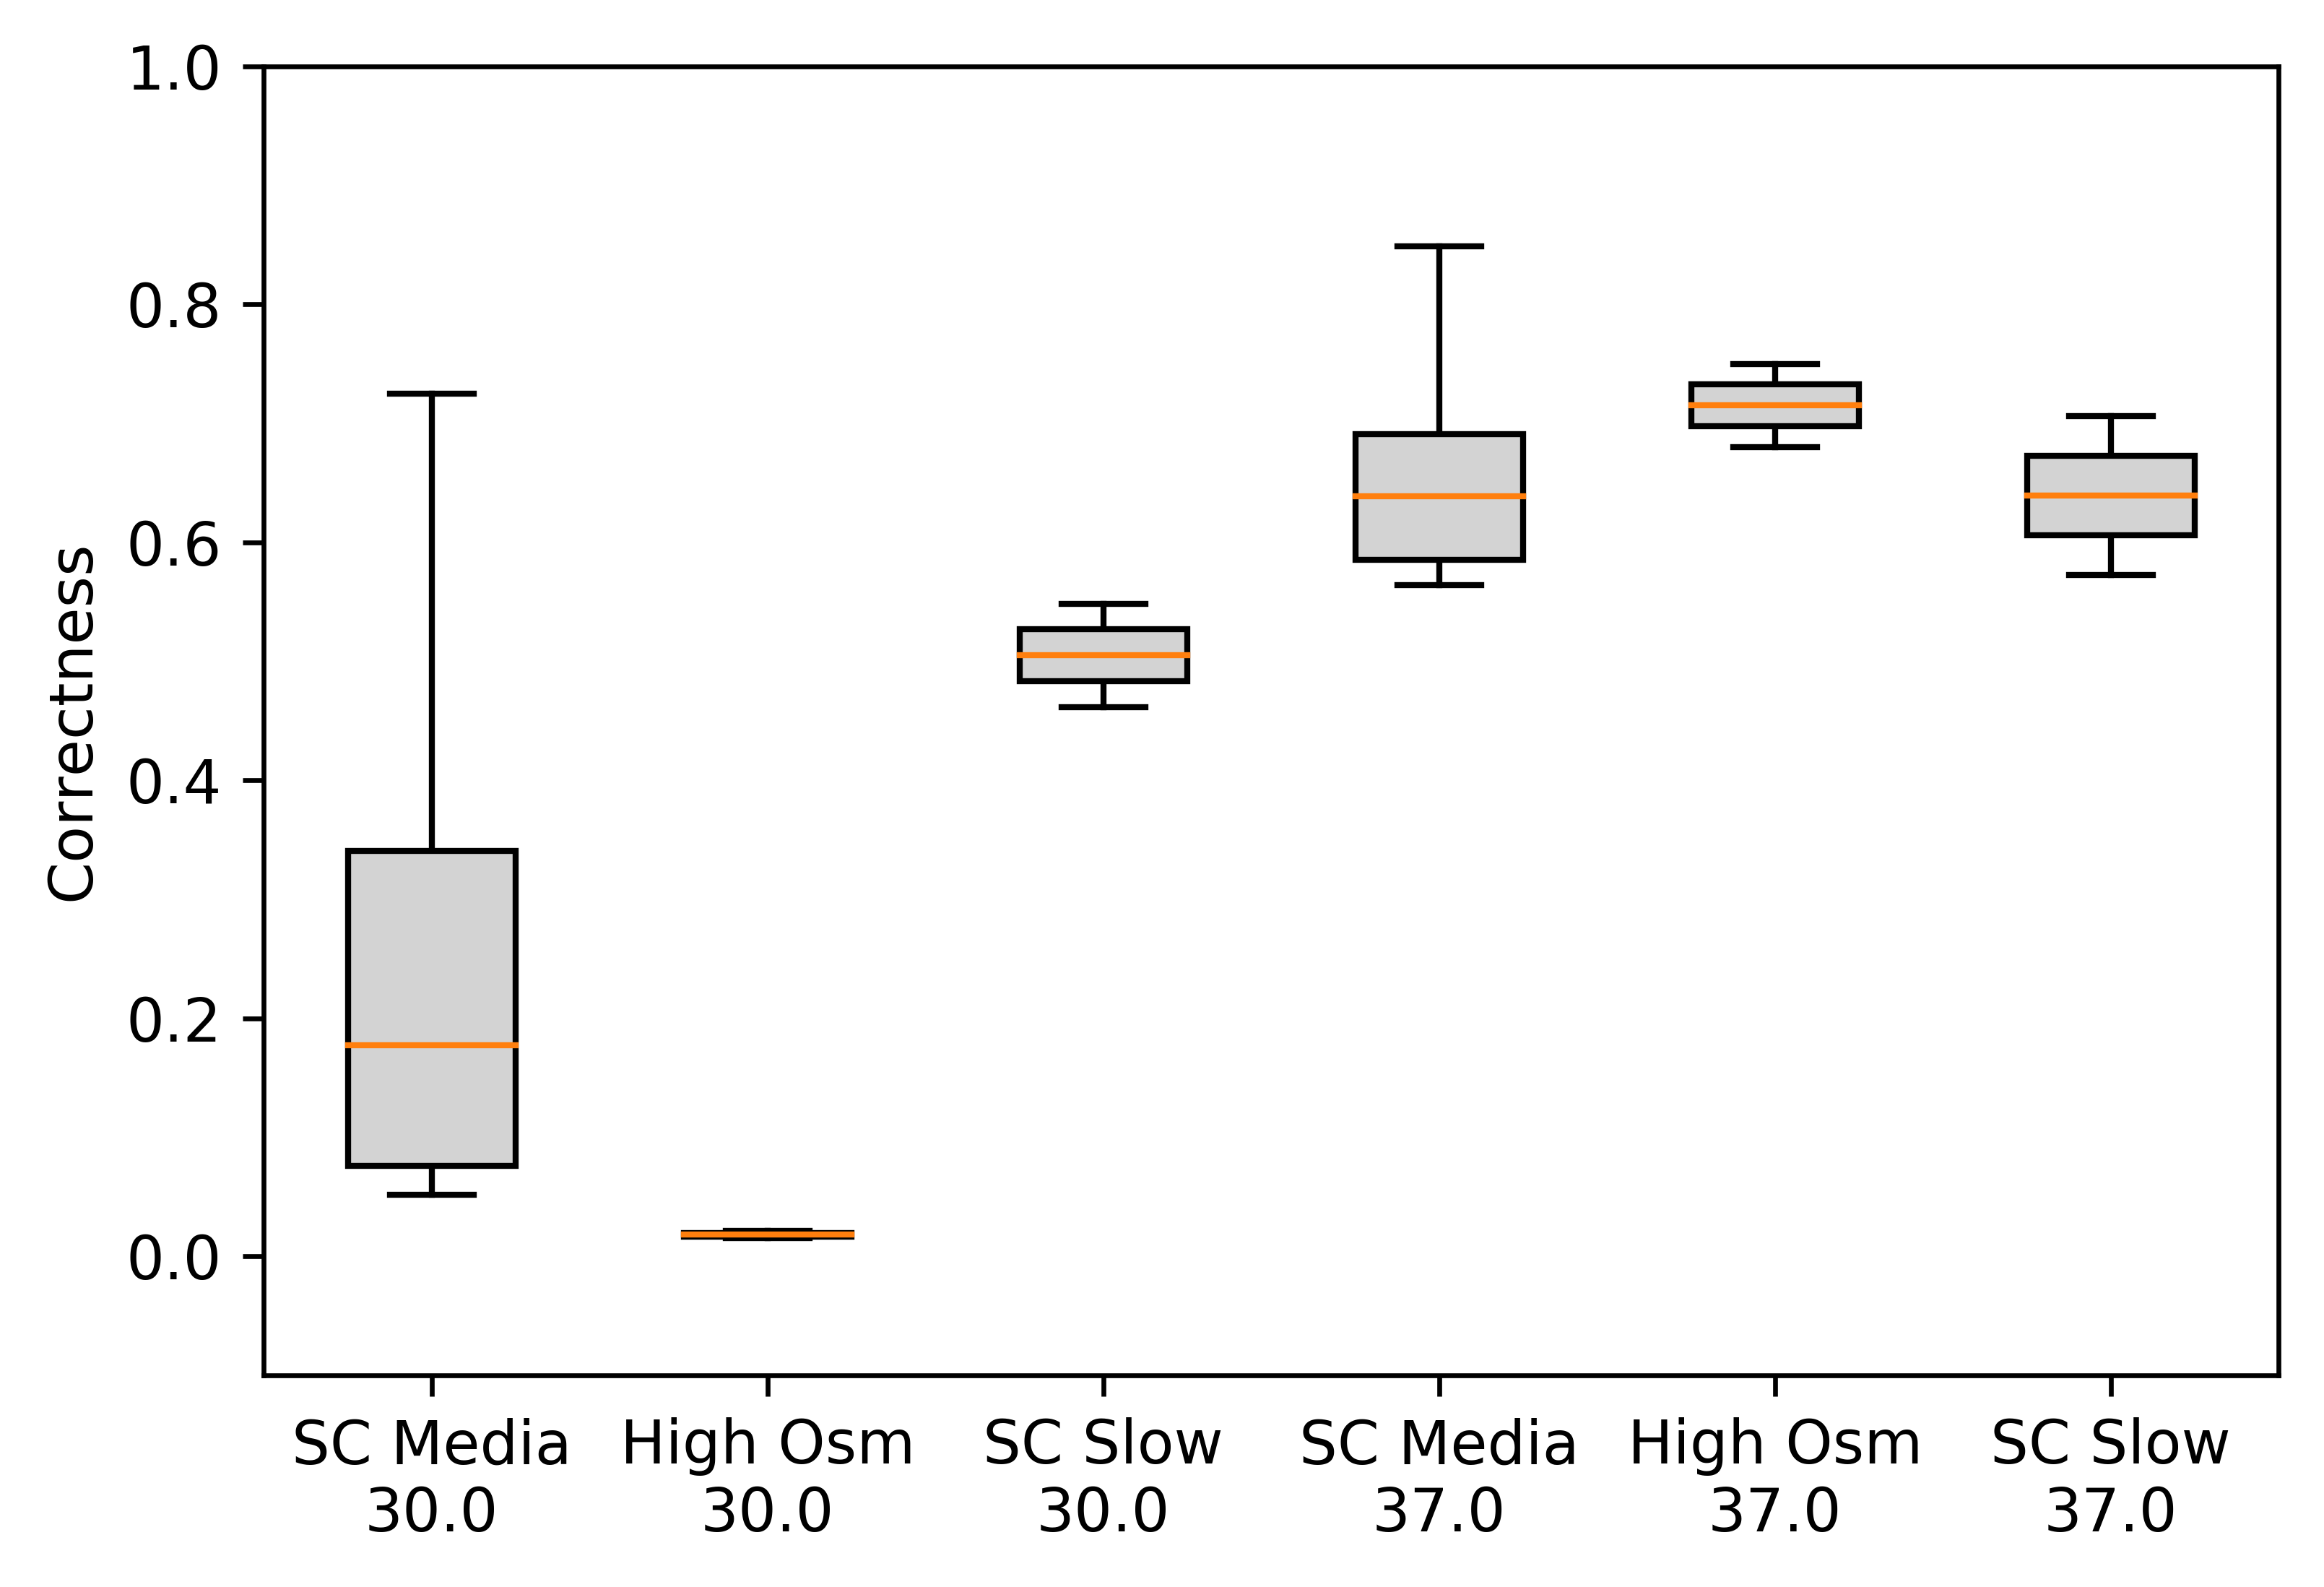

In [35]:
whisker("NOR")

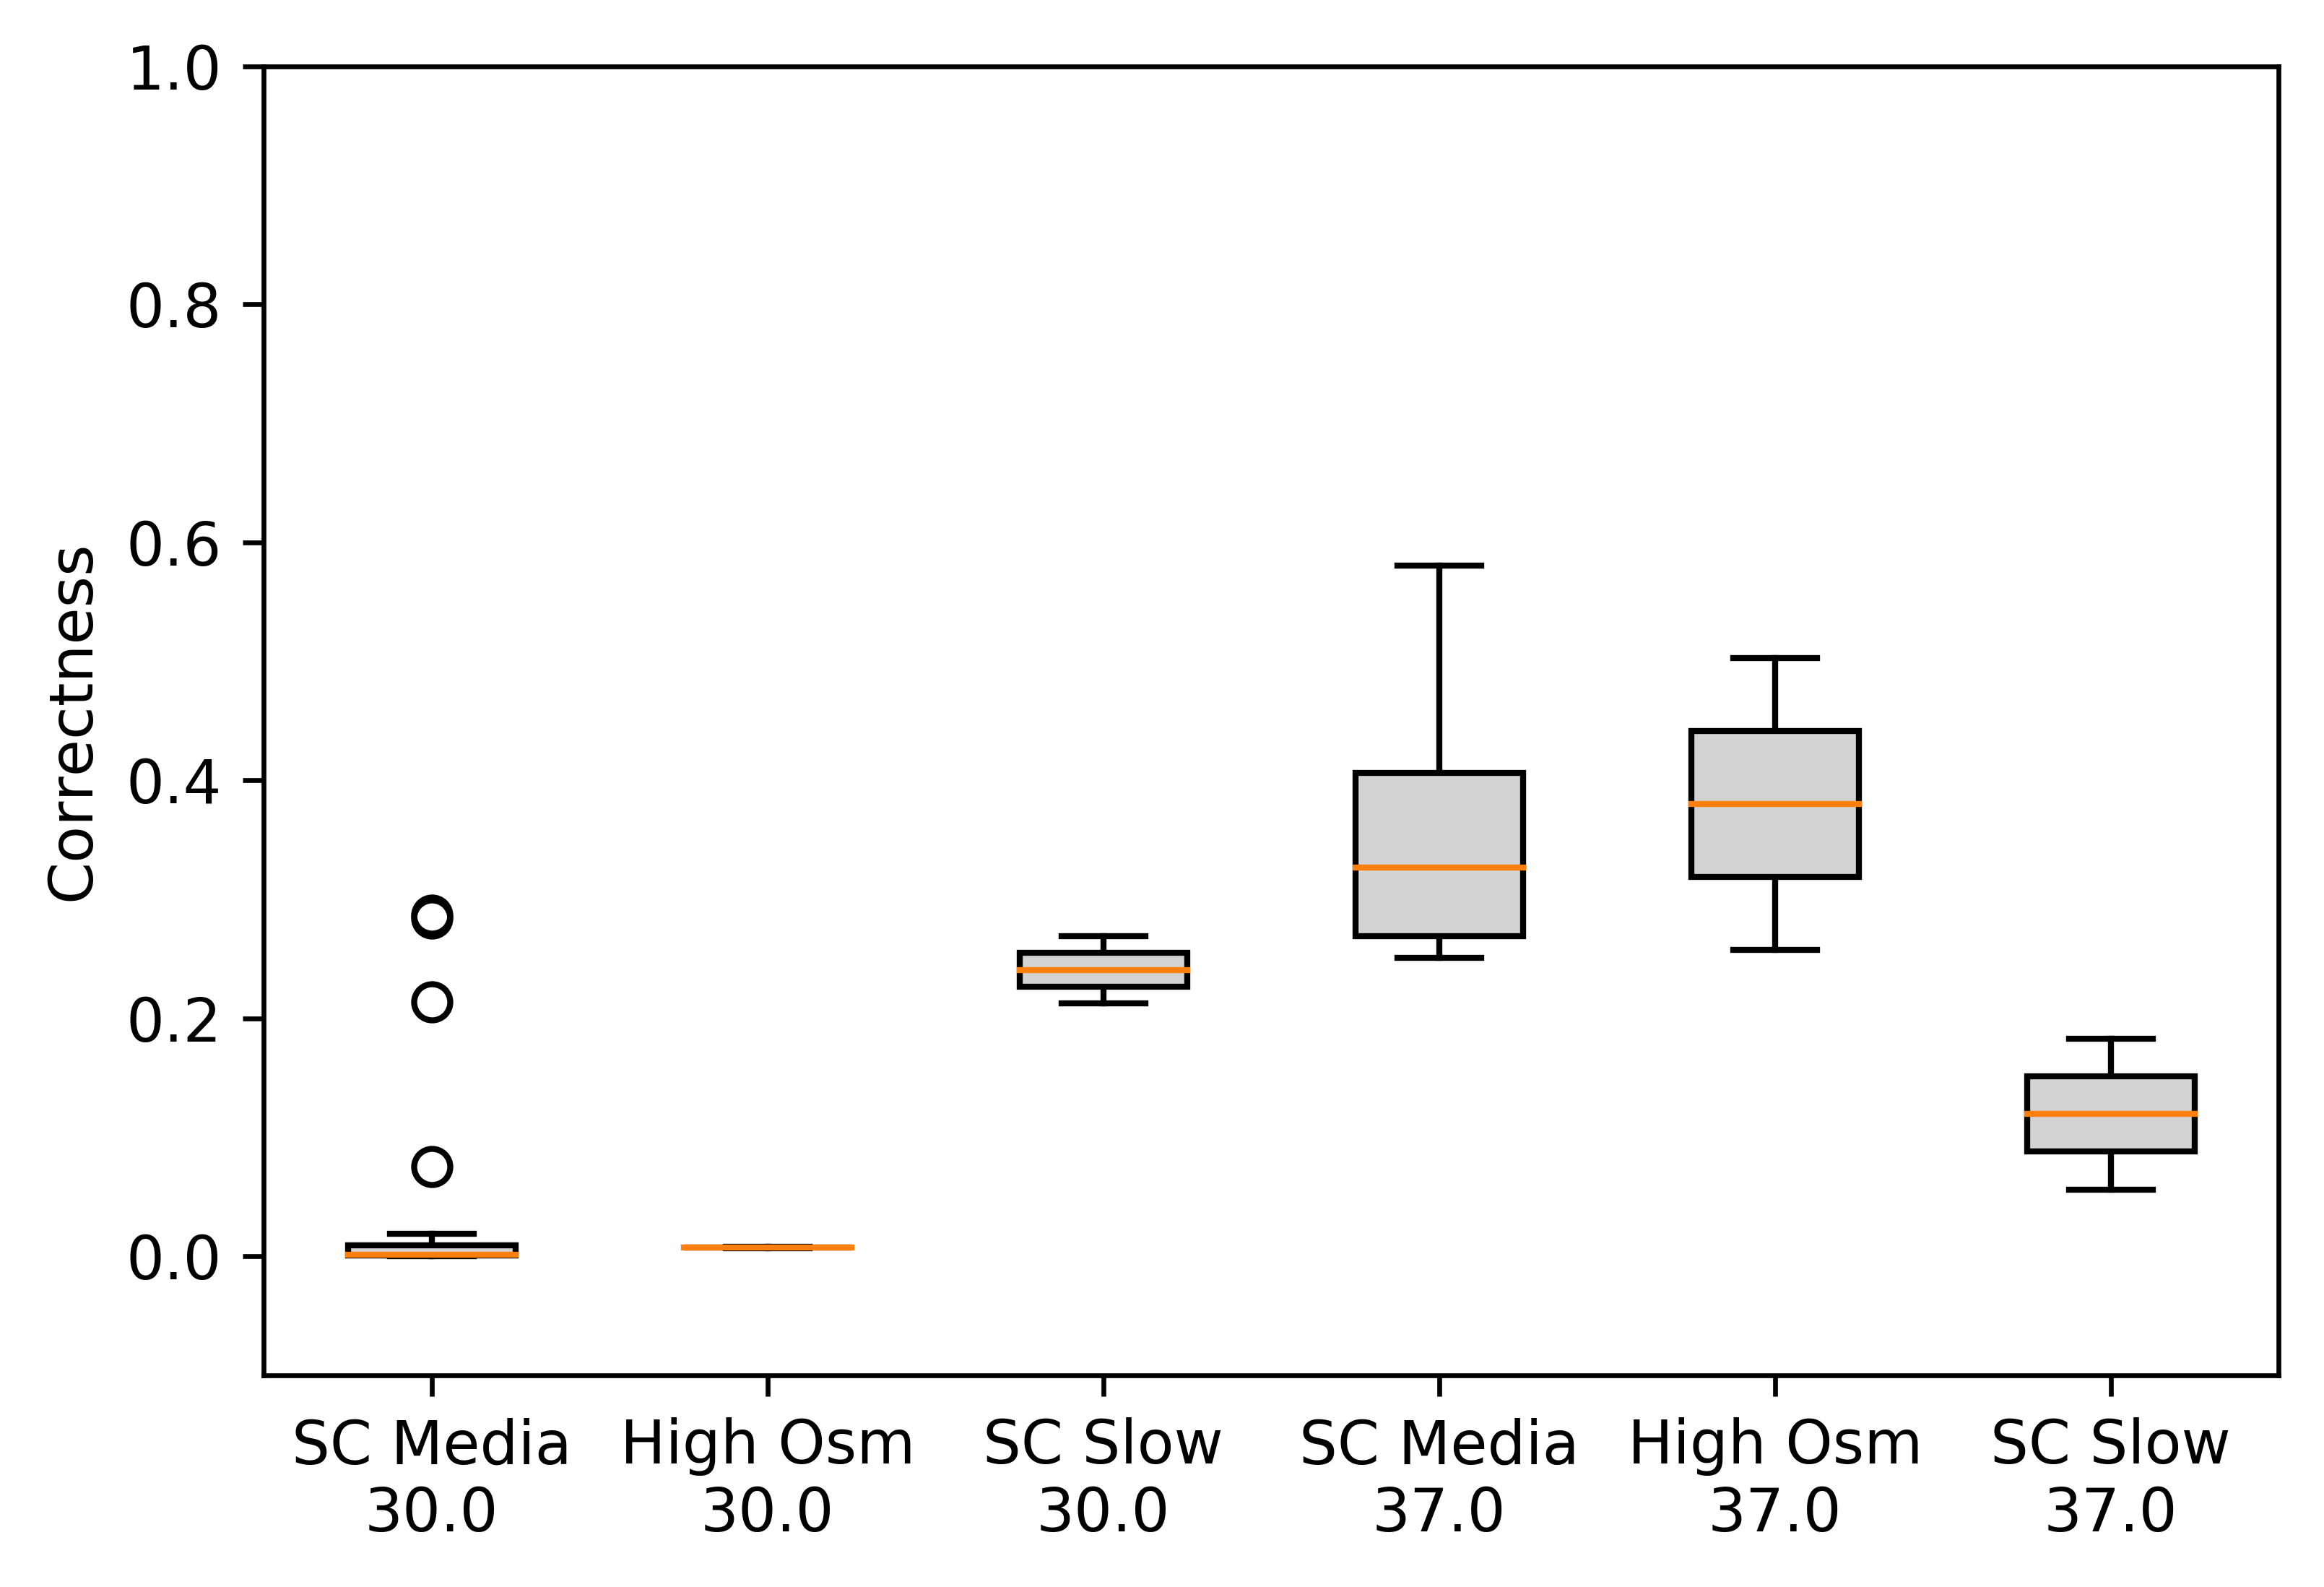

In [36]:
whisker("XOR")

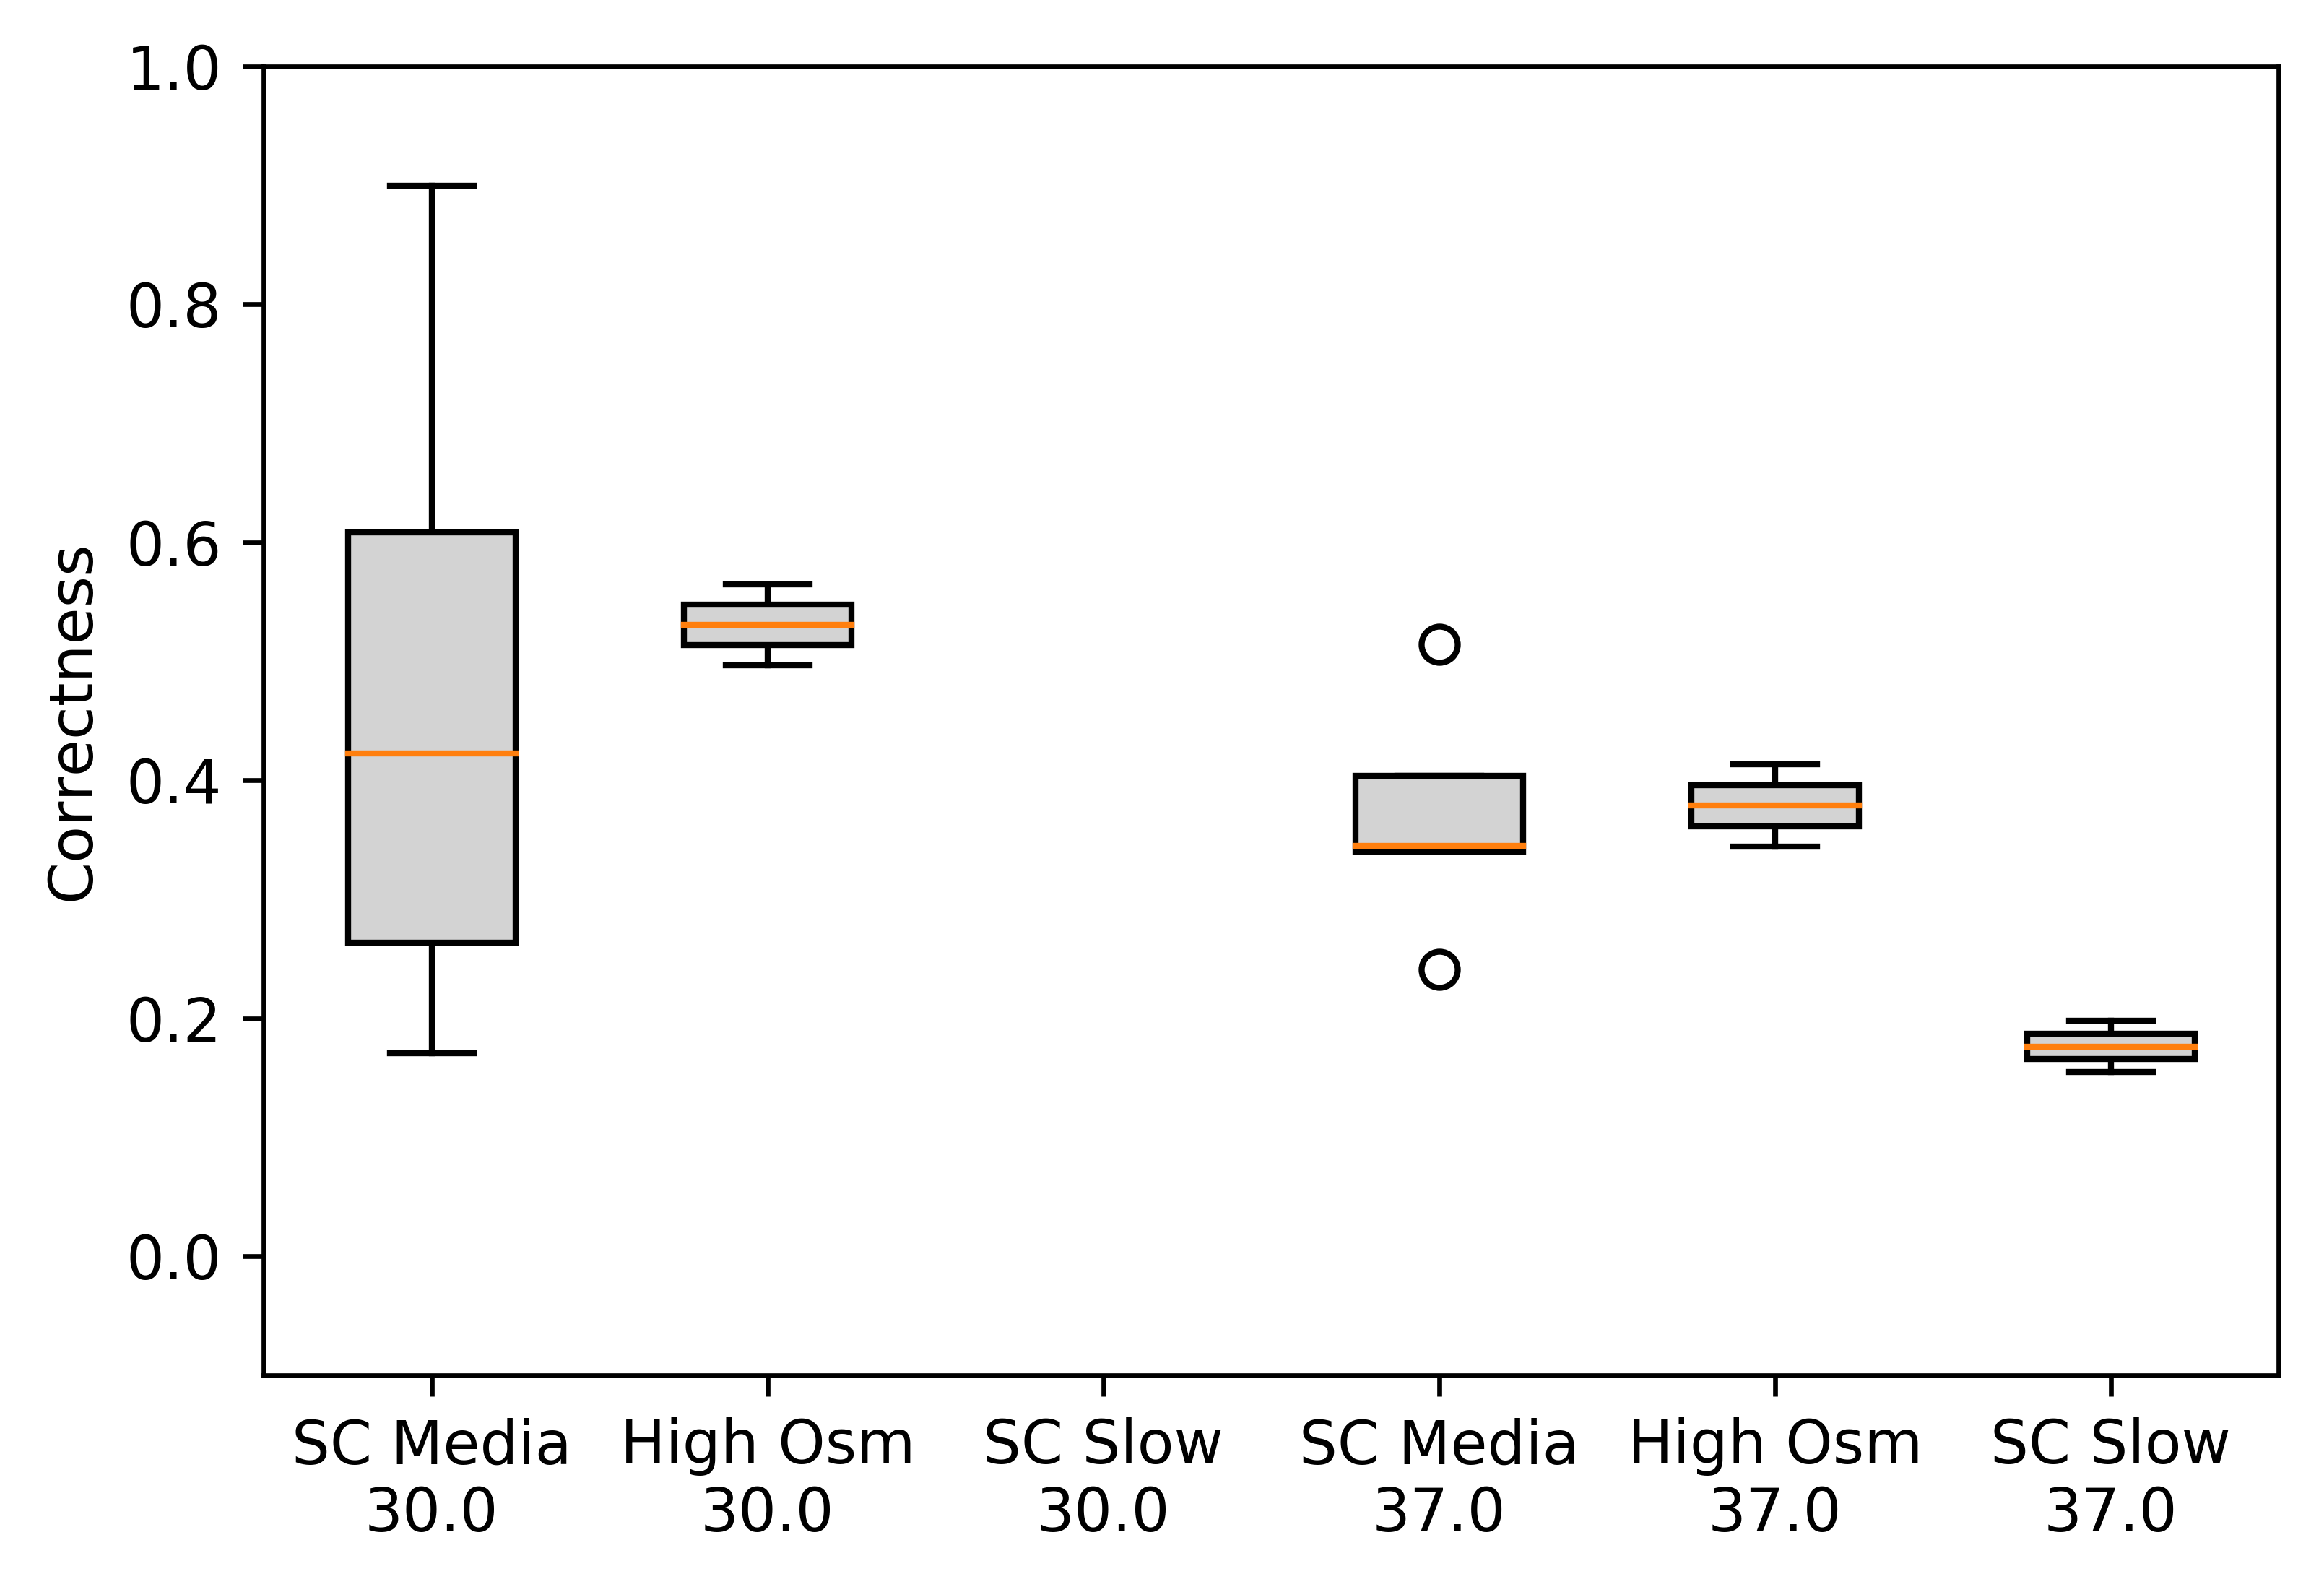

In [37]:
whisker("XNOR")